In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc2


## Loading

In [90]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "nhis_income_pca",
    "normalize": True,
  },
  "handle_imbalance": None,
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": True
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 64,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0000,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.0,
      "scale_factor": 4
    },
    "fedmechw_new": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "gamma": 0.0,
      "scale_factor": 4
    },
    "fedmechw_new2": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "gamma": 0.0,
      "scale_factor": 4,
      "mm_thres": 200
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 300,
            "learning_rate": 0.001,
            "weight_decay": 0.0,
            "pred_round": 500,
            "pred_local_epochs": 3,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [6]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
def vis_mm_sim(mm_coefs, metric = 'cos'):
    n_cols = 5
    n_rows = (mm_coefs.shape[0] - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(mm_coefs.shape[0]):
        
        X = mm_coefs[feature_idx]
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        if metric == 'cos':
            cosine_sim = 1 - (cosine_similarity(X) + 1)/2
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        else:
            raise NotImplementedError
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("Mechanism Similarity")
    plt.tight_layout()
    plt.show()

10 0.14185106490048777
50 0.2689414213699951
100 0.5
200 0.8807970779778823
500 0.9996646498695336
1000 0.9999999847700205


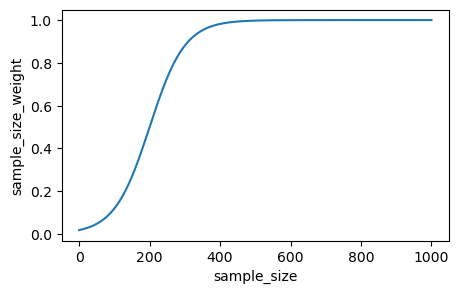

In [7]:
def sigmoid(x, thres, steep):
    return 1 / (1 + np.exp(-steep * (x - thres)))

for x in np.array([10, 50, 100, 200, 500, 1000]):
    print(x, sigmoid(x, 100, 0.02))
    
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
x = np.arange(0, 1000, 0.1)
y = sigmoid(x, 200, 0.02)
ax.plot(x, y)
ax.set_xlabel("sample_size")
ax.set_ylabel("sample_size_weight")
plt.show()

# CodRNA

In [18]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

## Clients MNAR LR

### Simple Avg

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 11:05:17.499 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:05:17.500 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 11:05:50.668 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:05:50.669 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 11:06:22.704 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:06:22.705 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 11:06:25.941 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 70.93176599999424


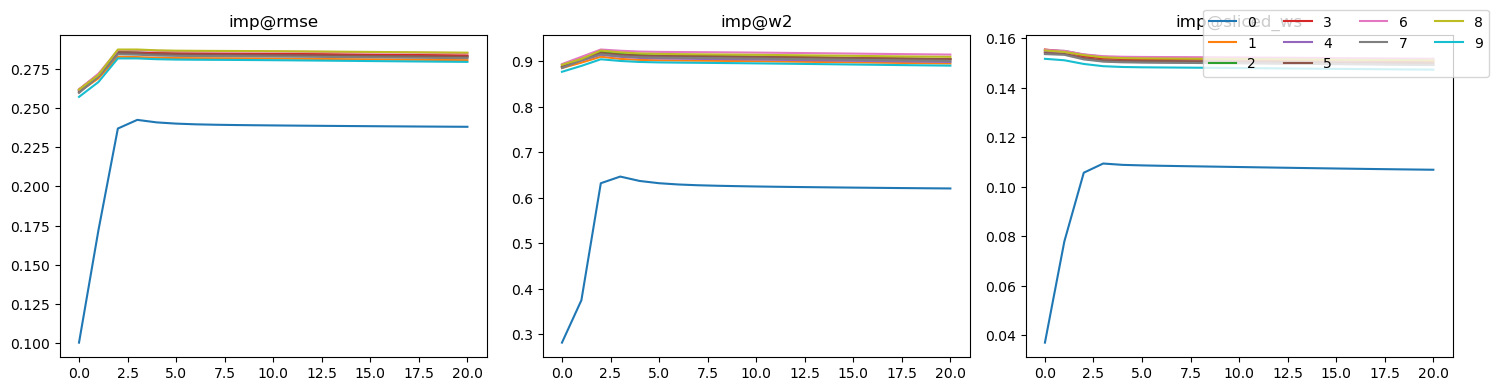

{'imp@rmse': 0.27822271001114046, 'imp@ws': 0.8747674771979429, 'imp@sliced_ws': 0.14578667183696412}


2023-10-23 11:06:30.397 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.6700, test_f1: 0.0000 test_auroc: 0.7887 test_auprc: 0.6553 train_loss: 0.6613 val_accu: 0.6694 val_f1: 0.4010
2023-10-23 11:06:40.326 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 100, test_accu: 0.7645, test_f1: 0.5149 test_auroc: 0.7861 test_auprc: 0.6899 train_loss: 0.5084 val_accu: 0.7694 val_f1: 0.7049
2023-10-23 11:06:50.306 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 200, test_accu: 0.7375, test_f1: 0.4312 test_auroc: 0.6924 test_auprc: 0.5976 train_loss: 0.4788 val_accu: 0.7858 val_f1: 0.7128
2023-10-23 11:07:00.360 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 300, test_accu: 0.7500, test_f1: 0.4505 test_auroc: 0.5958 test_auprc: 0.5414 train_loss: 0.4655 val_accu: 0.7950 val_f1: 0.7338
2023-1

0.7805 0.5800711743772242 0.8651368159203982 0.7495456107598423


In [8]:
name = 'mnar_lr_codrna_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

### Complementary Purely

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 11:07:32.764 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:07:32.765 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 11:08:02.512 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:08:02.514 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 11:08:35.635 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:08:35.635 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 11:08:38.980 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 68.6493974000332


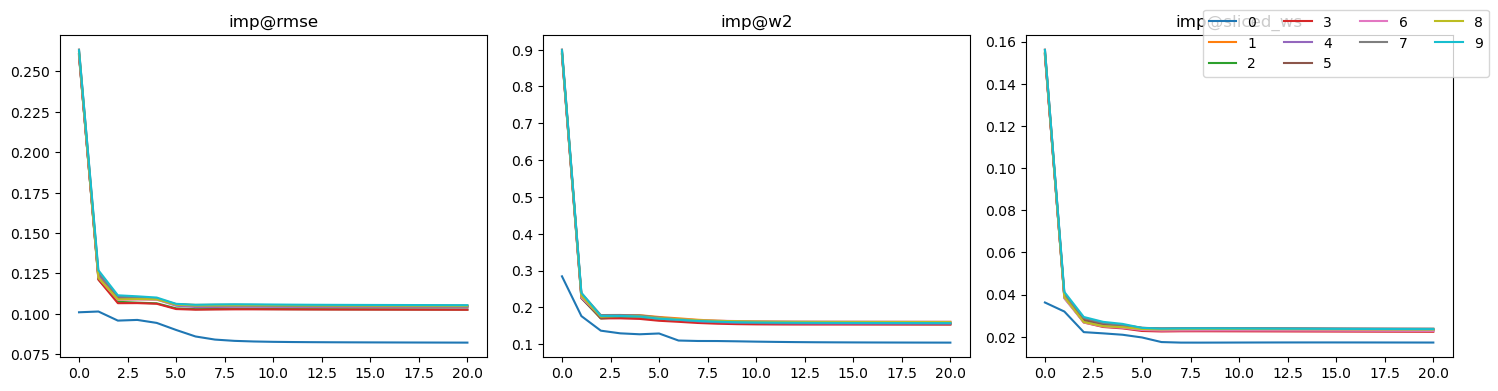

2023-10-23 11:08:39.425 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.6685, test_f1: 0.0000 test_auroc: 0.6875 test_auprc: 0.5348 train_loss: 0.6596 val_accu: 0.6694 val_f1: 0.4010


{'imp@rmse': 0.10204213462868265, 'imp@ws': 0.15209221330009157, 'imp@sliced_ws': 0.022669332012629793}


2023-10-23 11:08:49.364 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 100, test_accu: 0.9310, test_f1: 0.9011 test_auroc: 0.9811 test_auprc: 0.9546 train_loss: 0.3473 val_accu: 0.8403 val_f1: 0.8148
2023-10-23 11:08:59.251 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 200, test_accu: 0.9370, test_f1: 0.9065 test_auroc: 0.9819 test_auprc: 0.9591 train_loss: 0.3400 val_accu: 0.8503 val_f1: 0.8188
2023-10-23 11:09:09.208 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 300, test_accu: 0.9330, test_f1: 0.9030 test_auroc: 0.9802 test_auprc: 0.9585 train_loss: 0.3293 val_accu: 0.8572 val_f1: 0.8329
2023-10-23 11:09:19.392 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 400, test_accu: 0.9275, test_f1: 0.8956 test_auroc: 0.9788 test_auprc: 0.9569 train_loss: 0.3209 val_accu: 0.8597 val_f1: 0.8366


0.9395 0.910436713545522 0.9827770012555969 0.9615346191111134


In [9]:
name = 'mnar_lr_codrna_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

### Complementary split

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 11:13:13.791 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:13:13.792 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 11:13:43.278 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:13:43.279 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 11:14:15.961 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:14:15.961 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 11:14:48.514 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:14:48.515 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

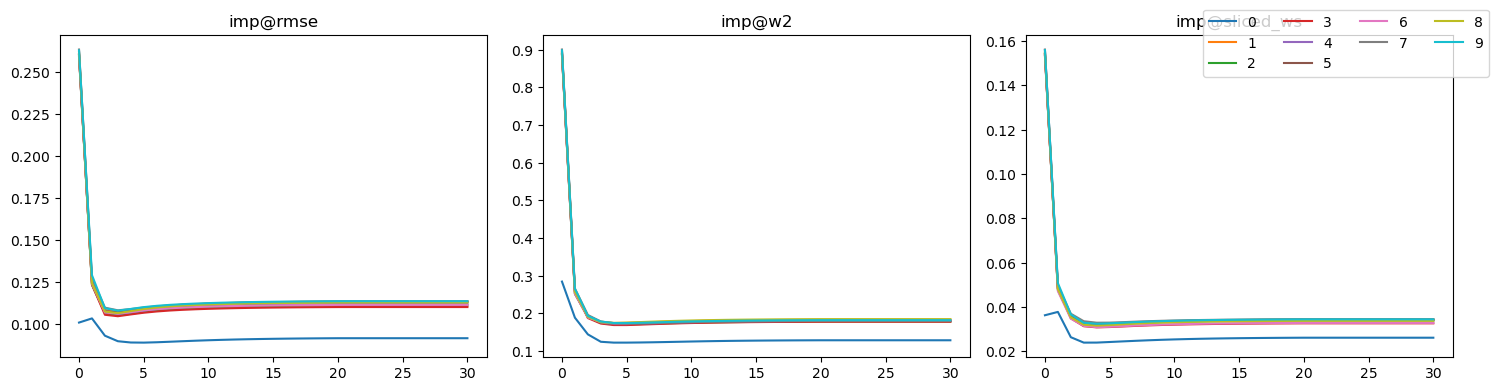

2023-10-23 11:14:52.201 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.6685, test_f1: 0.0000 test_auroc: 0.7020 test_auprc: 0.5441 train_loss: 0.6596 val_accu: 0.6694 val_f1: 0.4010


{'imp@rmse': 0.11028150345918354, 'imp@ws': 0.17551164292157811, 'imp@sliced_ws': 0.03302771919151228}


2023-10-23 11:15:02.162 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 100, test_accu: 0.9245, test_f1: 0.8900 test_auroc: 0.9725 test_auprc: 0.9388 train_loss: 0.3463 val_accu: 0.8433 val_f1: 0.8167
2023-10-23 11:15:11.872 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 200, test_accu: 0.9265, test_f1: 0.8915 test_auroc: 0.9737 test_auprc: 0.9442 train_loss: 0.3388 val_accu: 0.8508 val_f1: 0.8199
2023-10-23 11:15:21.478 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 300, test_accu: 0.9230, test_f1: 0.8884 test_auroc: 0.9733 test_auprc: 0.9456 train_loss: 0.3284 val_accu: 0.8567 val_f1: 0.8313
2023-10-23 11:15:31.196 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 400, test_accu: 0.9210, test_f1: 0.8855 test_auroc: 0.9718 test_auprc: 0.9443 train_loss: 0.3195 val_accu: 0.8539 val_f1: 0.8296


0.936 0.9060205580029369 0.9764809669336925 0.9516235138874582


In [11]:
name = 'mnar_lr_codrna_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
config2["algo_params"]["fedmechw_new"] = {
    "alpha": 1.0,
    "gamma": 0.1,
    "client_thres": 1.0,
    "scale_factor": 4,
    'mm_thres': 0.05
}

config2['server']['imp_round'] = 30

config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

#### Split gamma tune

In [12]:
%matplotlib inline
results_gamma = []
for gamma in [0.0, 0.1, 0.3, 0.5, 0.75, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = mr_strategy
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
    config2['data_partition']['strategy'] = 'sample-evenly'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
        "alpha": 1.0,
        "gamma": gamma,
        "client_thres": 1.0,
        "scale_factor": 4,
        'mm_thres': 0.1
    }

    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed, vis = False)
    results_gamma.append(ret.copy())

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 11:18:58.494 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:18:58.495 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 11:19:28.792 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:19:28.793 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 11:20:01.946 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:20:01.946 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 11:20:35.332 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:20:35.333 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

{'imp@rmse': 0.10181048808297614, 'imp@ws': 0.151520692532257, 'imp@sliced_ws': 0.022513993042115578}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 11:20:51.204 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:20:51.205 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 11:21:20.872 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:21:20.872 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 11:21:54.079 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:21:54.080 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 11:22:26.897 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:22:26.898 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

{'imp@rmse': 0.09335472903524099, 'imp@ws': 0.13415922524520718, 'imp@sliced_ws': 0.023966406518022905}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 11:22:42.828 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:22:42.829 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 11:23:12.126 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:23:12.127 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 11:23:44.774 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:23:44.775 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 11:24:17.485 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:24:17.486 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

{'imp@rmse': 0.13752185423000277, 'imp@ws': 0.27723663606579174, 'imp@sliced_ws': 0.059971848523050646}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 11:24:33.416 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:24:33.416 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 11:25:02.636 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:25:02.636 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 11:25:35.146 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:25:35.146 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 11:26:07.546 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:26:07.547 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

{'imp@rmse': 0.15734365158919542, 'imp@ws': 0.3633402425283742, 'imp@sliced_ws': 0.07702455250626392}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 11:26:23.438 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:26:23.439 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 11:26:52.413 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:26:52.414 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 11:27:24.709 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:27:24.710 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 11:27:56.970 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:27:56.970 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

{'imp@rmse': 0.17930312623306283, 'imp@ws': 0.46676851089217103, 'imp@sliced_ws': 0.09290856087205202}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 11:28:12.829 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:28:12.829 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 11:28:41.254 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:28:41.255 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 11:29:13.067 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:29:13.068 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 11:29:44.712 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:29:44.713 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

{'imp@rmse': 0.289634853633151, 'imp@ws': 0.9434533517151392, 'imp@sliced_ws': 0.15196475795661468}


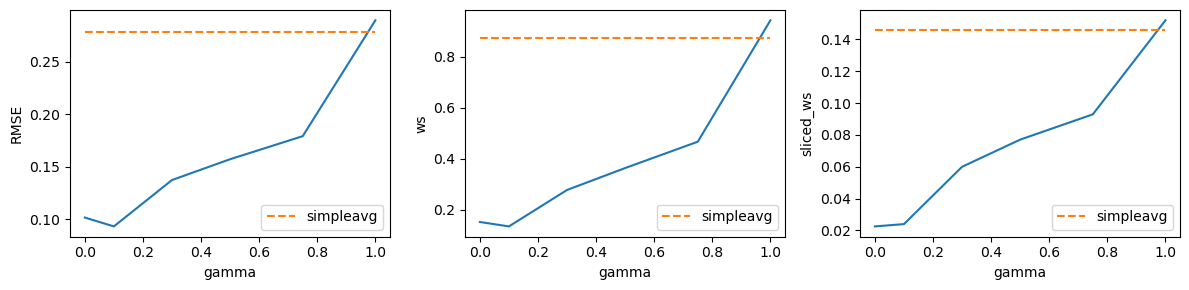

In [25]:
x = [0.0, 0.1, 0.3, 0.5, 0.75, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_gamma]
y_ws = [r['imp_result']['imp@ws'] for r in results_gamma]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_gamma]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('gamma')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

rmse = 0.27822271001114046
ws = 0.8747674771979429
sliced_ws = 0.14578667183696412
ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()



#### split tune mm_thres

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 13:44:06.794 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:44:06.794 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 13:44:40.851 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:44:40.852 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 13:45:13.141 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:45:13.142 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 13:45:47.664 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:45:47.664 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

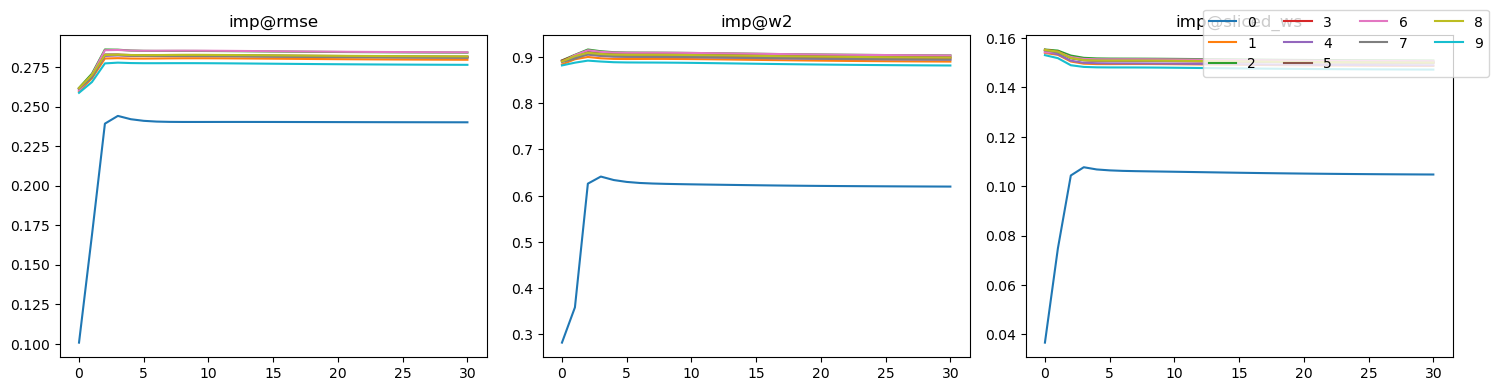

{'imp@rmse': 0.27713041632993135, 'imp@ws': 0.8684786159328058, 'imp@sliced_ws': 0.14510666631558106}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 13:46:06.726 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:46:06.726 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 13:46:38.239 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:46:38.240 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 13:47:12.735 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:47:12.736 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 13:47:47.537 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:47:47.538 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

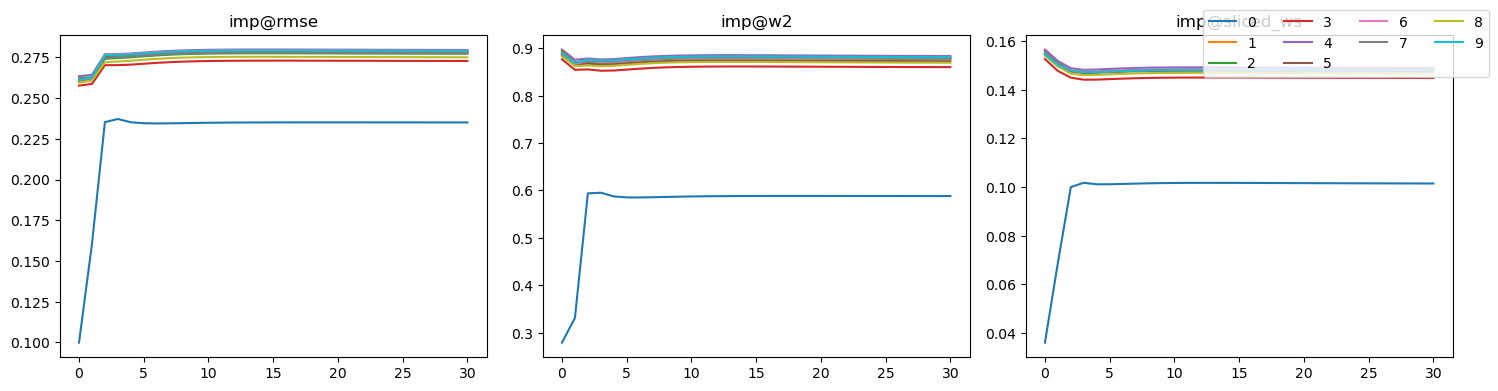

{'imp@rmse': 0.27320645882074024, 'imp@ws': 0.8470375889420972, 'imp@sliced_ws': 0.14289385304266317}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 13:48:06.694 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:48:06.695 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 13:48:39.116 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:48:39.117 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 13:49:14.873 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:49:14.874 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 13:49:51.040 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:49:51.040 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

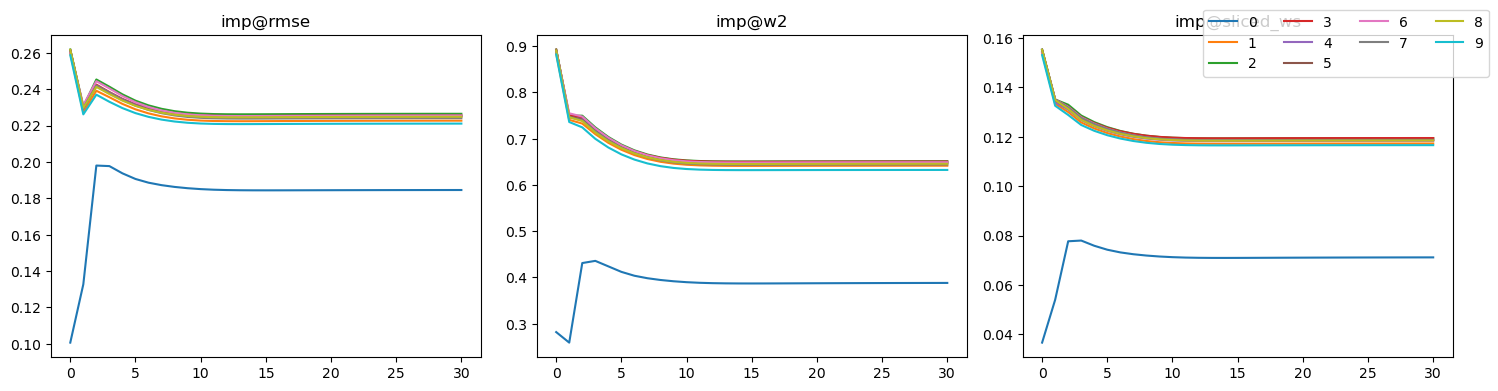

{'imp@rmse': 0.22047896565235298, 'imp@ws': 0.6195479574687783, 'imp@sliced_ws': 0.11366266477554907}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 13:50:09.744 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:50:09.744 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 13:50:42.691 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:50:42.692 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 13:51:17.622 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:51:17.622 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 13:51:50.530 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:51:50.531 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

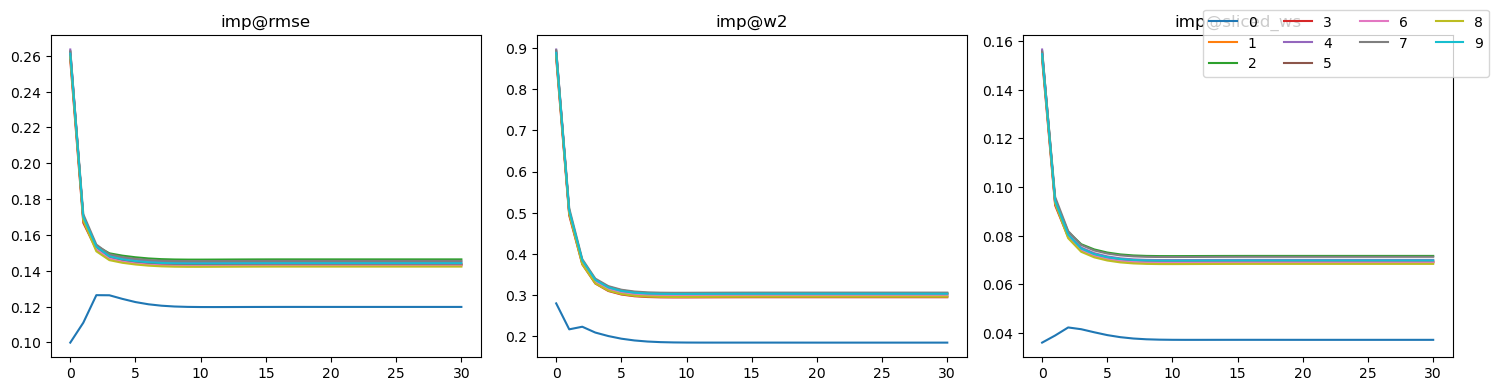

{'imp@rmse': 0.14165634278709577, 'imp@ws': 0.28816536874622034, 'imp@sliced_ws': 0.06654793769923546}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 13:52:07.041 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:52:07.042 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 13:52:36.718 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:52:36.719 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 13:53:10.081 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:53:10.082 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 13:53:43.649 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:53:43.649 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

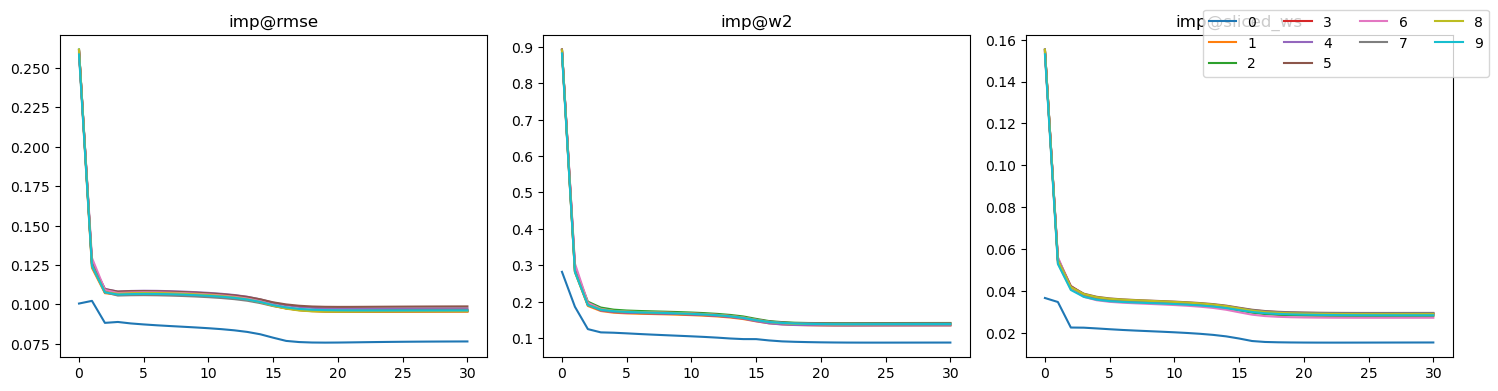

{'imp@rmse': 0.0945024013229102, 'imp@ws': 0.13290748641082953, 'imp@sliced_ws': 0.027325423337201667}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 13:53:59.989 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:53:59.990 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 13:54:29.910 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:54:29.911 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 13:55:03.242 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:55:03.242 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 13:55:36.143 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:55:36.143 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

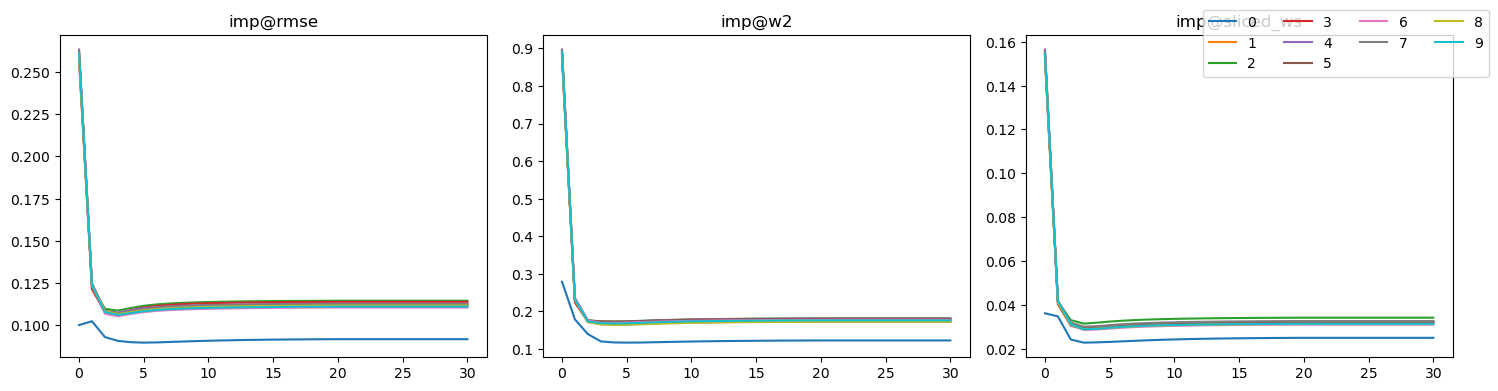

{'imp@rmse': 0.1101158467170725, 'imp@ws': 0.17120595132166128, 'imp@sliced_ws': 0.03131131013284991}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 13:55:52.822 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:55:52.823 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 13:56:22.412 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:56:22.412 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 13:56:55.928 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:56:55.928 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 13:57:29.172 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 13:57:29.173 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

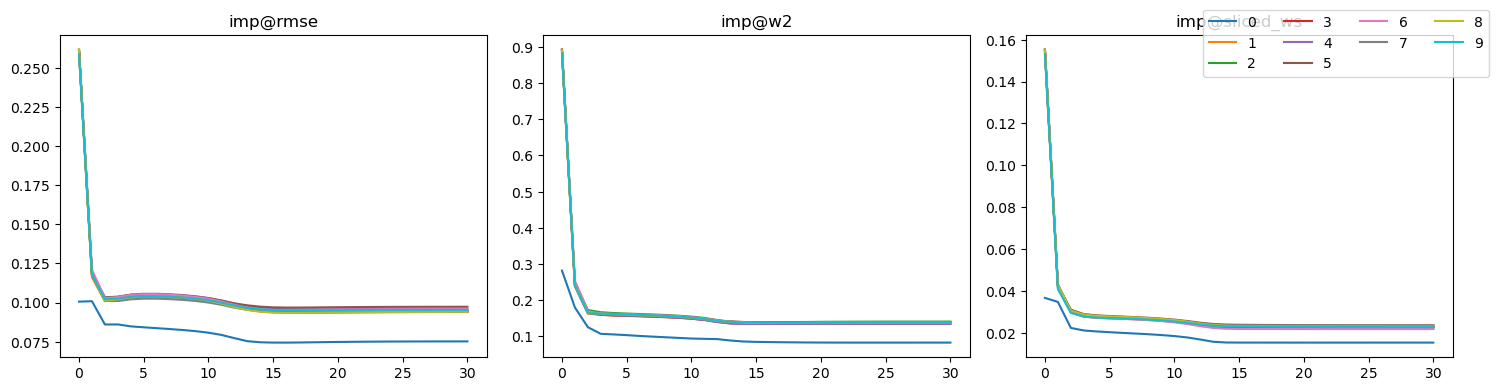

{'imp@rmse': 0.09308890314717941, 'imp@ws': 0.1324015903846414, 'imp@sliced_ws': 0.022037587664549087}


In [27]:
%matplotlib inline
results_mmthres = []
for mm_thres in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = mr_strategy
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
    config2['data_partition']['strategy'] = 'sample-evenly'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
        "alpha": mm_thres,
        "gamma": 0.05,
        "client_thres": 1.0,
        "scale_factor": 4
    }

    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed, vis = True)
    results_mmthres.append(ret.copy())

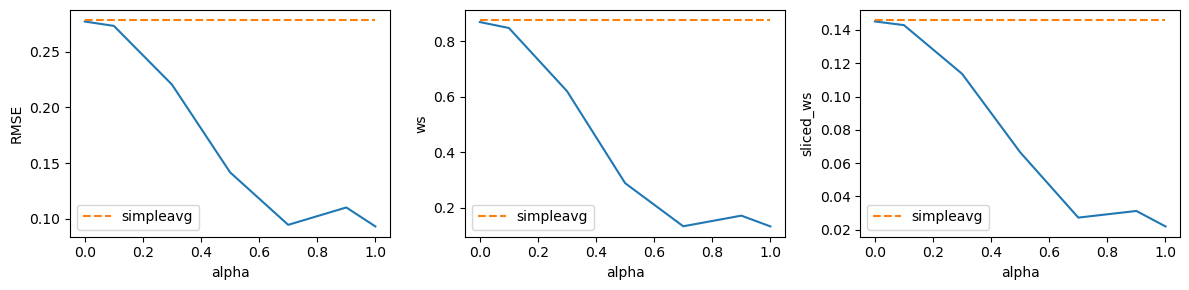

In [28]:
x = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_mmthres]
y_ws = [r['imp_result']['imp@ws'] for r in results_mmthres]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_mmthres]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

rmse = 0.27822271001114046
ws = 0.8747674771979429
sliced_ws = 0.14578667183696412
ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.tight_layout()
plt.show()


#### Split tune scale

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 11:59:45.261 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 11:59:45.261 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 12:00:19.438 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:00:19.438 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 12:00:52.742 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:00:52.743 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 12:01:25.815 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:01:25.816 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

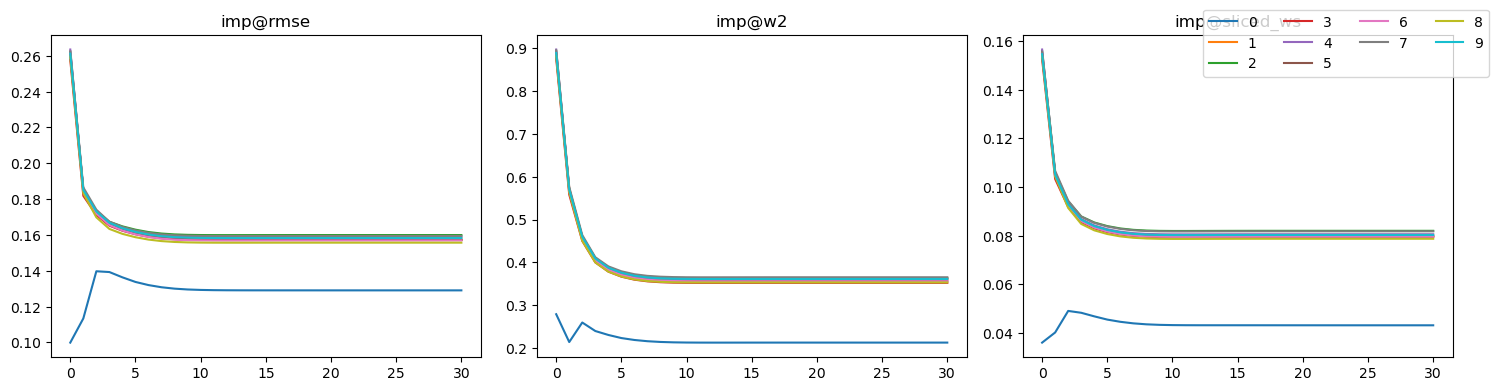

{'imp@rmse': 0.15500891376869563, 'imp@ws': 0.34417097864458207, 'imp@sliced_ws': 0.07654952355643688}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 12:01:42.509 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:01:42.510 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 12:02:12.505 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:02:12.506 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 12:02:45.965 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:02:45.966 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 12:03:19.317 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:03:19.318 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

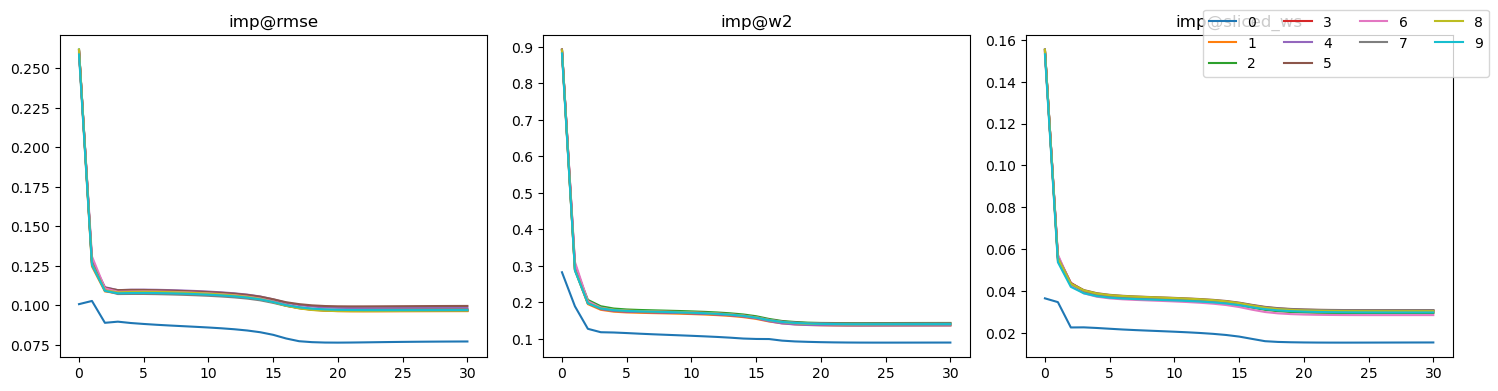

{'imp@rmse': 0.09514216469880071, 'imp@ws': 0.13430436648340718, 'imp@sliced_ws': 0.02872524008156887}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 12:03:35.636 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:03:35.637 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 12:04:05.635 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:04:05.635 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 12:04:38.820 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:04:38.821 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 12:05:11.769 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:05:11.770 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

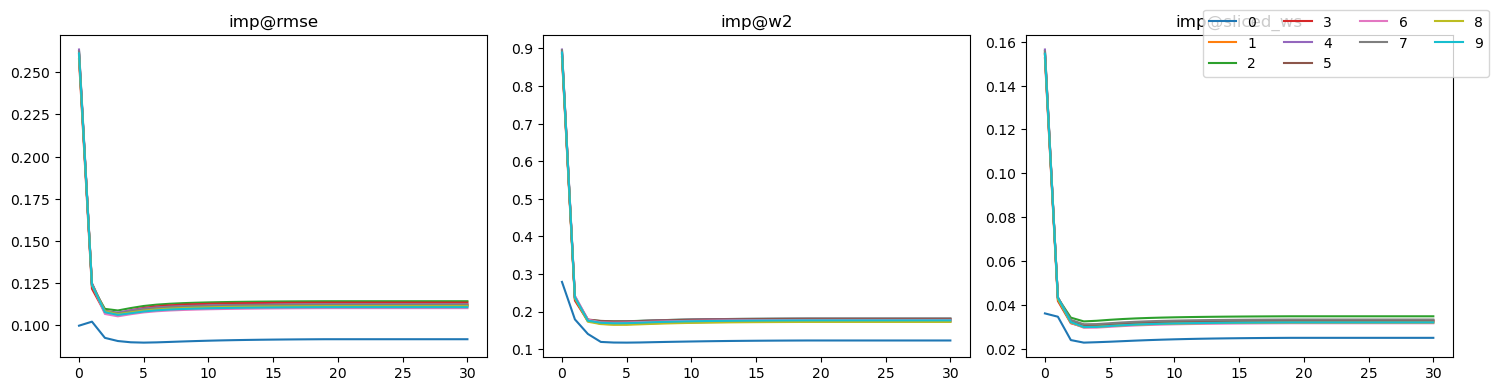

{'imp@rmse': 0.11012112537113895, 'imp@ws': 0.17165234233092652, 'imp@sliced_ws': 0.031944491900937136}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 12:05:28.144 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:05:28.145 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 12:05:58.396 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:05:58.396 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 12:06:31.907 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:06:31.908 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 12:07:05.325 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 12:07:05.325 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

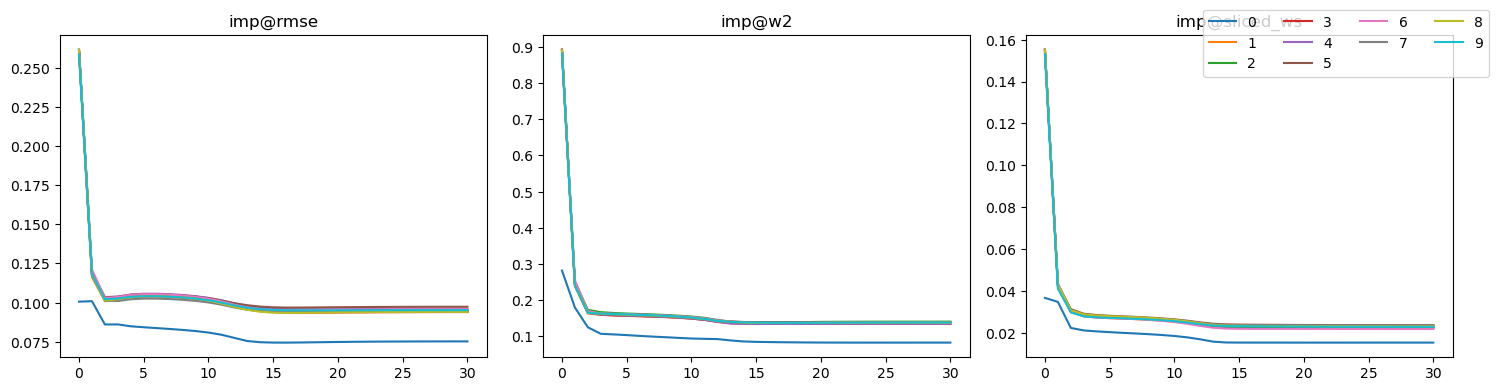

{'imp@rmse': 0.09309045265223205, 'imp@ws': 0.13234159443392743, 'imp@sliced_ws': 0.022096795315983978}


In [22]:
%matplotlib inline
results_scale = []
for scale in [1, 2, 3, 4]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = mr_strategy
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
    config2['data_partition']['strategy'] = 'sample-evenly'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
        "alpha": 0.9,
        "gamma": 0.05,
        "client_thres": 1.0,
        "scale_factor": scale
    }

    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed, vis = True)
    results_scale.append(ret.copy())

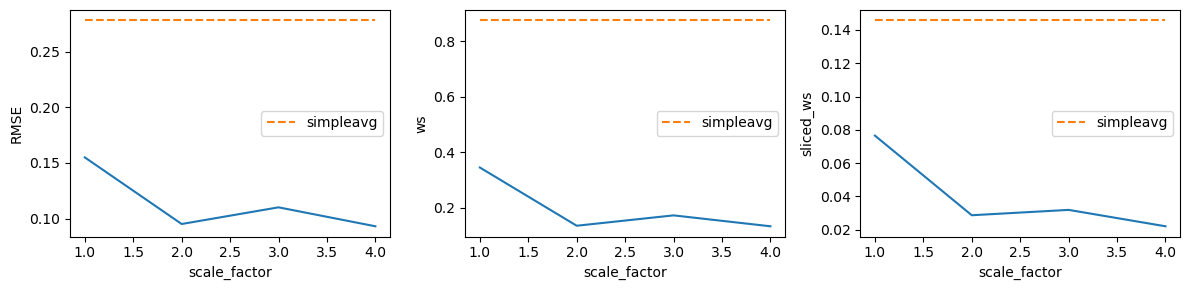

In [24]:
x = [1, 2, 3, 4]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_scale]
y_ws = [r['imp_result']['imp@ws'] for r in results_scale]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_scale]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('scale_factor')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

rmse = 0.27822271001114046
ws = 0.8747674771979429
sliced_ws = 0.14578667183696412
ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.tight_layout()
plt.show()


## Clients MNAR 10 clients no complementary

### Simple average

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 14:19:34.039 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:19:34.040 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 14:20:02.169 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:20:02.169 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 14:20:33.622 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:20:33.622 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 14:21:04.846 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:21:04.847 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

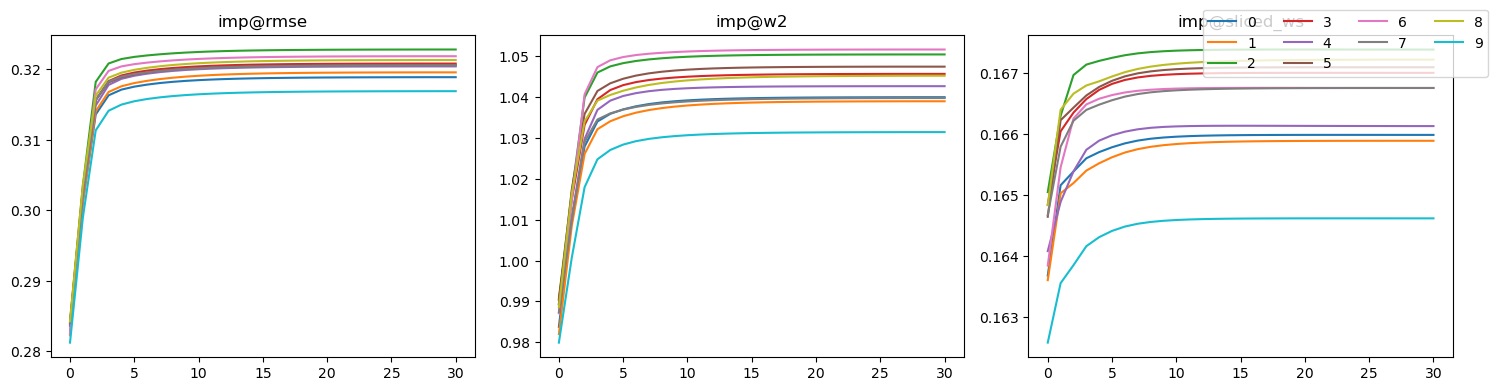

2023-10-23 14:21:08.397 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.6615, test_f1: 0.0000 test_auroc: 0.8121 test_auprc: 0.6550 train_loss: 0.6635 val_accu: 0.6611 val_f1: 0.3980


{'imp@rmse': 0.3203709029265051, 'imp@ws': 1.0432949251070116, 'imp@sliced_ws': 0.16648186204515494}


2023-10-23 14:21:18.696 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 100, test_accu: 0.5630, test_f1: 0.4005 test_auroc: 0.4609 test_auprc: 0.4544 train_loss: 0.5068 val_accu: 0.7678 val_f1: 0.6861
2023-10-23 14:21:28.816 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 200, test_accu: 0.2810, test_f1: 0.4107 test_auroc: 0.3819 test_auprc: 0.3018 train_loss: 0.4625 val_accu: 0.7883 val_f1: 0.7234
2023-10-23 14:21:39.532 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 300, test_accu: 0.3020, test_f1: 0.4344 test_auroc: 0.4073 test_auprc: 0.3074 train_loss: 0.4490 val_accu: 0.7917 val_f1: 0.7344
2023-10-23 14:21:50.175 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 400, test_accu: 0.3100, test_f1: 0.4404 test_auroc: 0.4237 test_auprc: 0.3118 train_loss: 0.4417 val_accu: 0.7981 val_f1: 0.7434


0.715 0.46005620232838224 0.8121196287476093 0.6550314694057194


In [33]:
name = 'mnar_lr_codrna_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.0'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

### Complementary

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-12 12:50:58.710 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:50:58.711 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 12:51:27.699 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:51:27.700 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 12:51:59.828 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:51:59.829 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 12:52:03.095 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.90603429998737


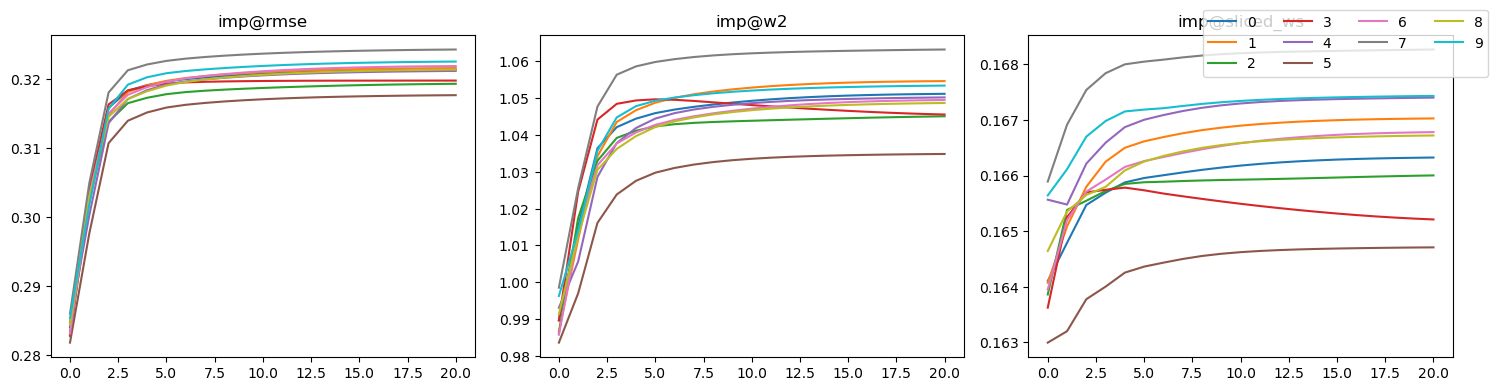

2023-10-12 12:52:03.526 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.6685, test_f1: 0.0000 test_auroc: 0.7770 test_auprc: 0.6000 train_loss: 0.6626 val_accu: 0.6694 val_f1: 0.4010


{'imp@rmse': 0.32108221061148867, 'imp@ws': 1.0495496076525759, 'imp@sliced_ws': 0.16658073680649604}


2023-10-12 12:52:13.912 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 100, test_accu: 0.4350, test_f1: 0.3430 test_auroc: 0.3934 test_auprc: 0.3176 train_loss: 0.5014 val_accu: 0.7739 val_f1: 0.6868
2023-10-12 12:52:24.251 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 200, test_accu: 0.2620, test_f1: 0.3740 test_auroc: 0.3831 test_auprc: 0.2975 train_loss: 0.4710 val_accu: 0.7881 val_f1: 0.7204
2023-10-12 12:52:34.763 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 300, test_accu: 0.2800, test_f1: 0.3872 test_auroc: 0.3962 test_auprc: 0.3014 train_loss: 0.4625 val_accu: 0.7942 val_f1: 0.7269
2023-10-12 12:52:45.220 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 400, test_accu: 0.3105, test_f1: 0.3949 test_auroc: 0.4220 test_auprc: 0.3087 train_loss: 0.4685 val_accu: 0.7925 val_f1: 0.7207


0.704 0.4253666954270923 0.8219438399604707 0.6709654928817823


In [41]:
name = 'mnar_lr_codrna_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.0'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

### Complementary Split

#### Tune Gamma

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 12:53:09.138 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:53:09.139 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 12:53:37.981 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:53:37.982 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 12:54:10.269 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:54:10.270 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 12:54:13.481 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.81537710000703


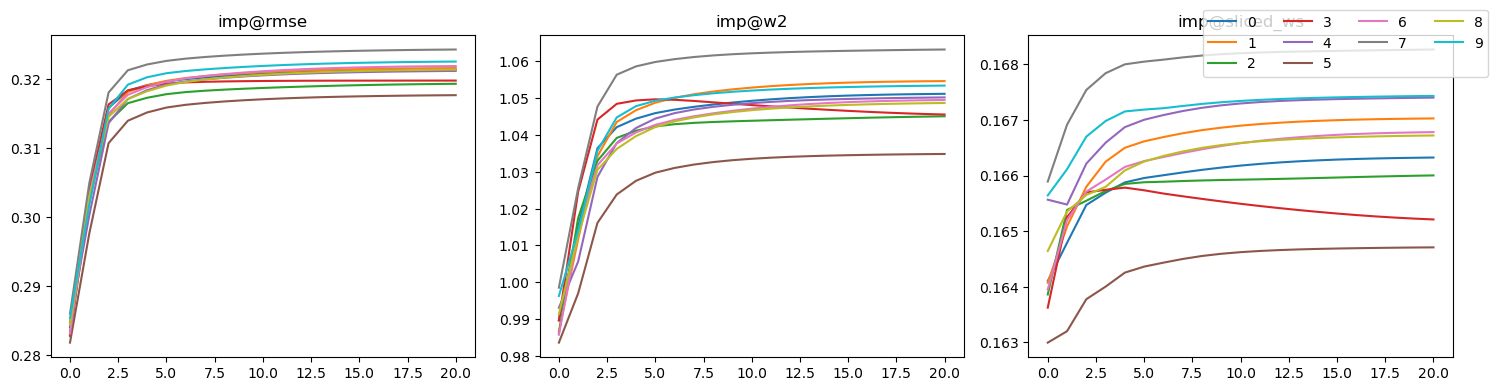

{'imp@rmse': 0.321082210611491, 'imp@ws': 1.0495496076525885, 'imp@sliced_ws': 0.1665807368064966}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 12:54:26.763 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:54:26.763 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 12:54:55.515 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:54:55.515 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 12:55:27.445 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:55:27.446 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 12:55:30.676 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.429200700004


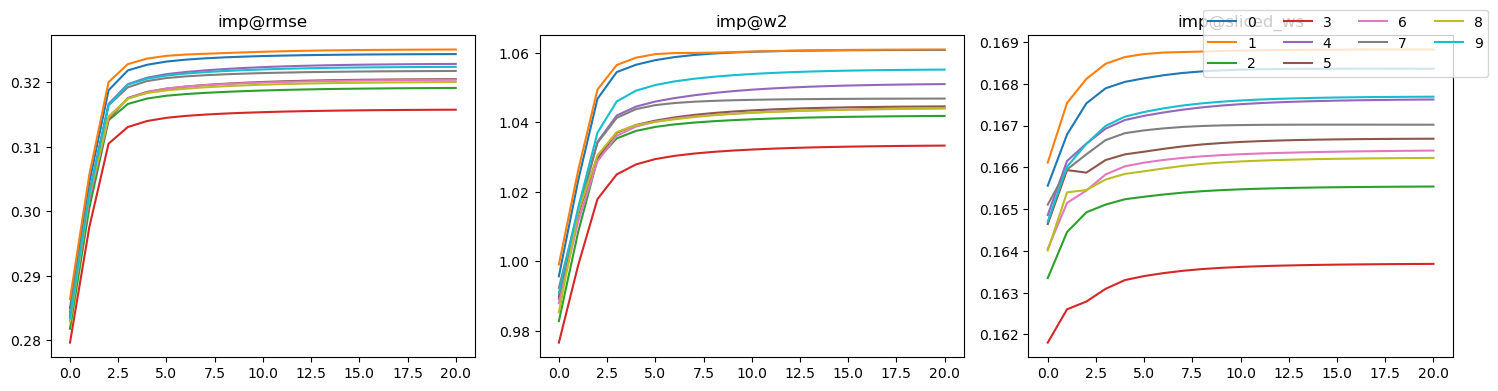

{'imp@rmse': 0.32121327593625554, 'imp@ws': 1.0481968571923064, 'imp@sliced_ws': 0.166800016671648}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 12:55:43.961 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:55:43.962 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 12:56:12.968 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:56:12.969 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 12:56:45.075 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:56:45.076 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 12:56:48.293 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.83628930000123


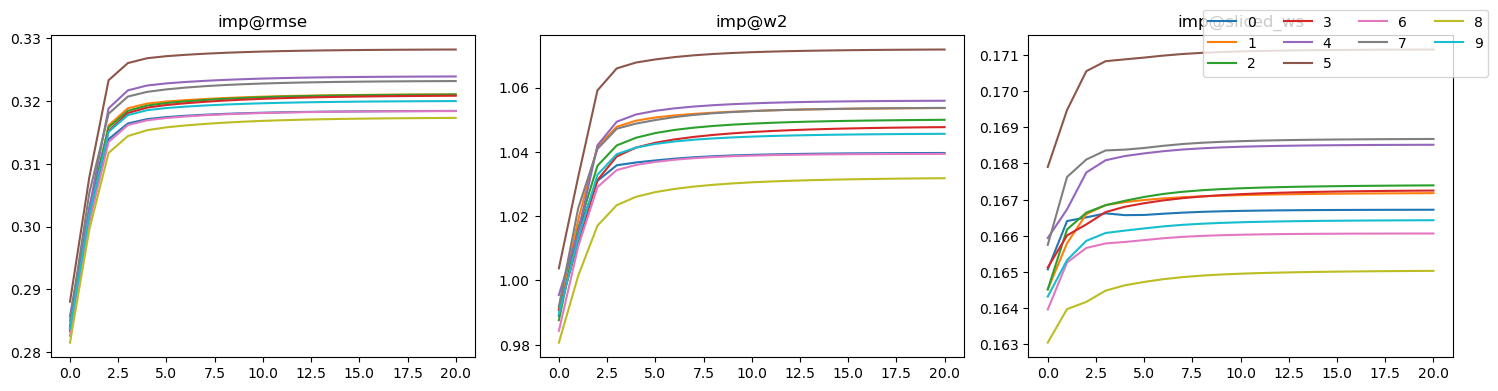

{'imp@rmse': 0.321226932885492, 'imp@ws': 1.0488273044963796, 'imp@sliced_ws': 0.16743384614497456}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 12:57:01.665 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:57:01.666 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 12:57:30.495 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:57:30.496 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 12:58:02.559 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:58:02.559 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 12:58:05.810 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.64957779999531


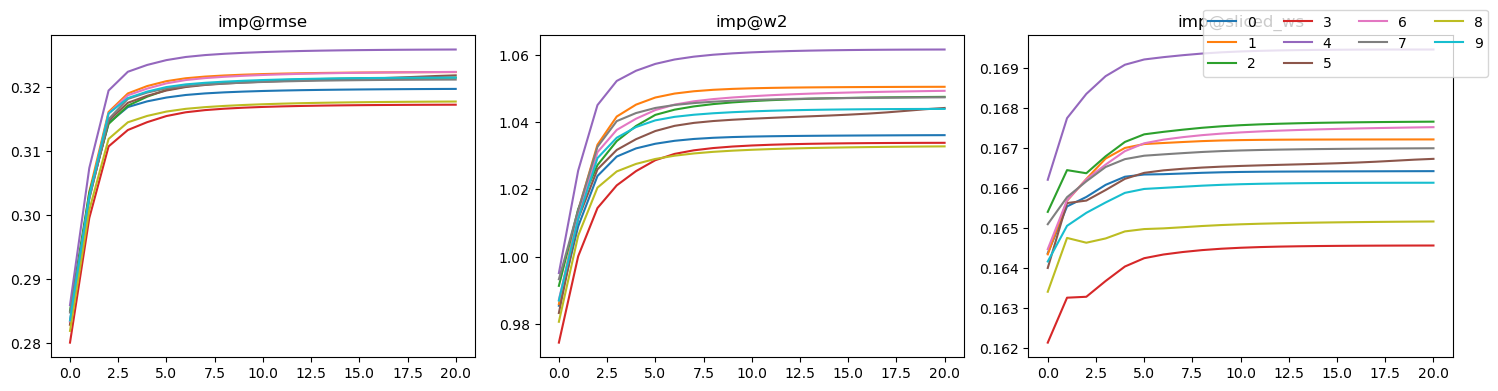

{'imp@rmse': 0.32106142026887796, 'imp@ws': 1.0445303278931817, 'imp@sliced_ws': 0.16678046354362303}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 12:58:19.163 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:58:19.163 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 12:58:47.934 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:58:47.934 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 12:59:19.984 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:59:19.984 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 12:59:23.218 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.5573124000075


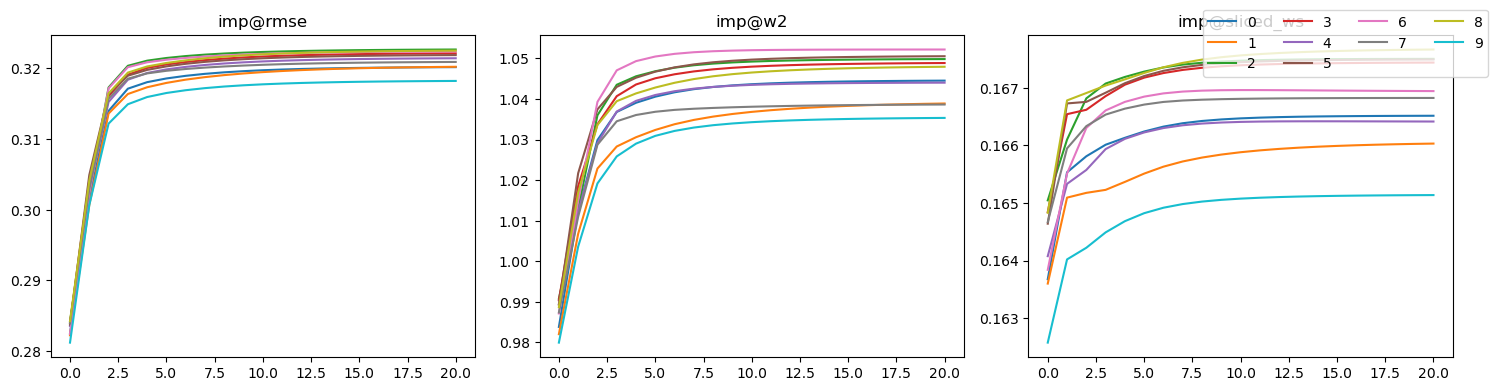

{'imp@rmse': 0.3211860042214183, 'imp@ws': 1.04499361656501, 'imp@sliced_ws': 0.1667931966774869}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 12:59:36.608 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 12:59:36.609 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 13:00:05.341 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:00:05.342 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 13:00:37.542 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:00:37.542 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 13:00:40.749 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.63509229999909


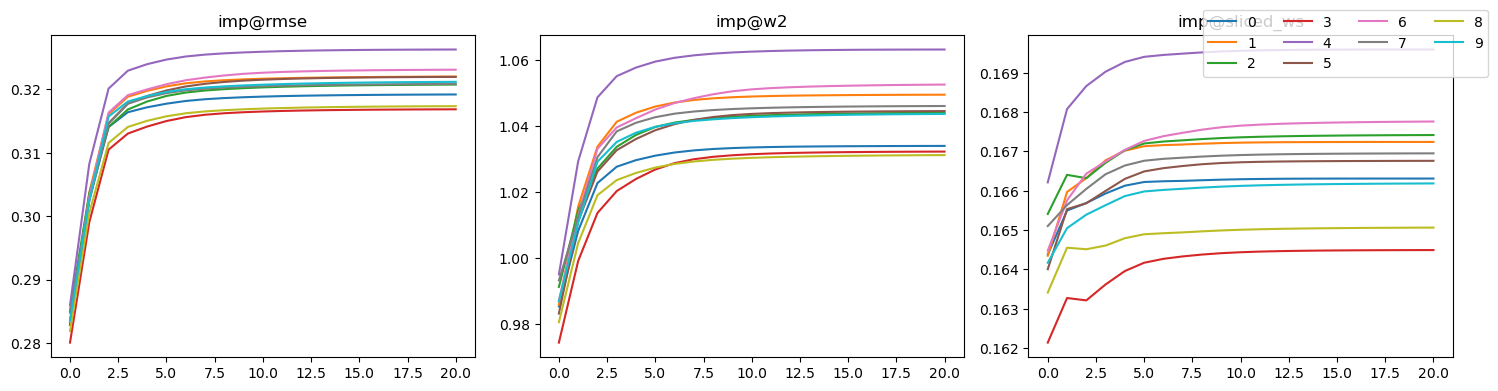

{'imp@rmse': 0.3209064041664353, 'imp@ws': 1.044060863754534, 'imp@sliced_ws': 0.166770528306128}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 13:00:54.008 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:00:54.008 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 13:01:22.820 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:01:22.821 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 13:01:54.925 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:01:54.926 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 13:01:58.163 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.64729680000164


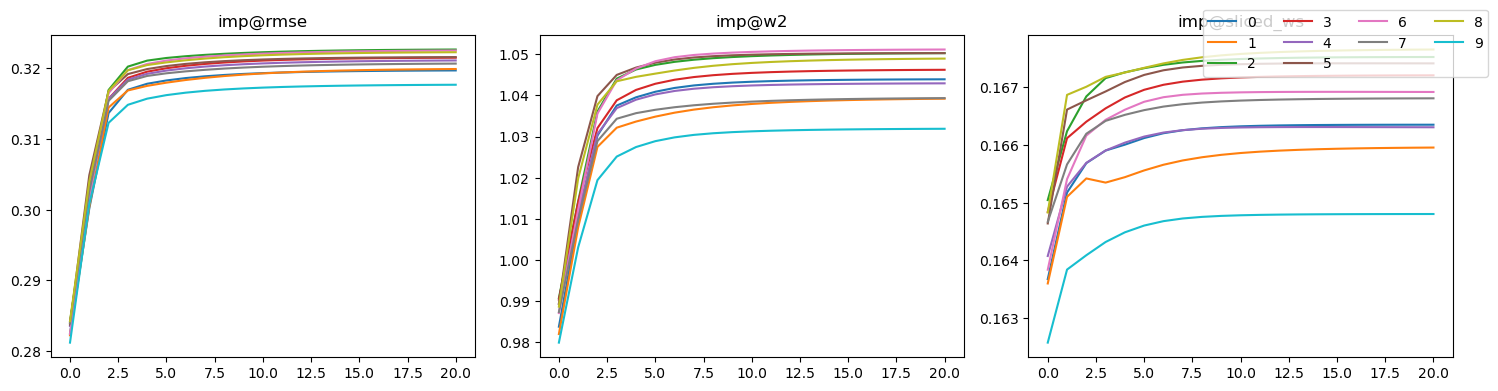

{'imp@rmse': 0.32094541386037995, 'imp@ws': 1.0443444225968697, 'imp@sliced_ws': 0.1666934258204128}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 13:02:11.572 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:02:11.572 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 13:02:40.518 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:02:40.519 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 13:03:12.538 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:03:12.538 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 13:03:15.795 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.71739429999434


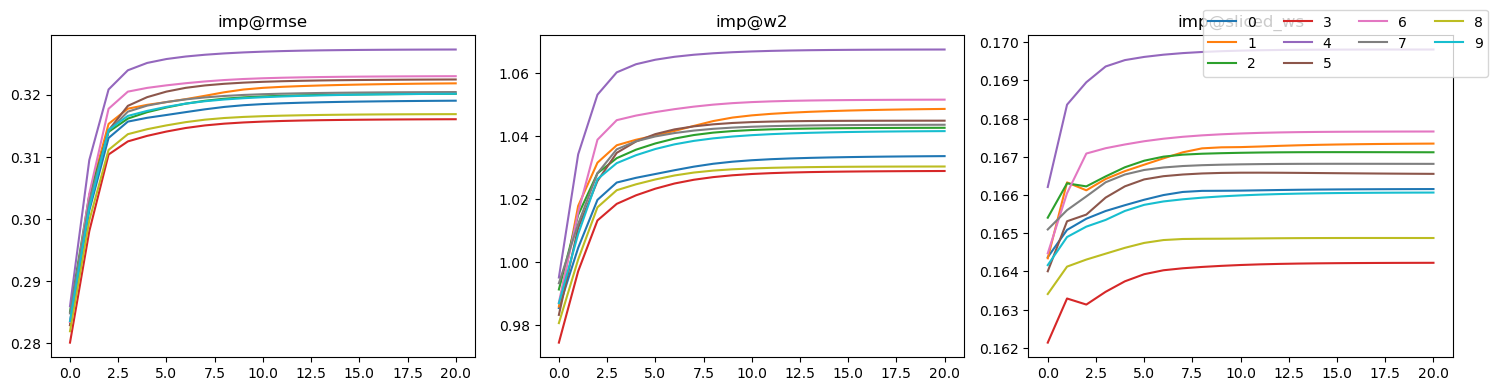

{'imp@rmse': 0.320659628421713, 'imp@ws': 1.0432540159208272, 'imp@sliced_ws': 0.16666158391890368}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 13:03:29.211 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:03:29.211 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 13:03:58.118 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:03:58.119 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 13:04:30.306 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:04:30.307 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 13:04:33.558 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.85249320000003


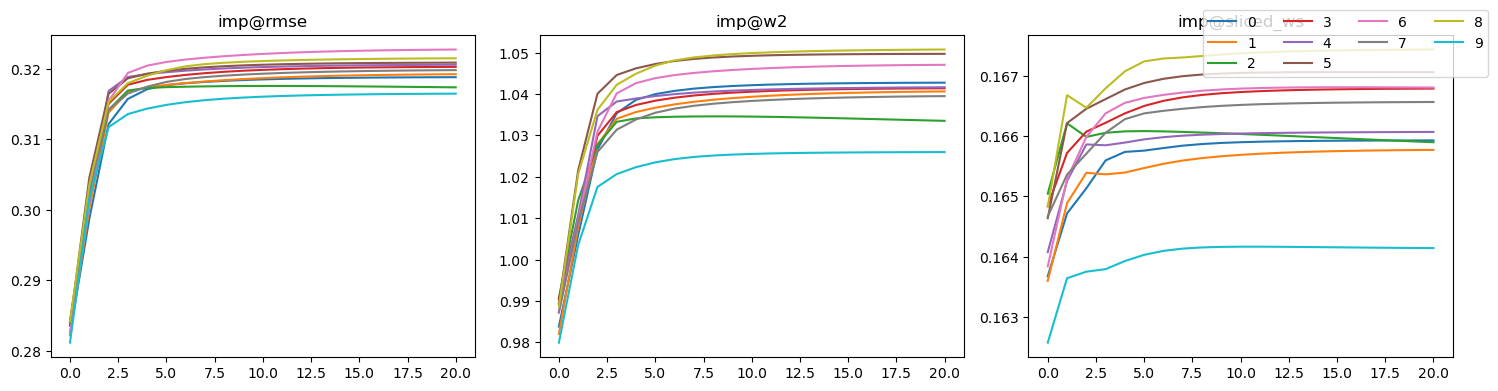

{'imp@rmse': 0.3197210141700432, 'imp@ws': 1.0412578642747092, 'imp@sliced_ws': 0.16624946130024157}


In [42]:
%matplotlib inline
results = []
for gamma in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = mr_strategy
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.0'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
        "alpha": 1.0,
        "gamma": gamma,
        "client_thres": 1.0,
        "scale_factor": 4
    }

    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed, vis = True)
    results.append(ret.copy())

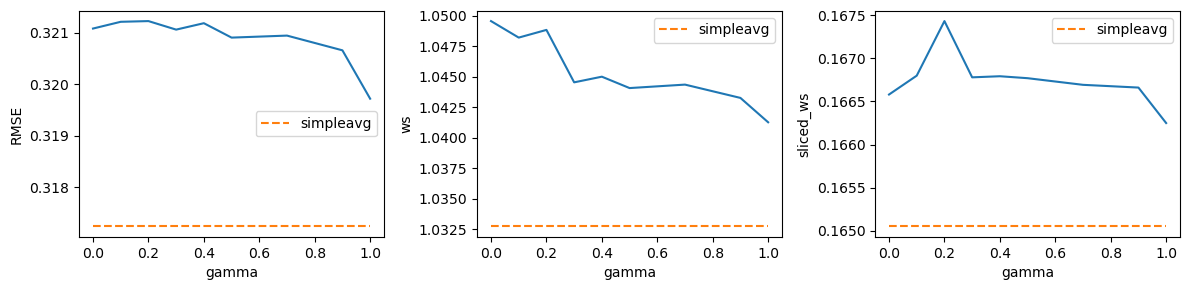

In [43]:
x = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results]
y_ws = [r['imp_result']['imp@ws'] for r in results]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('gamma')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

rmse = 0.31724148632788224
ws = 1.0327202461435718
sliced_ws = 0.1650482253637849
ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

#### Tune alpha

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 13:04:47.107 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:04:47.108 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 13:05:15.972 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:05:15.972 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 13:05:47.965 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:05:47.965 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 13:05:51.196 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.57844409999961


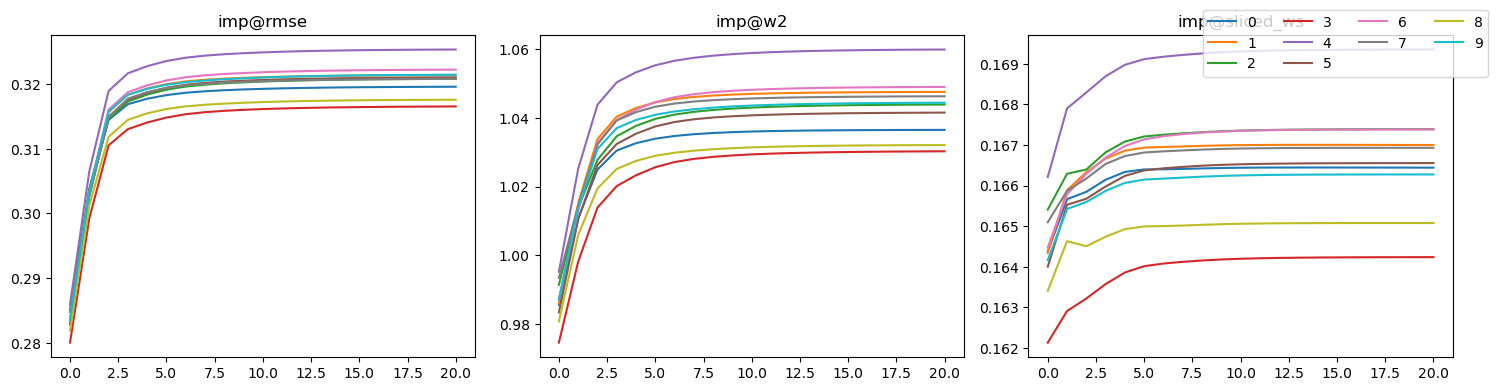

{'imp@rmse': 0.32061416460165526, 'imp@ws': 1.0431099721684856, 'imp@sliced_ws': 0.16666102926989015}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 13:06:04.542 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:06:04.542 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 13:06:33.355 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:06:33.355 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 13:07:05.374 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:07:05.375 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 13:07:08.562 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.50586540000222


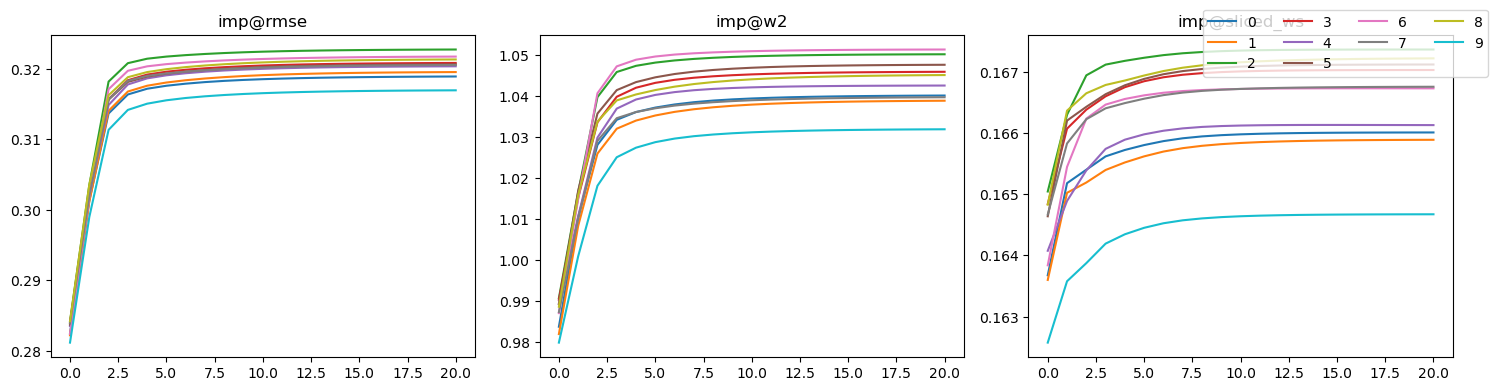

{'imp@rmse': 0.3203258852749493, 'imp@ws': 1.043266476264173, 'imp@sliced_ws': 0.16649240287569012}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 13:07:21.858 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:07:21.859 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 13:07:50.584 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:07:50.585 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 13:08:22.408 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:08:22.409 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 13:08:25.602 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.234655200009


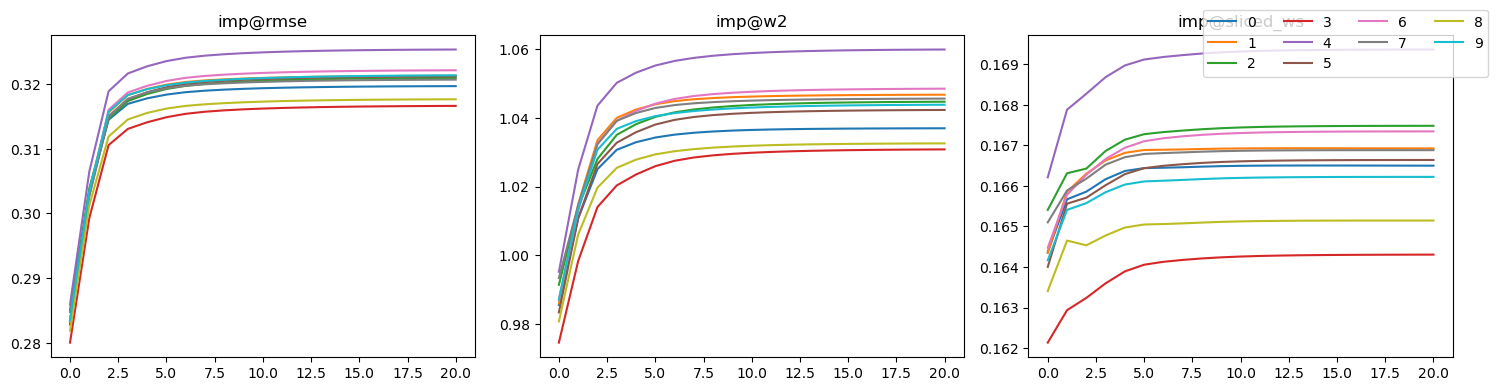

{'imp@rmse': 0.3206196274558809, 'imp@ws': 1.043168127682953, 'imp@sliced_ws': 0.16667780393292442}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 13:08:39.141 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:08:39.142 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 13:09:07.888 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:09:07.888 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 13:09:39.881 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:09:39.881 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 13:09:43.104 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.4499441999942


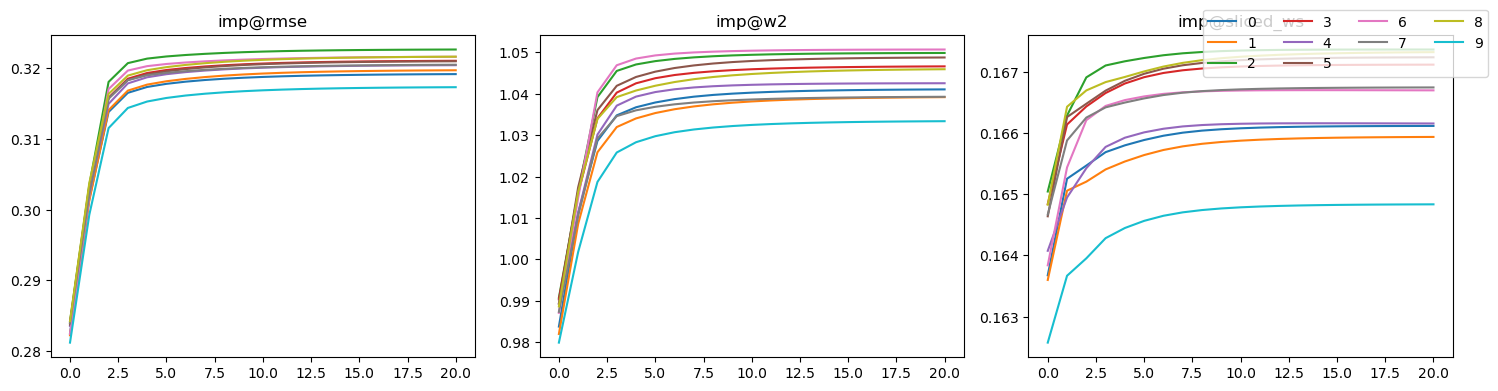

{'imp@rmse': 0.32044766055244106, 'imp@ws': 1.0436560177142324, 'imp@sliced_ws': 0.16655311687337648}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 13:09:56.366 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:09:56.367 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 13:10:25.188 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:10:25.189 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 13:10:57.179 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:10:57.180 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 13:11:00.406 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.5113868000044


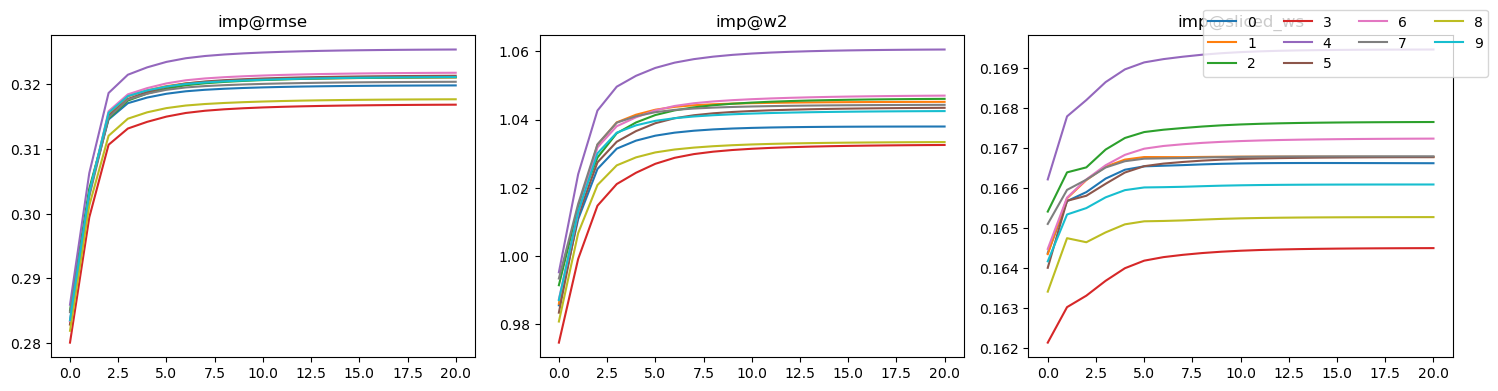

{'imp@rmse': 0.3206324620842138, 'imp@ws': 1.0432336599215402, 'imp@sliced_ws': 0.1667084549568766}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-12 13:11:13.728 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:11:13.728 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-12 13:11:42.605 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:11:42.606 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-12 13:12:14.630 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-12 13:12:14.631 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-12 13:12:17.839 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.59242469999299


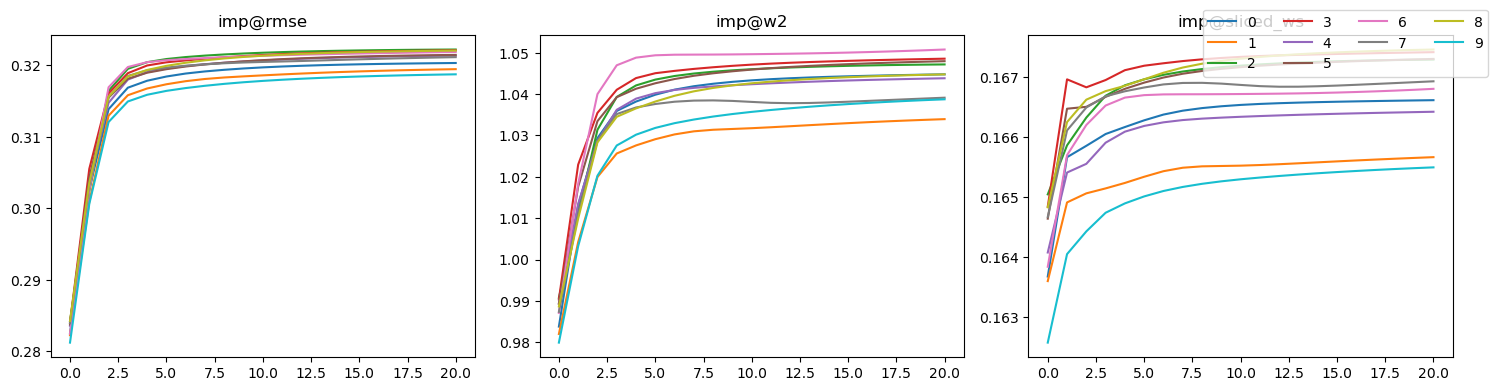

{'imp@rmse': 0.32099619830077236, 'imp@ws': 1.0436679311748367, 'imp@sliced_ws': 0.16672062770816395}


In [44]:
%matplotlib inline
results_alpha2 = []
for alpha in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = mr_strategy
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.0'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
        "alpha": alpha,
        "gamma": 0.05,
        "client_thres": 1.0,
        "scale_factor": 4
    }

    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed, vis = True)
    results_alpha2.append(ret.copy())

In [31]:
x = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_alpha2]
y_ws = [r['imp_result']['imp@ws'] for r in results_alpha2]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_alpha2]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

rmse = 0.31724148632788224
ws = 1.0327202461435718
sliced_ws = 0.1650482253637849
ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

NameError: name 'results_alpha2' is not defined

#### Tune Scale

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 14:11:10.385 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:11:10.385 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 14:11:42.702 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:11:42.702 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 14:12:14.341 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:12:14.342 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 14:12:46.061 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:12:46.062 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

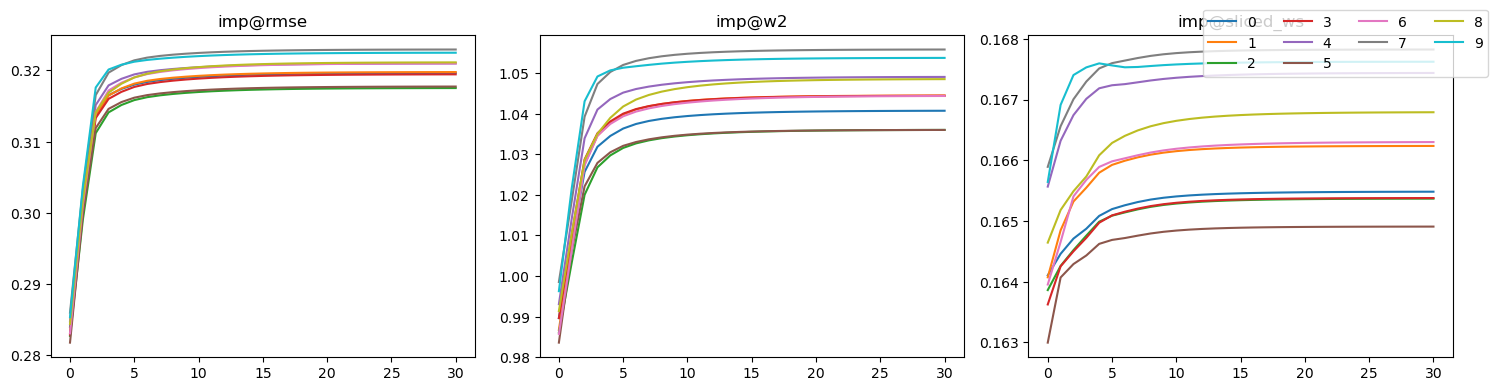

{'imp@rmse': 0.32025780557953937, 'imp@ws': 1.0453028734616316, 'imp@sliced_ws': 0.1663331950448753}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 14:13:02.347 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:13:02.347 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 14:13:31.586 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:13:31.587 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 14:14:03.845 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:14:03.846 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 14:14:36.201 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:14:36.202 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

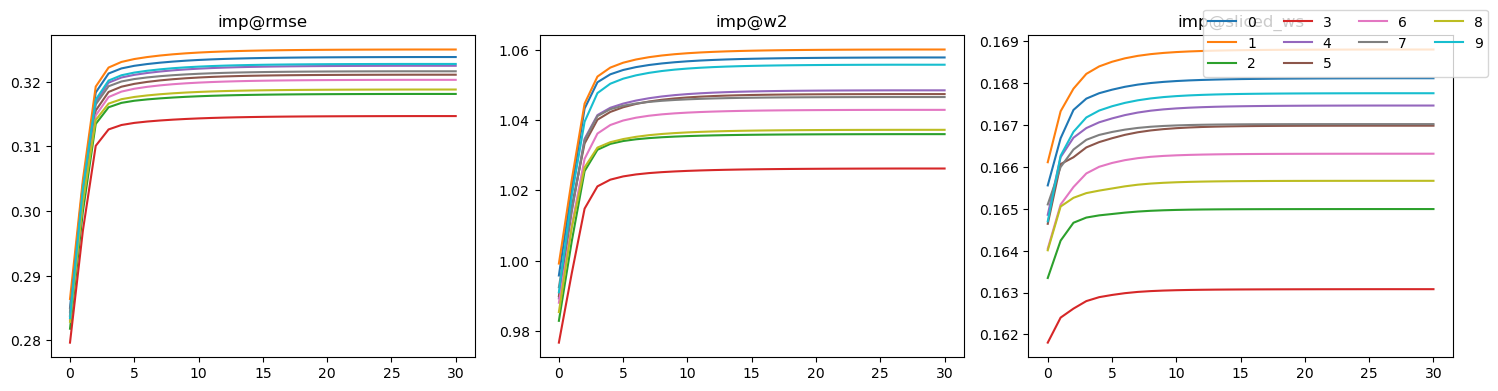

{'imp@rmse': 0.32085068179371534, 'imp@ws': 1.0457987277260803, 'imp@sliced_ws': 0.1666230496320402}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 14:14:52.151 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:14:52.152 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 14:15:20.484 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:15:20.484 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 14:15:52.112 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:15:52.112 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 14:16:23.282 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:16:23.283 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

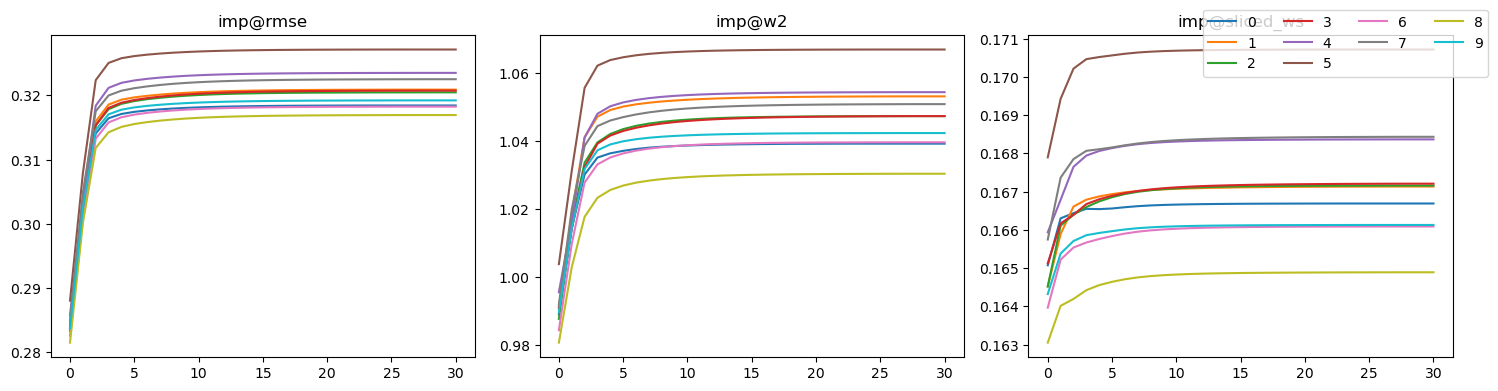

{'imp@rmse': 0.3208203127588983, 'imp@ws': 1.0471399164845878, 'imp@sliced_ws': 0.1672833867937826}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
['mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-23 14:16:39.365 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:16:39.367 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 14:17:07.615 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:17:07.615 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 14:17:39.049 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:17:39.050 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 14:18:10.773 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 14:18:10.774 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 

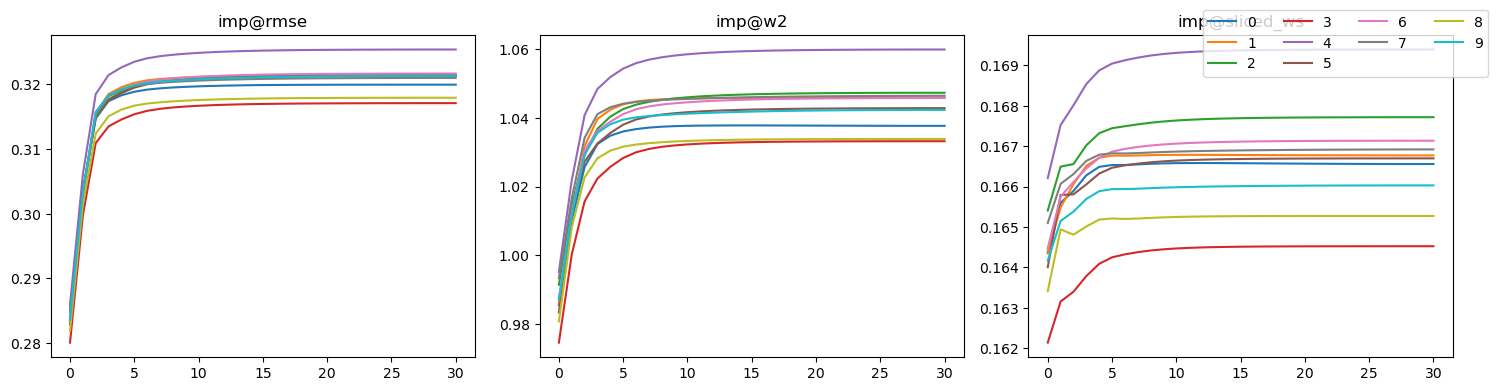

{'imp@rmse': 0.3208205923332532, 'imp@ws': 1.0435342161964871, 'imp@sliced_ws': 0.16670120228304536}


In [30]:
%matplotlib inline
results_scale2 = []
for scale in [1,2,3,4]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = mr_strategy
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.0'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
        "alpha": 0.95,
        "gamma": 0.05,
        "client_thres": 1.0,
        "scale_factor": scale
    }

    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed, vis = True)
    results_scale2.append(ret.copy())

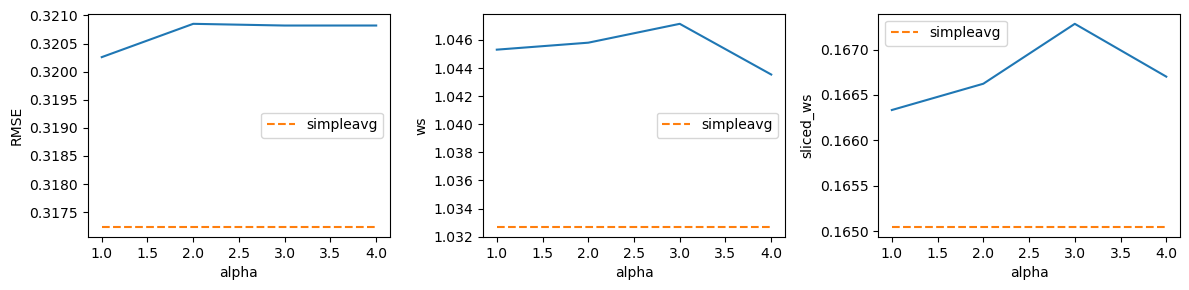

In [32]:
x = [1, 2, 3, 4]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_scale2]
y_ws = [r['imp_result']['imp@ws'] for r in results_scale2]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_scale2]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

rmse = 0.31724148632788224
ws = 1.0327202461435718
sliced_ws = 0.1650482253637849
ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

In [ ]:
ret_arch = rets.copy()
trackers_arch = trackers.copy()

## Subcase1 -  1 vs N Half Split

In [20]:
trackers = {}
rets ={}

#### Simple Average

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-26 10:51:58.537 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:51:58.538 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:52:28.229 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:52:28.230 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:53:00.963 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:53:00.964 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:53:04.265 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 68.34323550004046


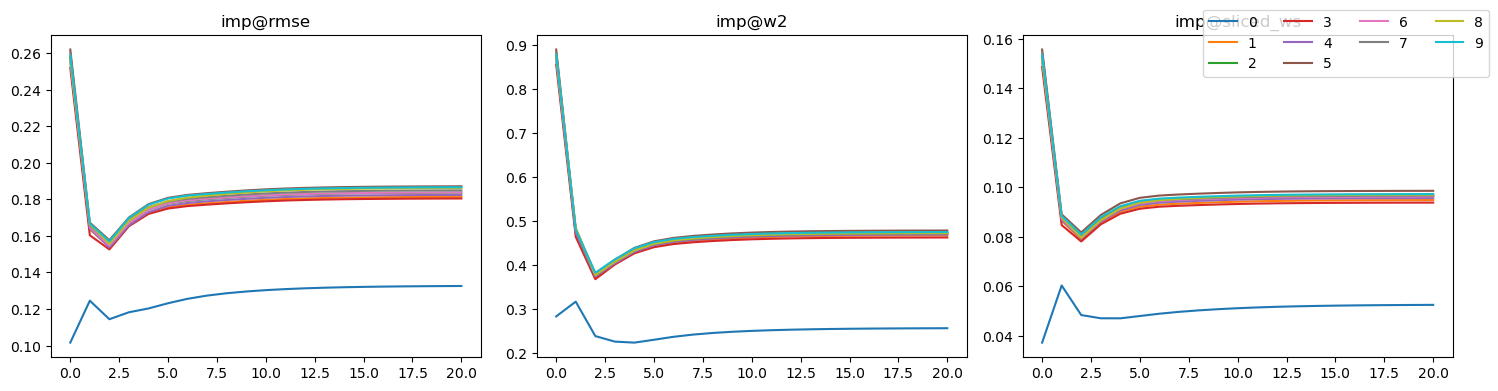

2023-10-26 10:53:04.705 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.6640, test_f1: 0.0000 test_auroc: 0.7822 test_auprc: 0.6410 train_loss: 0.6580 val_accu: 0.6644 val_f1: 0.3992


{'imp@rmse': 0.17884472919516609, 'imp@ws': 0.4496532470292862, 'imp@sliced_ws': 0.09188334255186284}


2023-10-26 10:53:15.184 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 100, test_accu: 0.8855, test_f1: 0.8164 test_auroc: 0.9586 test_auprc: 0.9023 train_loss: 0.4204 val_accu: 0.7917 val_f1: 0.7407
2023-10-26 10:53:26.087 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 200, test_accu: 0.8900, test_f1: 0.8308 test_auroc: 0.9607 test_auprc: 0.9029 train_loss: 0.4007 val_accu: 0.8172 val_f1: 0.7877
2023-10-26 10:53:36.727 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 300, test_accu: 0.8835, test_f1: 0.8175 test_auroc: 0.9593 test_auprc: 0.8992 train_loss: 0.3886 val_accu: 0.8236 val_f1: 0.7893
2023-10-26 10:53:47.492 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 400, test_accu: 0.8795, test_f1: 0.8122 test_auroc: 0.9544 test_auprc: 0.8874 train_loss: 0.3835 val_accu: 0.8247 val_f1: 0.7903


0.907 0.8482871125611746 0.9789582436890418 0.9509058259590106


In [91]:
name = 'mnar_lr_codrna_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'extremel1'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 4500, 4500]
3
[1, 2]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 15:23:16.411 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:23:16.412 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 15:23:52.656 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:23:52.657 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 15:24:27.703 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:24:27.704 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 15:24:31.223 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 77.83522760000778


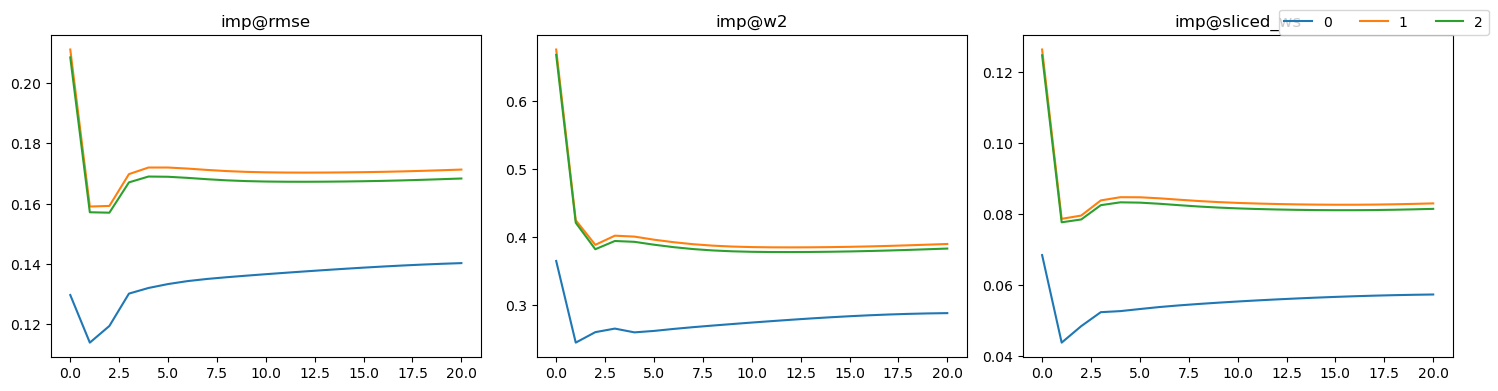

{'imp@rmse': 0.15953427539036463, 'imp@ws': 0.35159530175925635, 'imp@sliced_ws': 0.07377950602302574}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 2250, 2250, 2250, 2250]
5
[1, 4]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 15:24:44.721 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:24:44.722 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 15:25:15.470 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:25:15.471 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 15:25:49.928 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:25:49.929 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 15:25:53.450 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 71.57135459996061


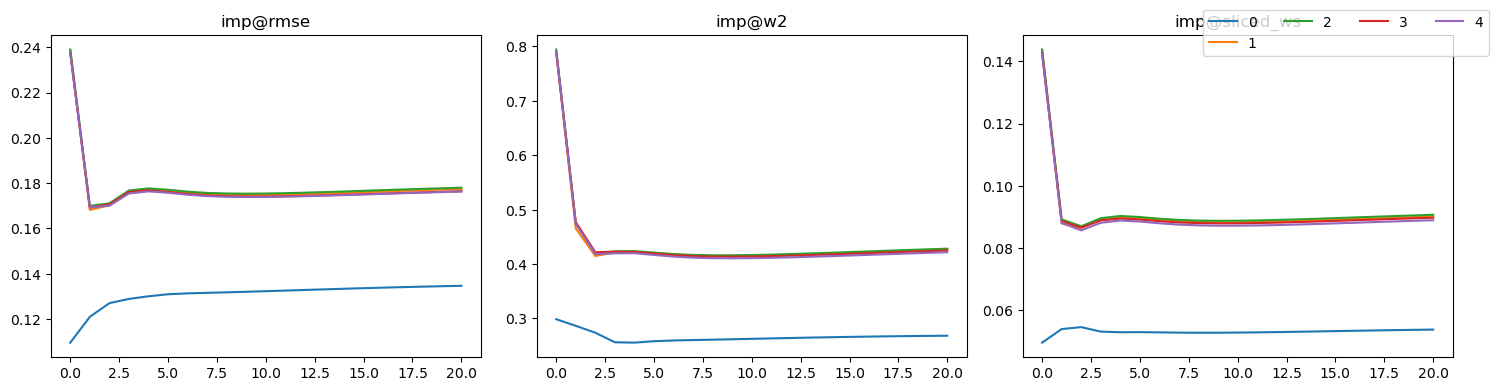

{'imp@rmse': 0.16803751219846957, 'imp@ws': 0.3918758533343798, 'imp@sliced_ws': 0.08221447988022215}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1500, 1500, 1500, 1500, 1500, 1500]
7
[1, 6]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 15:26:07.385 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:26:07.385 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 15:26:39.364 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:26:39.365 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 15:27:14.605 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:27:14.606 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 15:27:18.137 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 73.665924299974


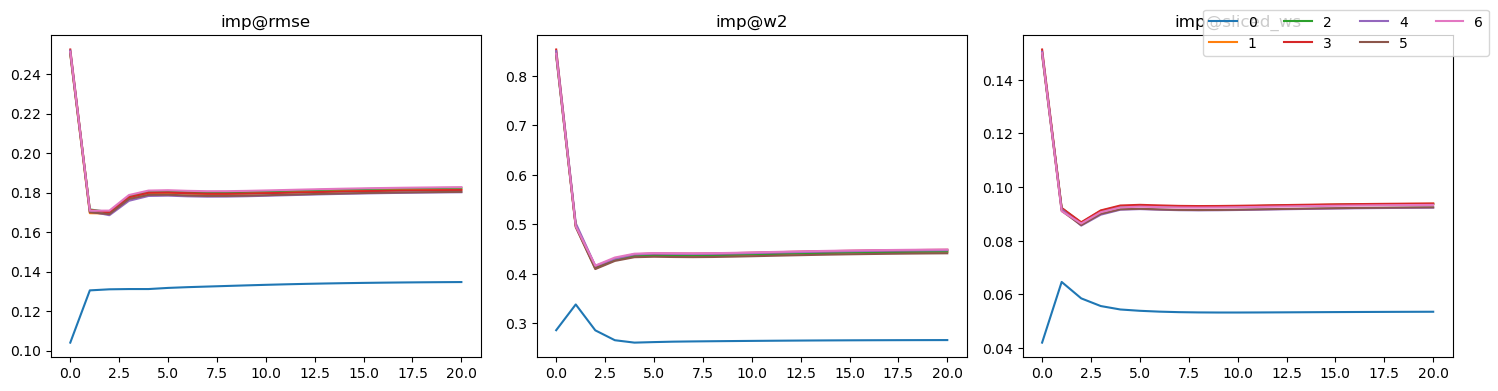

{'imp@rmse': 0.17452662675590266, 'imp@ws': 0.41929712956096926, 'imp@sliced_ws': 0.08741806695629613}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1125, 1125, 1125, 1125, 1125, 1125, 1125, 1125]
9
[1, 8]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 15:27:31.735 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:27:31.736 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 15:28:03.069 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:28:03.069 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 15:28:37.871 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:28:37.872 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 15:28:41.402 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 72.31519410002511


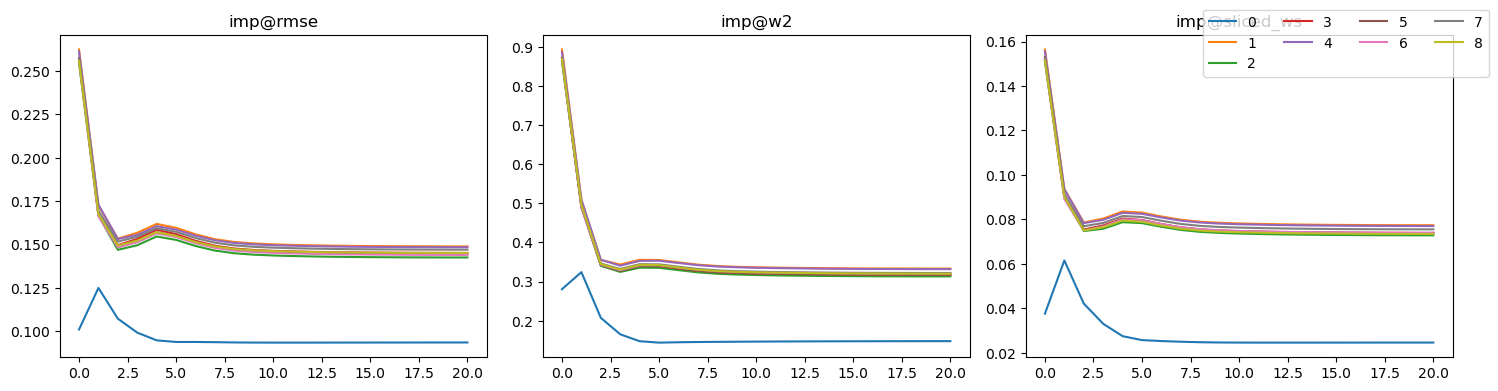

{'imp@rmse': 0.1399569738774729, 'imp@ws': 0.3025454555013624, 'imp@sliced_ws': 0.06919143288963472}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 15:28:54.697 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:28:54.698 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 15:29:25.353 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:29:25.353 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 15:29:59.886 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:29:59.886 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 15:30:03.443 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 71.33895070001017


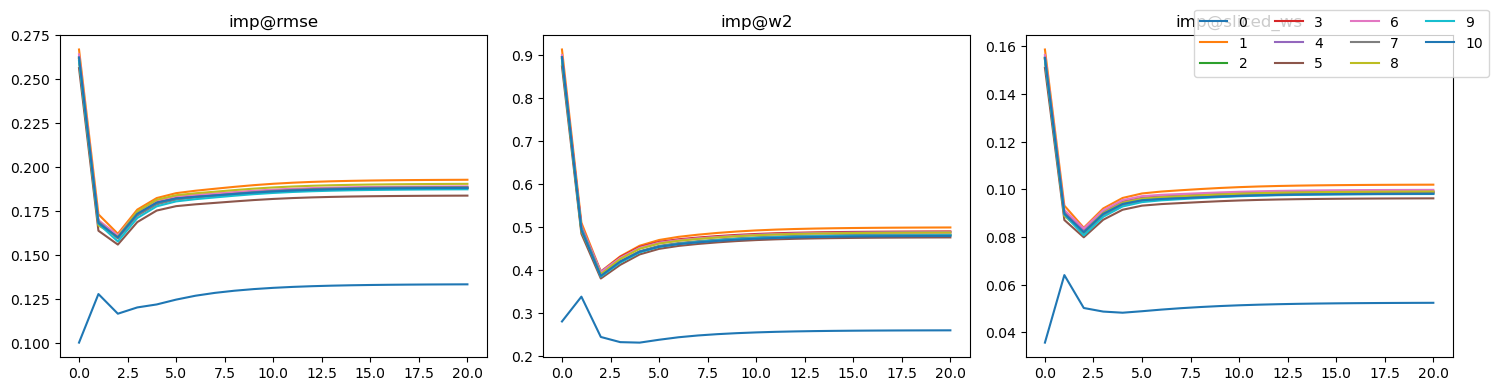

{'imp@rmse': 0.18339719518420747, 'imp@ws': 0.4651955538754767, 'imp@sliced_ws': 0.09457863608702513}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 643, 643, 643, 643, 643, 643, 643, 643, 643, 643, 643, 643, 643, 643]
15
[1, 14]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 15:30:17.135 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:30:17.135 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 15:30:49.103 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:30:49.104 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 15:31:24.835 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:31:24.836 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 15:31:28.387 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 73.85825589997694


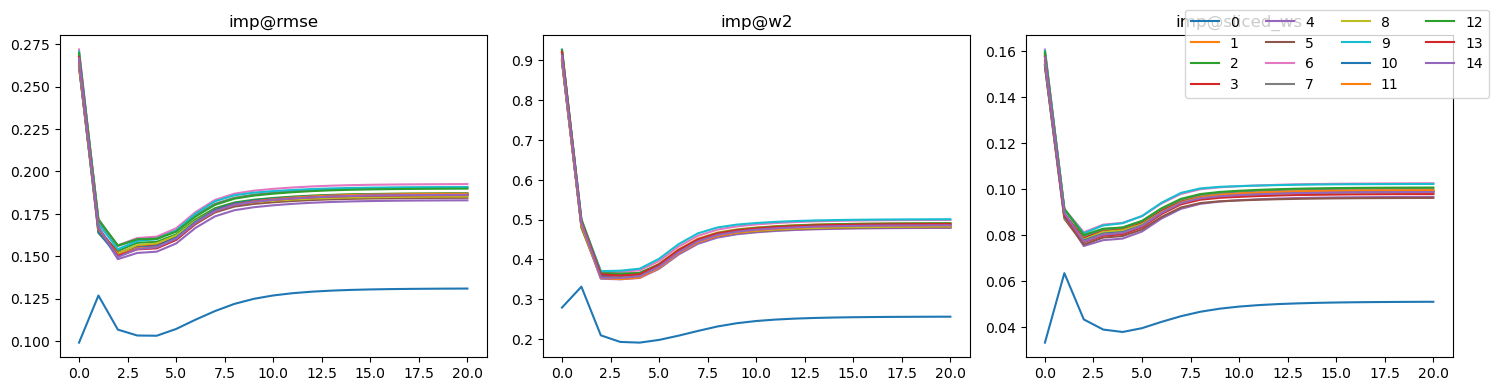

{'imp@rmse': 0.18337290691788596, 'imp@ws': 0.47157649742694246, 'imp@sliced_ws': 0.09571305791448577}


In [23]:
results_avg_ncl = []
for n_client in [3, 5, 7, 9, 11, 15]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = n_client
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
    config2['data_partition']['strategy'] = 'extremel1'

    config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    print(test_data.shape)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_avg_ncl.append(ret.copy())
    # trackers[name] = copy.deepcopy(server.stats_tracker)
    # rets[name] = ret.copy()

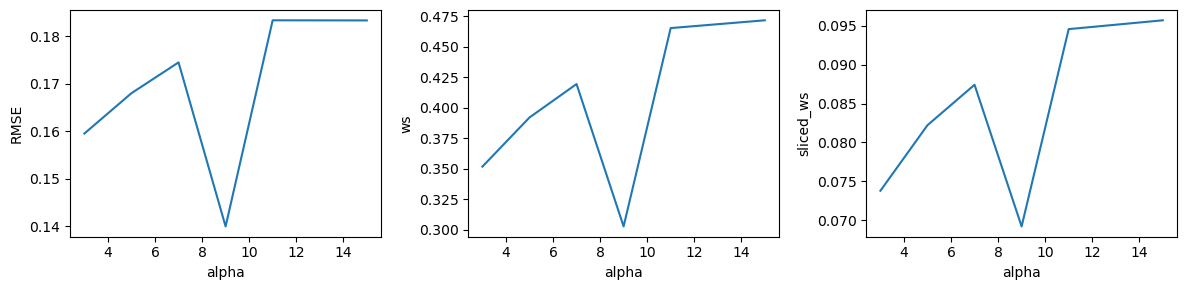

In [24]:
x = [3, 5, 7, 9, 11, 15]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_avg_ncl]
y_ws = [r['imp_result']['imp@ws'] for r in results_avg_ncl]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_avg_ncl]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.31724148632788224
# ws = 1.0327202461435718
# sliced_ws = 0.1650482253637849
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
sample-evenly {}
sample sizes:  [1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-23 15:02:26.614 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:02:26.614 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-23 15:03:01.052 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:03:01.053 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-23 15:03:35.270 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-23 15:03:35.270 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-23 15:03:38.630 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 74.50892079999903


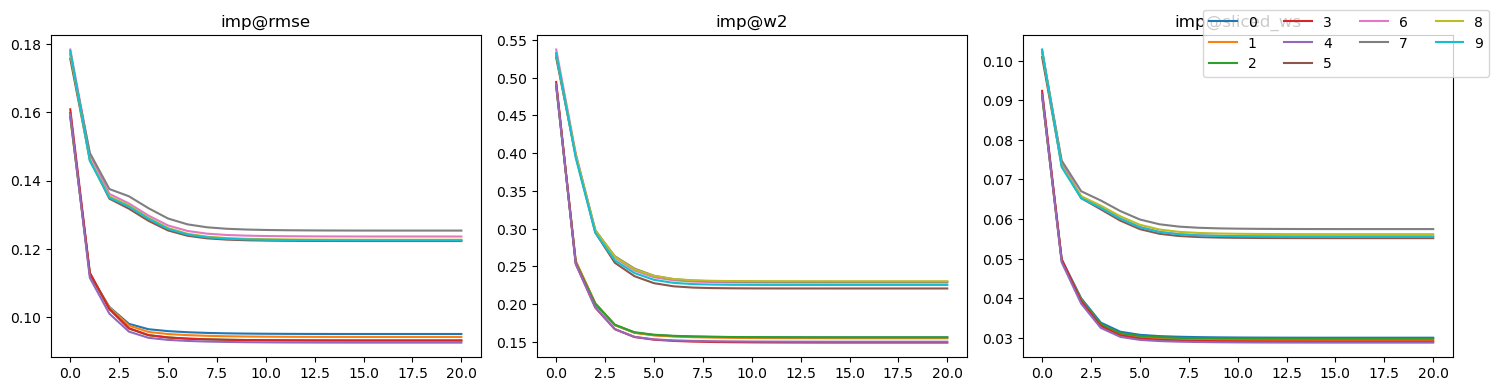

2023-10-23 15:03:39.069 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.6610, test_f1: 0.0000 test_auroc: 0.7860 test_auprc: 0.6378 train_loss: 0.6624 val_accu: 0.6611 val_f1: 0.3980


{'imp@rmse': 0.10840699613876423, 'imp@ws': 0.19007943959575688, 'imp@sliced_ws': 0.0426888799418077}


2023-10-23 15:03:49.390 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 100, test_accu: 0.8625, test_f1: 0.7780 test_auroc: 0.9331 test_auprc: 0.8708 train_loss: 0.4365 val_accu: 0.7892 val_f1: 0.7417
2023-10-23 15:03:59.909 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 200, test_accu: 0.8555, test_f1: 0.7744 test_auroc: 0.9308 test_auprc: 0.8527 train_loss: 0.4201 val_accu: 0.7994 val_f1: 0.7617
2023-10-23 15:04:10.241 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 300, test_accu: 0.8600, test_f1: 0.7829 test_auroc: 0.9304 test_auprc: 0.8330 train_loss: 0.3998 val_accu: 0.8133 val_f1: 0.7777
2023-10-23 15:04:20.883 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 400, test_accu: 0.8675, test_f1: 0.8006 test_auroc: 0.9332 test_auprc: 0.8270 train_loss: 0.3808 val_accu: 0.8297 val_f1: 0.8029


0.903 0.8407224958949097 0.9803339447248514 0.9584985175425208


In [22]:
name = 'mnar_lr_codrna_fedavg-s1'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

#### Complement Split

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-26 10:55:36.420 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:55:36.420 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:56:07.112 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:56:07.113 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10


idx: [2 4 3 1 6 8 7 9 5]
cmp: [0.89283519 0.90150583 0.90152613 0.91018595 0.9128681  0.91466829
 0.91591164 0.92067017 0.92197838]
smp: [0.11111113 0.11111113 0.11111113 0.11111113 0.11111113 0.11111113
 0.11111113 0.11111113 0.11111113]
idx: [8 6 9 4 3 7 5 2 0]
cmp: [8.56559281e-04 9.38430880e-04 1.26732417e-03 1.27896977e-03
 1.48790222e-03 3.45495637e-03 3.54065379e-03 3.98819628e-03
 9.10185954e-01]
smp: [0.11111113 0.11111113 0.11111113 0.11111113 0.11111113 0.11111113
 0.11111113 0.11111113 1.        ]
idx: [1 6 3 4 7 8 5 9 0]
cmp: [0.0039882  0.00415291 0.00540402 0.00569443 0.00606542 0.00613763
 0.00729955 0.00758826 0.89283519]
smp: [0.11111113 0.11111113 0.11111113 0.11111113 0.11111113 0.11111113
 0.11111113 0.11111113 1.        ]
idx: [1 6 4 8 9 7 5 2 0]
cmp: [0.0014879  0.00190791 0.00227837 0.00242407 0.00339411 0.0037468
 0.0048594  0.00540402 0.90152613]
smp: [0.11111113 0.11111113 0.11111113 0.11111113 0.11111113 0.11111113
 0.11111113 0.11111113 1.        ]
idx: [1 

2023-10-26 10:56:41.016 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:56:41.017 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:56:44.481 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 70.71117350005079


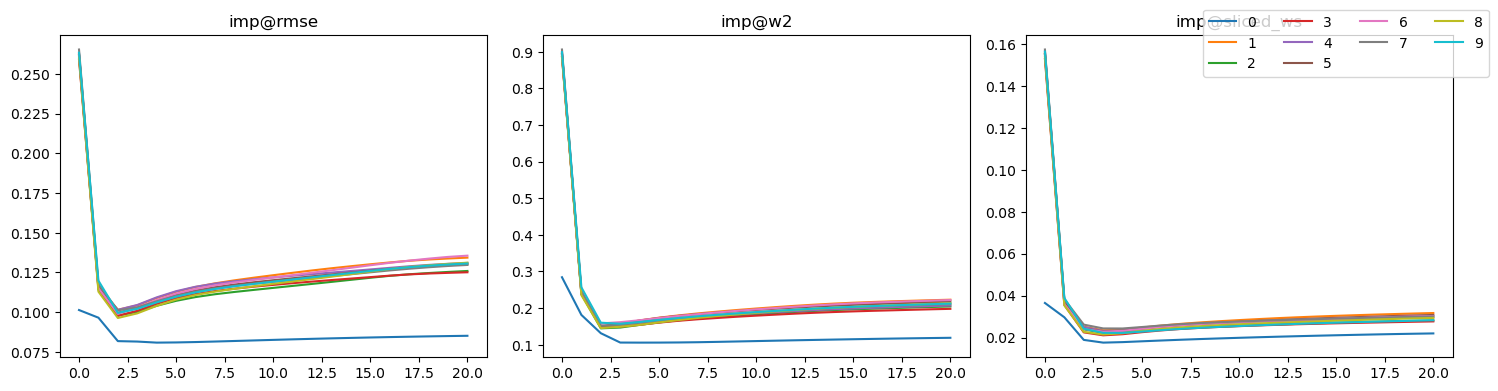

2023-10-26 10:56:44.922 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.6685, test_f1: 0.0000 test_auroc: 0.7759 test_auprc: 0.6322 train_loss: 0.6601 val_accu: 0.6692 val_f1: 0.4009


{'imp@rmse': 0.12439371184493359, 'imp@ws': 0.1995251273961494, 'imp@sliced_ws': 0.02835327533563084}


2023-10-26 10:56:56.080 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 100, test_accu: 0.9295, test_f1: 0.8933 test_auroc: 0.9750 test_auprc: 0.9420 train_loss: 0.3583 val_accu: 0.8425 val_f1: 0.8120
2023-10-26 10:57:06.428 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 200, test_accu: 0.9320, test_f1: 0.8987 test_auroc: 0.9770 test_auprc: 0.9493 train_loss: 0.3522 val_accu: 0.8378 val_f1: 0.8128
2023-10-26 10:57:17.401 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 300, test_accu: 0.9340, test_f1: 0.9021 test_auroc: 0.9785 test_auprc: 0.9538 train_loss: 0.3494 val_accu: 0.8378 val_f1: 0.8138
2023-10-26 10:57:28.290 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 400, test_accu: 0.9305, test_f1: 0.8991 test_auroc: 0.9790 test_auprc: 0.9570 train_loss: 0.3437 val_accu: 0.8250 val_f1: 0.8050


0.9405 0.9096431283219437 0.9804519471904751 0.9594049958555977


In [92]:
name = 'mnar_lr_codrna_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'extremel1'

config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
config2["algo_params"]["fedmechw_new"] = {
        "alpha": 1.0,
        "gamma": 0.0,
        "client_thres": 1.0,
        "scale_factor": 4
    }
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

##### alpha

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:30:22.336 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:30:22.336 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:30:53.173 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:30:53.173 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:31:27.023 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:31:27.024 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:31:30.419 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 70.74511819996405


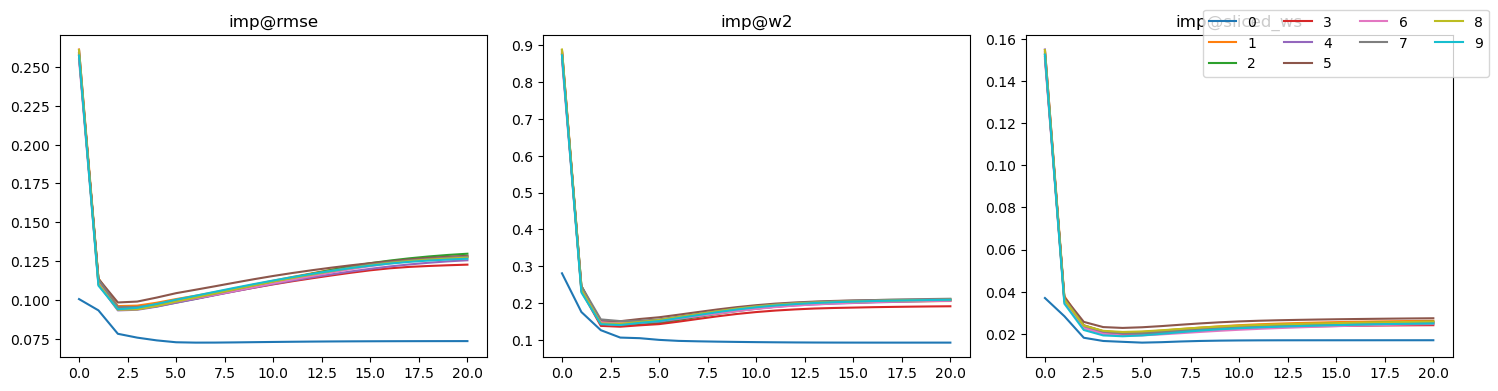

{'imp@rmse': 0.12047806740696218, 'imp@ws': 0.19366135303746262, 'imp@sliced_ws': 0.02429456703941264}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:31:43.528 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:31:43.528 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:32:13.780 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:32:13.781 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:32:47.351 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:32:47.351 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:32:50.749 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 69.82149569992907


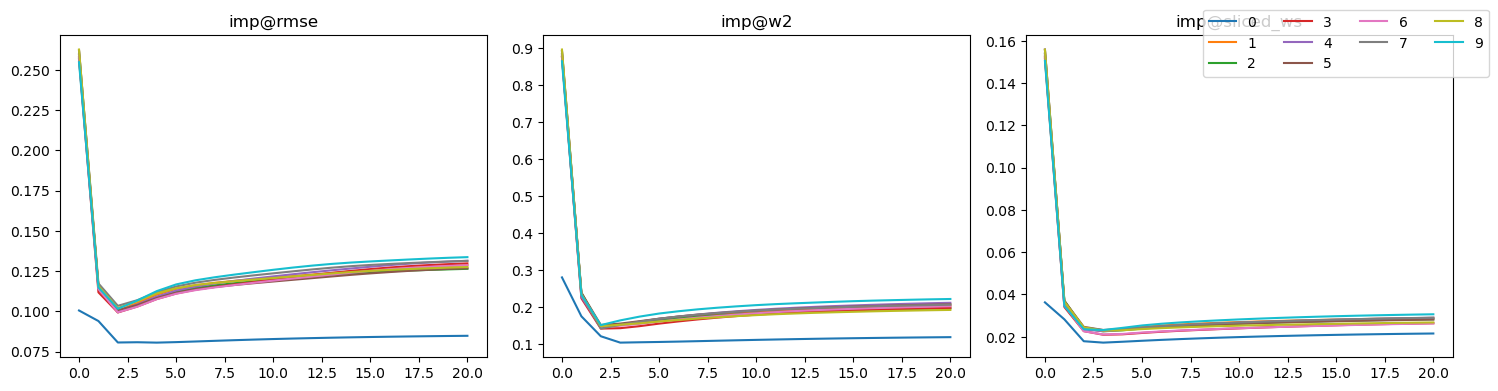

{'imp@rmse': 0.1239347750608038, 'imp@ws': 0.1938059244711809, 'imp@sliced_ws': 0.027152310341090592}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:33:03.856 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:33:03.856 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:33:34.141 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:33:34.142 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:34:07.937 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:34:07.937 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:34:11.335 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 70.07821649999823


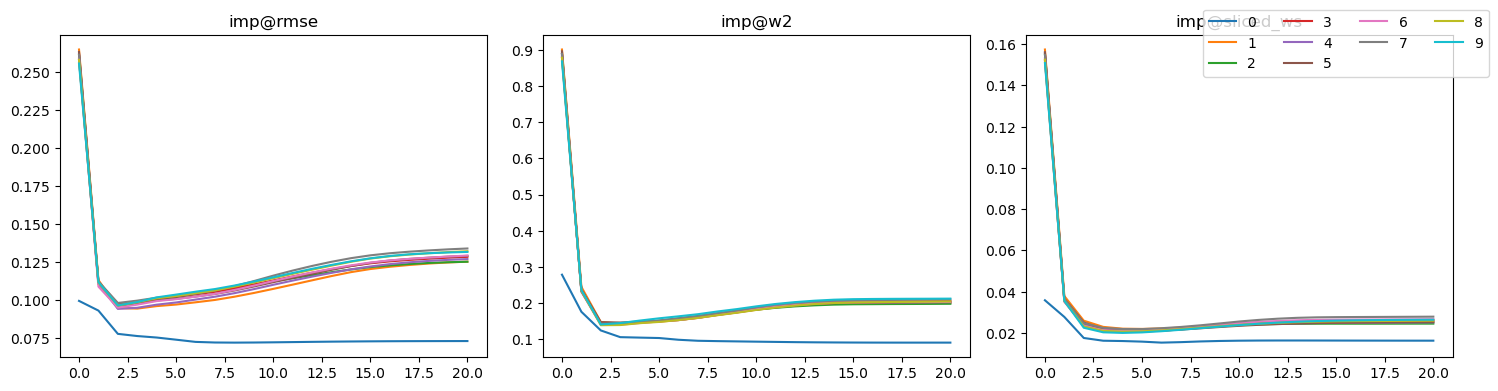

{'imp@rmse': 0.12219920687301876, 'imp@ws': 0.1915689071025039, 'imp@sliced_ws': 0.024867154250875864}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:34:24.451 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:34:24.452 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:34:54.755 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:34:54.756 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:35:29.256 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:35:29.257 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:35:32.788 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 70.95168079994619


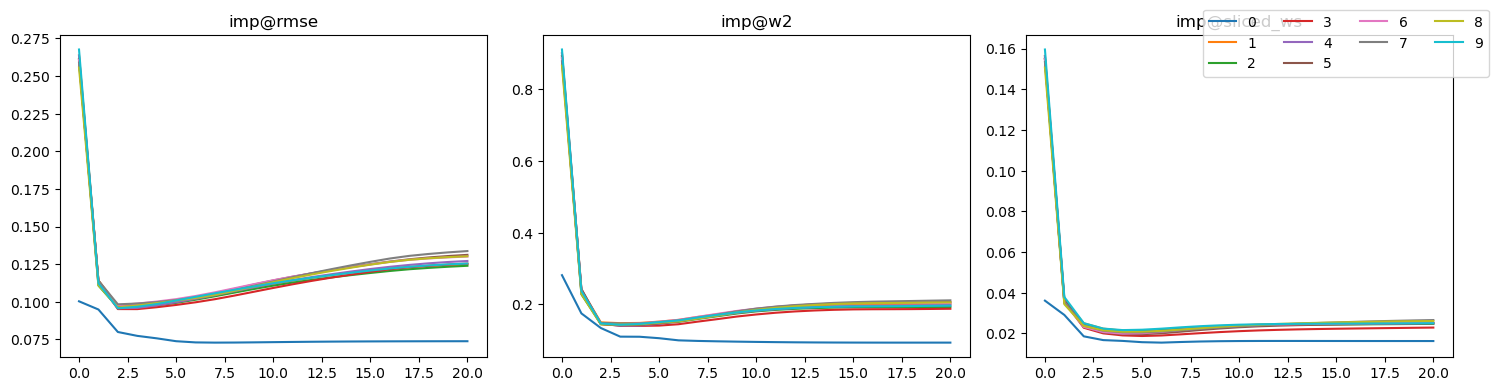

{'imp@rmse': 0.12109113592567237, 'imp@ws': 0.18853865854815402, 'imp@sliced_ws': 0.023994042684611864}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:35:46.835 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:35:46.836 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:36:18.667 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:36:18.668 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:36:54.032 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:36:54.033 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:36:57.586 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 73.53499199997168


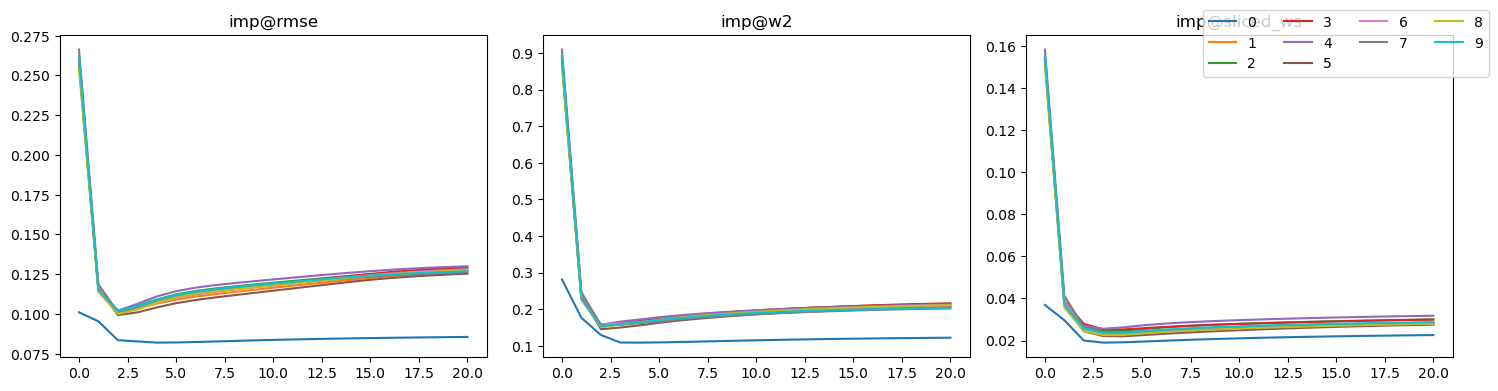

{'imp@rmse': 0.1222225062447854, 'imp@ws': 0.1983299997237267, 'imp@sliced_ws': 0.028020439819036142}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:37:11.799 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:37:11.800 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:37:43.986 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:37:43.987 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:38:19.808 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:38:19.809 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:38:23.463 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 74.42281929997262


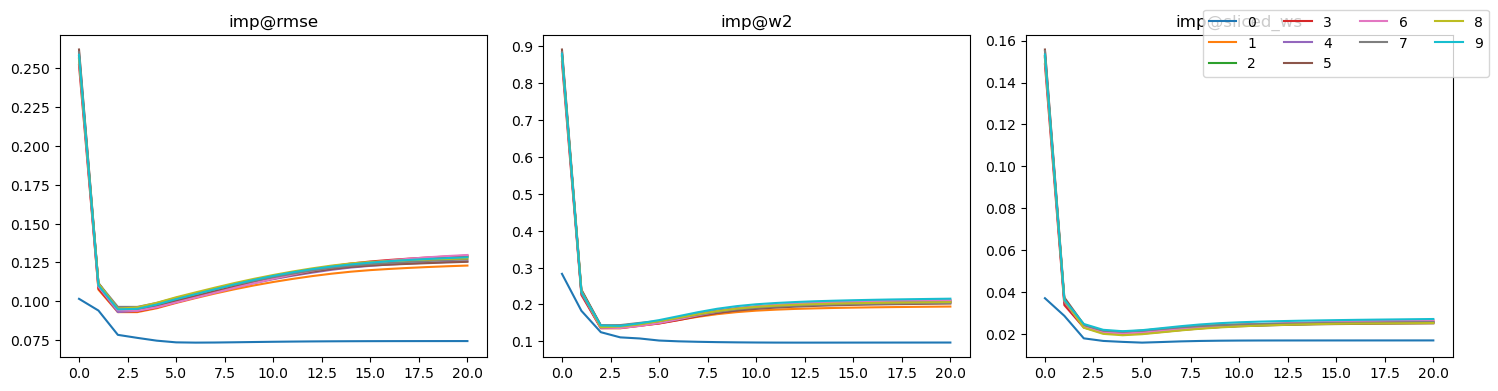

{'imp@rmse': 0.12094192479919158, 'imp@ws': 0.19470761576763732, 'imp@sliced_ws': 0.024962311837802273}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:38:37.974 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:38:37.974 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:39:09.592 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:39:09.593 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:39:43.355 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:39:43.355 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:39:46.767 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 71.72148879989982


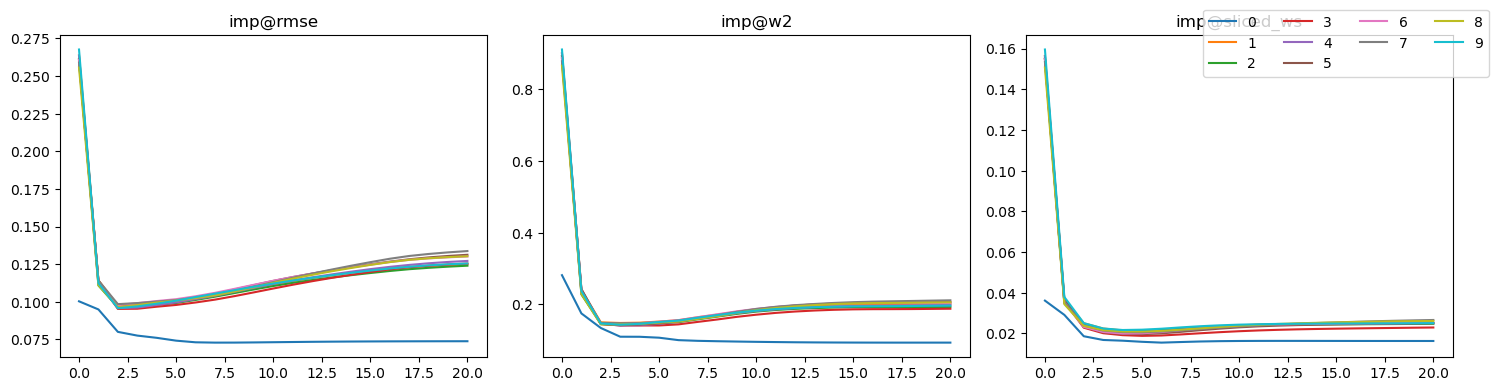

{'imp@rmse': 0.1211009885728477, 'imp@ws': 0.1886777027571151, 'imp@sliced_ws': 0.024012300656993175}


In [85]:
results_compl_alpha = []

for alpha in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
    config2['data_partition']['strategy'] = 'extremel1'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.0,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

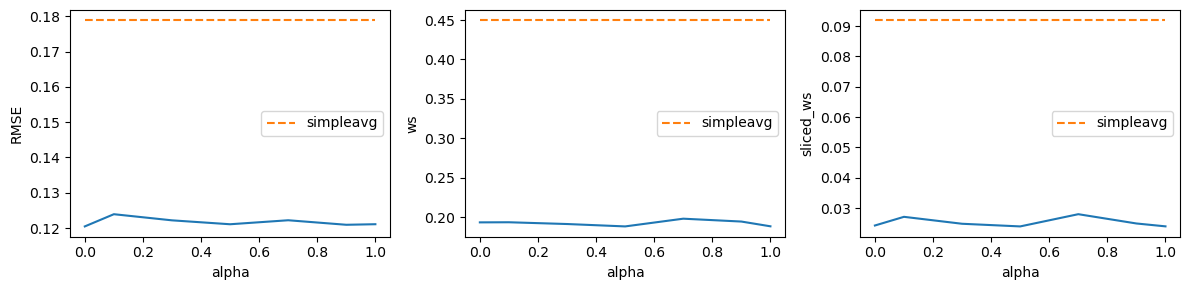

In [89]:
x = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

rmse = 0.17884472919516609
ws =  0.4496532470292862
sliced_ws = 0.09188334255186284
ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

##### Gamma

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:40:00.178 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:40:00.178 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:40:30.196 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:40:30.197 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:41:03.611 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:41:03.612 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:41:06.989 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 69.40250039997045


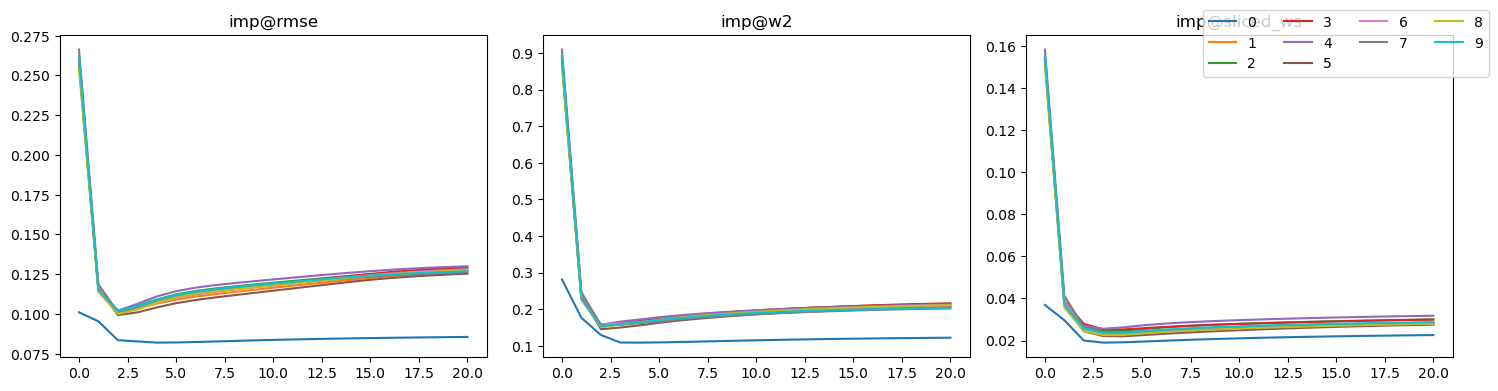

{'imp@rmse': 0.1222225062447854, 'imp@ws': 0.1983299997237267, 'imp@sliced_ws': 0.028020439819036142}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:41:20.028 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:41:20.028 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:41:50.061 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:41:50.062 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:42:23.503 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:42:23.503 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:42:26.872 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 69.4464949000394


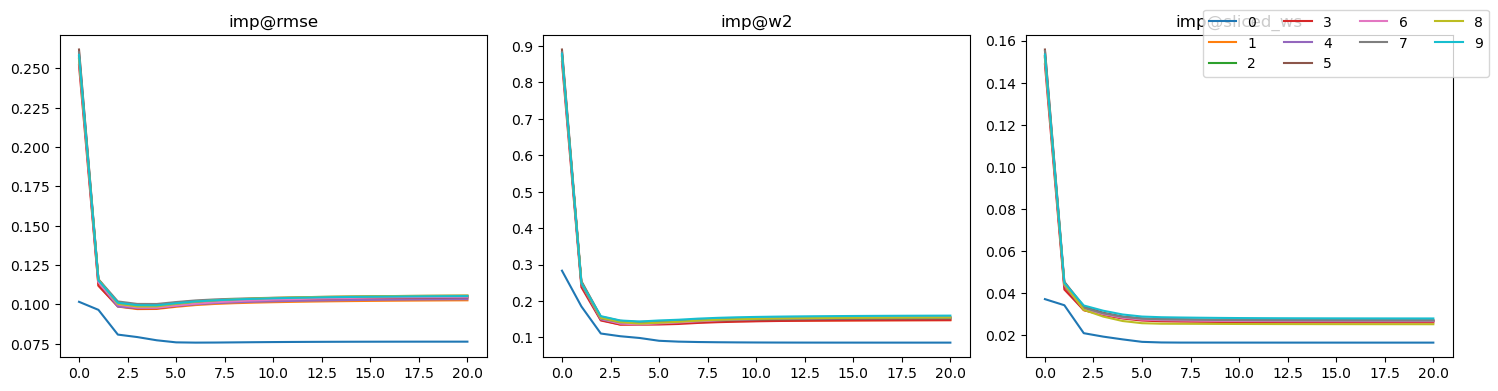

{'imp@rmse': 0.10157485088309681, 'imp@ws': 0.14585443535560005, 'imp@sliced_ws': 0.025789558944202005}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:42:39.970 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:42:39.970 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:43:09.917 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:43:09.918 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:43:43.310 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:43:43.311 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:43:46.678 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 69.29961480002385


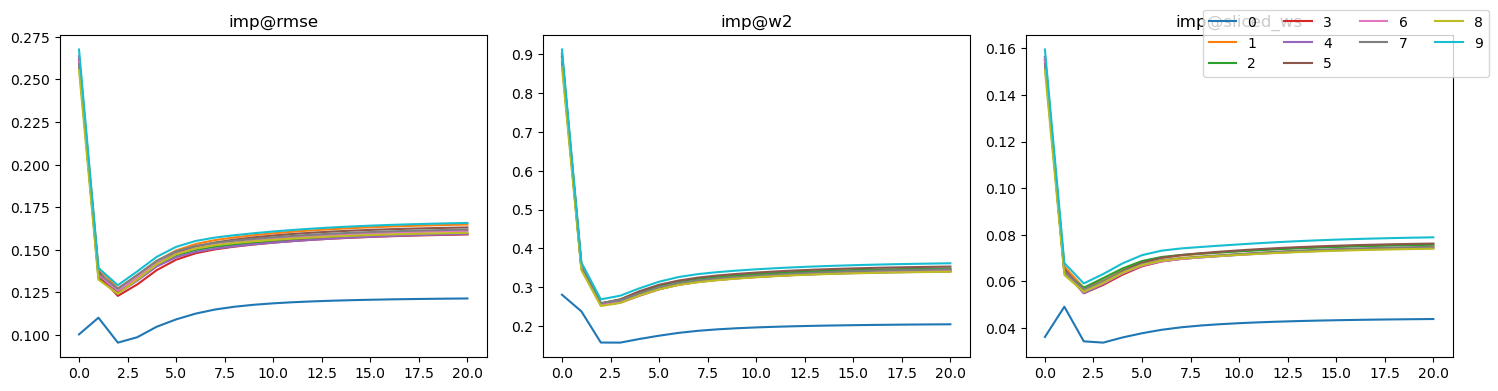

{'imp@rmse': 0.15708181445052502, 'imp@ws': 0.33130746337221345, 'imp@sliced_ws': 0.07192352343048189}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:43:59.733 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:43:59.734 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:44:29.636 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:44:29.637 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:45:02.903 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:45:02.904 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:45:06.274 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 69.1402624999173


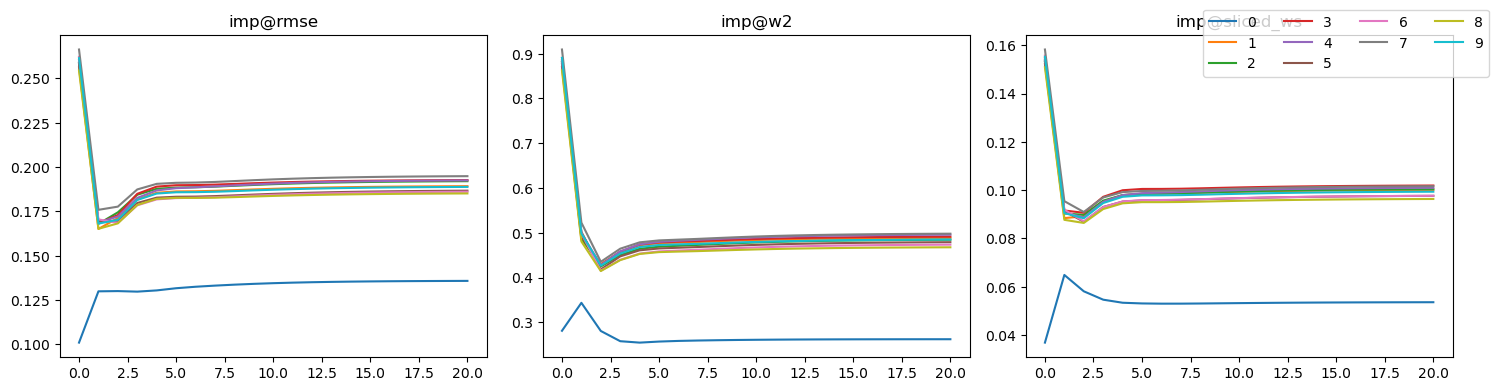

{'imp@rmse': 0.18419488415906005, 'imp@ws': 0.4620482582506624, 'imp@sliced_ws': 0.0948980825332735}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:45:20.177 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:45:20.177 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:45:50.378 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:45:50.378 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:46:23.681 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:46:23.682 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:46:27.037 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 69.48568110004999


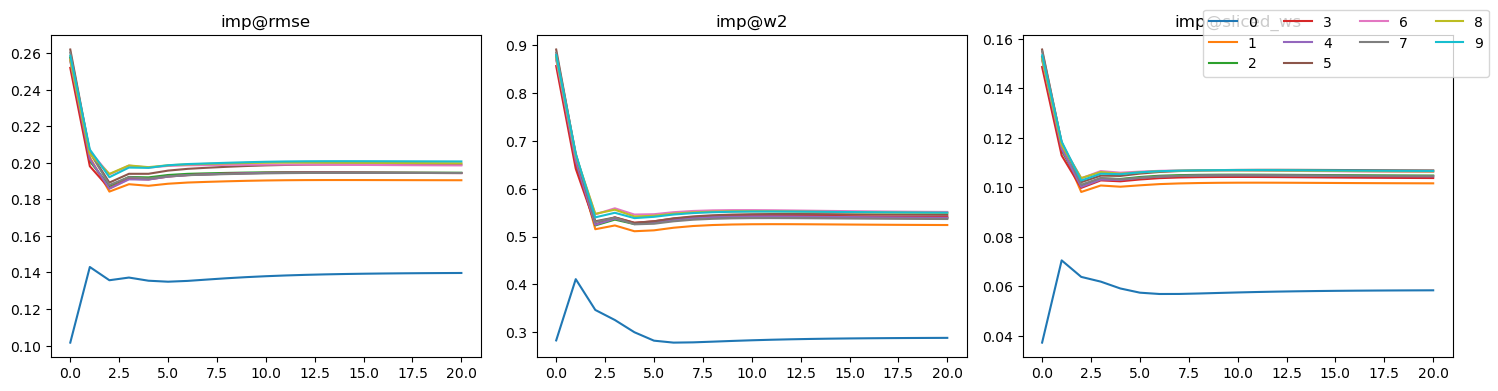

{'imp@rmse': 0.19066468331041306, 'imp@ws': 0.5167476252717534, 'imp@sliced_ws': 0.10042616841614432}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:46:40.105 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:46:40.105 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:47:10.019 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:47:10.020 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:47:43.777 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:47:43.778 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:47:47.236 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 69.74281959992368


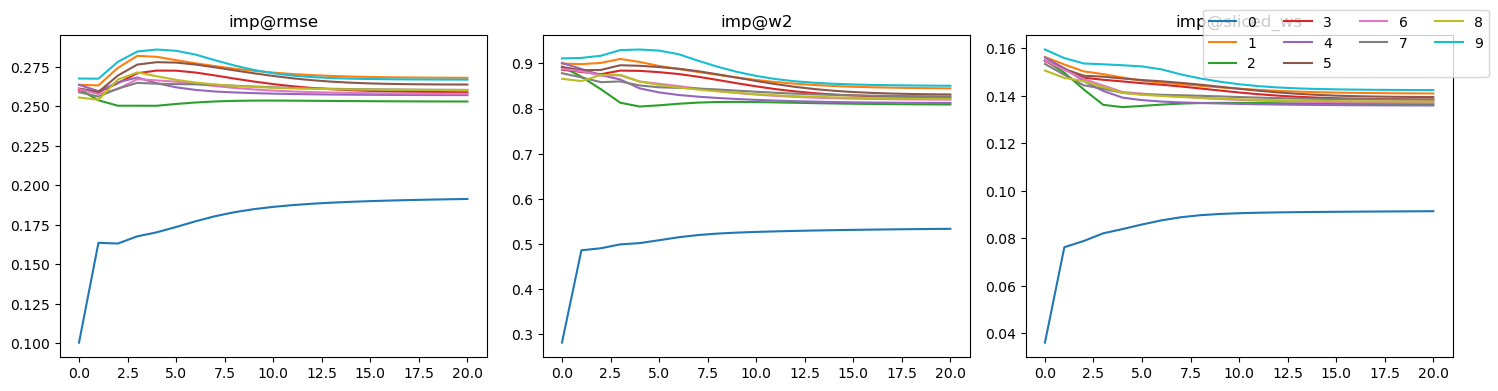

{'imp@rmse': 0.2538045246975045, 'imp@ws': 0.7980556011288589, 'imp@sliced_ws': 0.13390924317252678}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
extremel1 {}
sample sizes:  [9000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
10
[1, 9]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:48:00.432 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:48:00.433 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:48:30.264 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:48:30.264 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:49:03.461 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:49:03.462 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:49:06.779 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 69.01219009992201


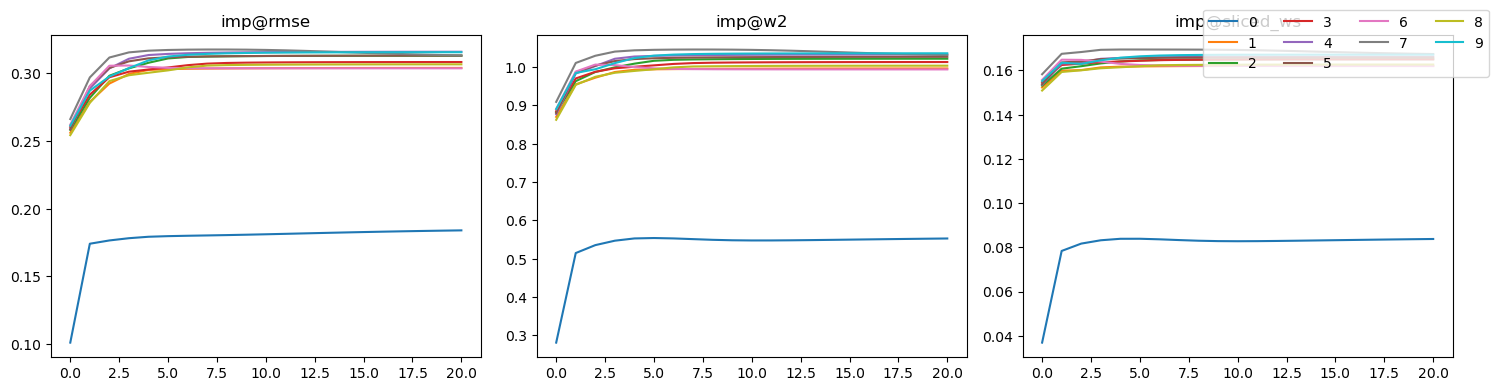

{'imp@rmse': 0.2978211656048841, 'imp@ws': 0.9711013852969868, 'imp@sliced_ws': 0.15668706550164516}


In [87]:
results_compl_gamma = []

for gamma in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
    config2['data_partition']['strategy'] = 'extremel1'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": 0.7,
            "gamma": gamma,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_gamma.append(ret.copy())

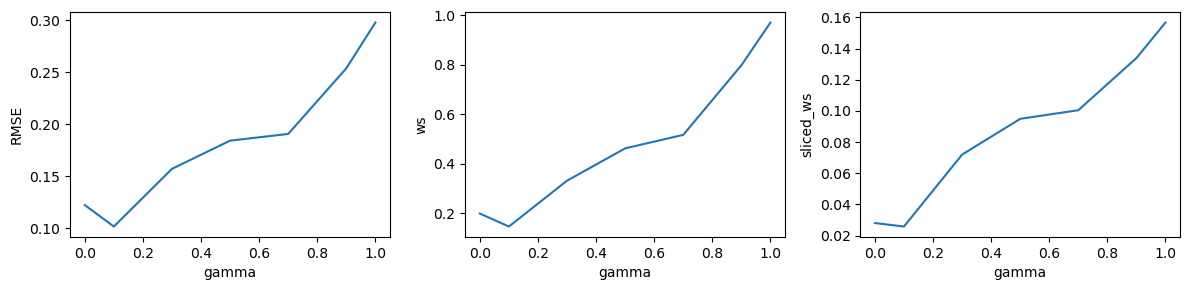

In [88]:
x = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_gamma]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_gamma]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_gamma]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('gamma')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

rmse = 0.31724148632788224
ws = 1.0327202461435718
sliced_ws = 0.1650482253637849
ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

## Subcase2 - 2 clusters

#### Simple Average

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-26 09:49:58.447 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:49:58.449 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:50:40.801 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:50:40.802 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:51:23.574 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:51:23.574 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:51:27.881 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 92.92203240003437


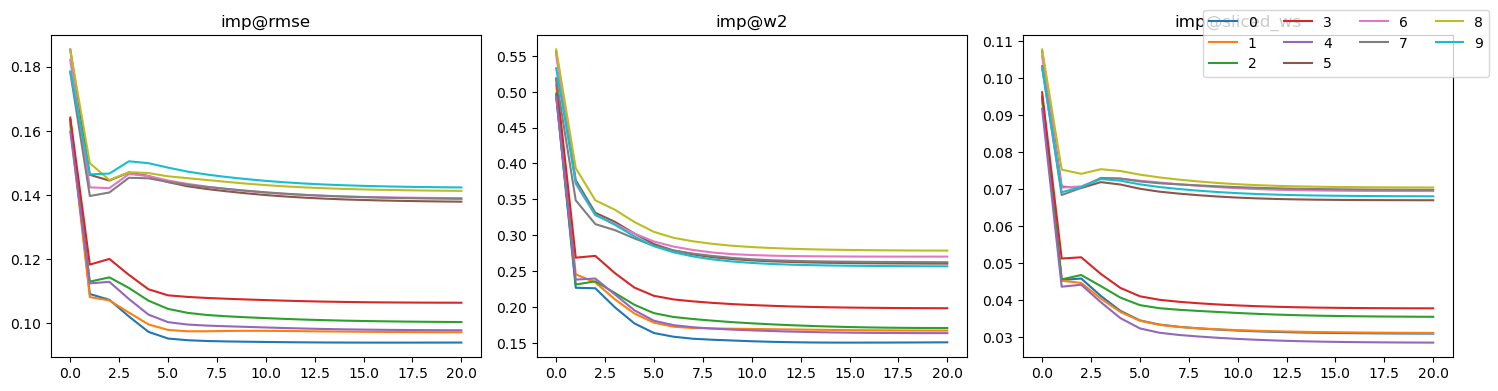

2023-10-26 09:51:28.346 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.6615, test_f1: 0.0000 test_auroc: 0.7619 test_auprc: 0.6304 train_loss: 0.6584 val_accu: 0.6610 val_f1: 0.3980


{'imp@rmse': 0.11946250623887397, 'imp@ws': 0.217692259541295, 'imp@sliced_ws': 0.05089186952055539}


2023-10-26 09:51:40.373 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 100, test_accu: 0.8055, test_f1: 0.6183 test_auroc: 0.9536 test_auprc: 0.8946 train_loss: 0.4808 val_accu: 0.7300 val_f1: 0.6663
2023-10-26 09:51:52.288 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 200, test_accu: 0.8135, test_f1: 0.6600 test_auroc: 0.9301 test_auprc: 0.8376 train_loss: 0.4438 val_accu: 0.7690 val_f1: 0.7281
2023-10-26 09:52:03.718 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 300, test_accu: 0.7885, test_f1: 0.6101 test_auroc: 0.8960 test_auprc: 0.7905 train_loss: 0.4109 val_accu: 0.7937 val_f1: 0.7369
2023-10-26 09:52:15.333 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 400, test_accu: 0.7895, test_f1: 0.6148 test_auroc: 0.8865 test_auprc: 0.7840 train_loss: 0.3976 val_accu: 0.8140 val_f1: 0.7698


0.8565 0.7378995433789955 0.9756473079959047 0.9539869097989466


In [77]:
name = 'mnar_lr_codrna_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
config2['data_partition']['strategy'] = 'uneven10'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

#### Complement Split

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-10-26 09:18:29.108 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:18:29.108 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:19:11.847 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:19:11.848 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10


idx: [2 3 1 4 9 5 6 7 8]
cmp: [0.01387814 0.01607221 0.0167728  0.20611936 0.81255169 0.95159928
 0.98405782 0.9871172  0.99598585]
smp: [0.01041669 0.01041669 0.01041669 1.         1.         0.01041669
 0.01041669 0.01041669 0.01041669]
idx: [0 2 3 4 9 5 7 8 6]
cmp: [0.0167728  0.02661292 0.02739437 0.22584169 0.79750826 0.93834474
 0.95809565 0.97271732 0.97397225]
smp: [0.01041669 0.01041669 0.01041669 1.         1.         0.01041669
 0.01041669 0.01041669 0.01041669]
idx: [3 0 1 4 9 5 8 6 7]
cmp: [0.00397564 0.01387814 0.02661292 0.14288237 0.86920053 0.97019749
 0.98853297 0.9905206  0.99266877]
smp: [0.01041669 0.01041669 0.01041669 1.         1.         0.01041669
 0.01041669 0.01041669 0.01041669]
idx: [2 0 1 4 9 8 5 7 6]
cmp: [0.00397564 0.01607221 0.02739437 0.13661479 0.87280188 0.98244586
 0.98644381 0.99126654 0.99739654]
smp: [0.01041669 0.01041669 0.01041669 1.         1.         0.01041669
 0.01041669 0.01041669 0.01041669]
idx: [3 2 0 1 8 6 7 5 9]
cmp: [0.13661479 0.

2023-10-26 09:19:54.511 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:19:54.512 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:19:58.889 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 93.24824869993608


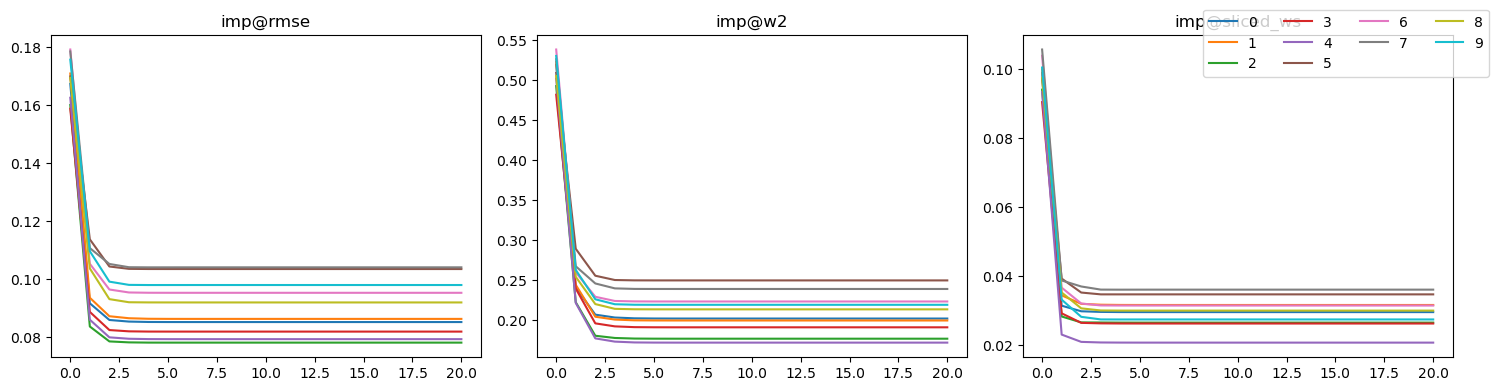

2023-10-26 09:19:59.329 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 0, test_accu: 0.6685, test_f1: 0.0000 test_auroc: 0.7727 test_auprc: 0.6344 train_loss: 0.6541 val_accu: 0.6675 val_f1: 0.4003


{'imp@rmse': 0.09040836542598817, 'imp@ws': 0.20876503439329522, 'imp@sliced_ws': 0.02939455029790373}


2023-10-26 09:20:11.261 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 100, test_accu: 0.9405, test_f1: 0.9119 test_auroc: 0.9830 test_auprc: 0.9576 train_loss: 0.3488 val_accu: 0.8345 val_f1: 0.8057
2023-10-26 09:20:23.121 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 200, test_accu: 0.9360, test_f1: 0.9026 test_auroc: 0.9835 test_auprc: 0.9618 train_loss: 0.3306 val_accu: 0.8413 val_f1: 0.8101
2023-10-26 09:20:34.675 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 300, test_accu: 0.9165, test_f1: 0.8623 test_auroc: 0.9823 test_auprc: 0.9589 train_loss: 0.3289 val_accu: 0.8283 val_f1: 0.7787
2023-10-26 09:20:46.631 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:195 - Round: 400, test_accu: 0.9415, test_f1: 0.9116 test_auroc: 0.9829 test_auprc: 0.9610 train_loss: 0.3245 val_accu: 0.8470 val_f1: 0.8192


0.9445 0.9174579985390796 0.9841555631515594 0.9629545959742573


In [71]:
name = 'mnar_lr_codrna_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 10
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
config2['data_partition']['strategy'] = 'uneven10'
config2["algo_params"]["fedmechw_new"] = {
            "alpha": 1.0,
            "gamma": 0.0,
            "client_thres": 1.0,
            "scale_factor": 4
        }

config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

##### Alpha

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:21:37.844 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:21:37.845 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:22:16.722 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:22:16.723 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:23:00.069 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:23:00.070 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:23:04.433 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 90.11045869998634


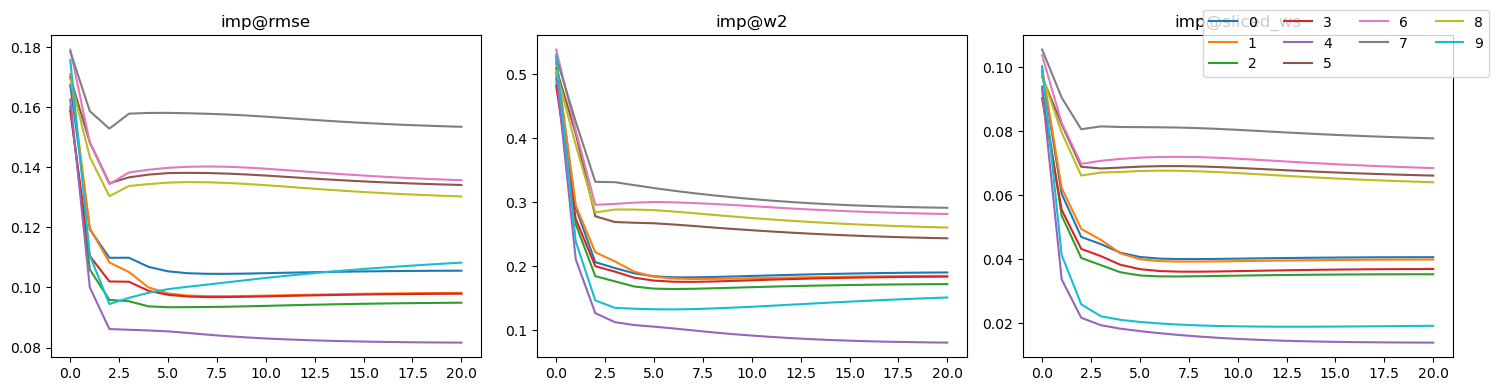

{'imp@rmse': 0.11412585677970798, 'imp@ws': 0.20402998402962616, 'imp@sliced_ws': 0.046373865446264345}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:23:18.520 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:23:18.520 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:23:57.387 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:23:57.388 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:24:40.533 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:24:40.534 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:24:44.887 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.87407499994151


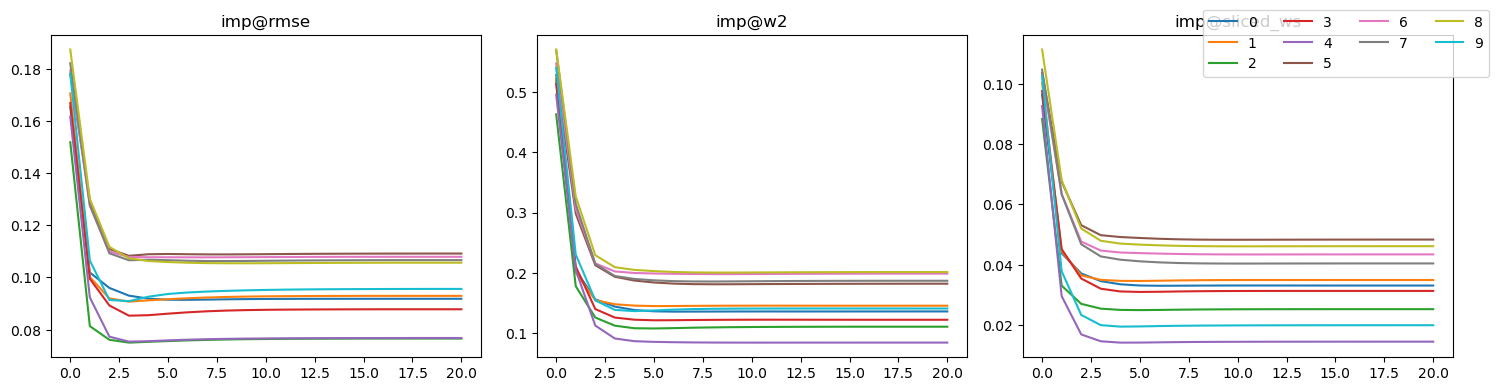

{'imp@rmse': 0.09507952381229053, 'imp@ws': 0.15125255767054416, 'imp@sliced_ws': 0.033716968923568784}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:24:58.925 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:24:58.926 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:25:37.896 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:25:37.897 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:26:20.792 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:26:20.792 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:26:25.112 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.70649469993077


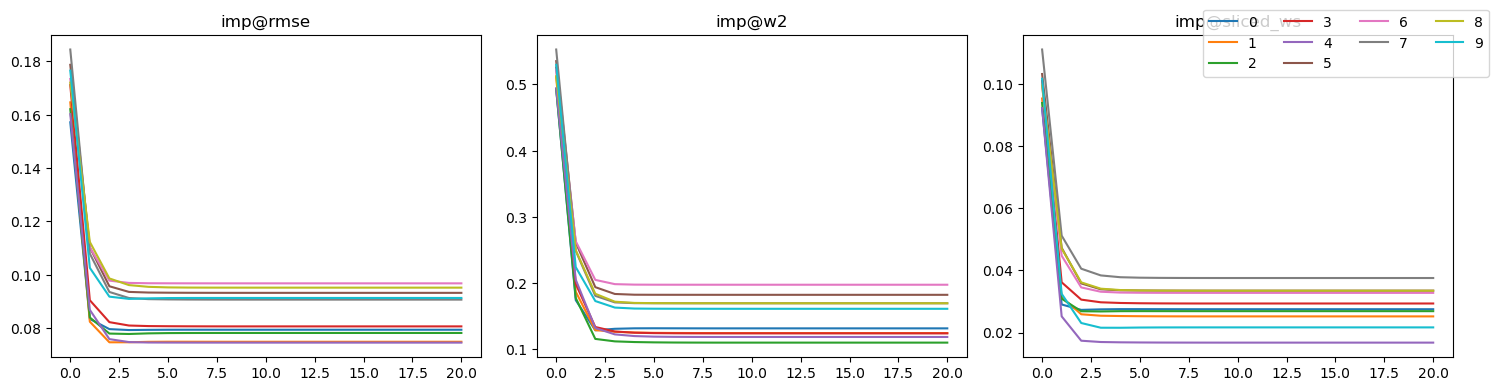

{'imp@rmse': 0.08544645141740291, 'imp@ws': 0.14847571878828308, 'imp@sliced_ws': 0.028436909294840215}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:26:39.133 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:26:39.133 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:27:17.757 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:27:17.758 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:28:00.650 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:28:00.651 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:28:04.976 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.3245331000071


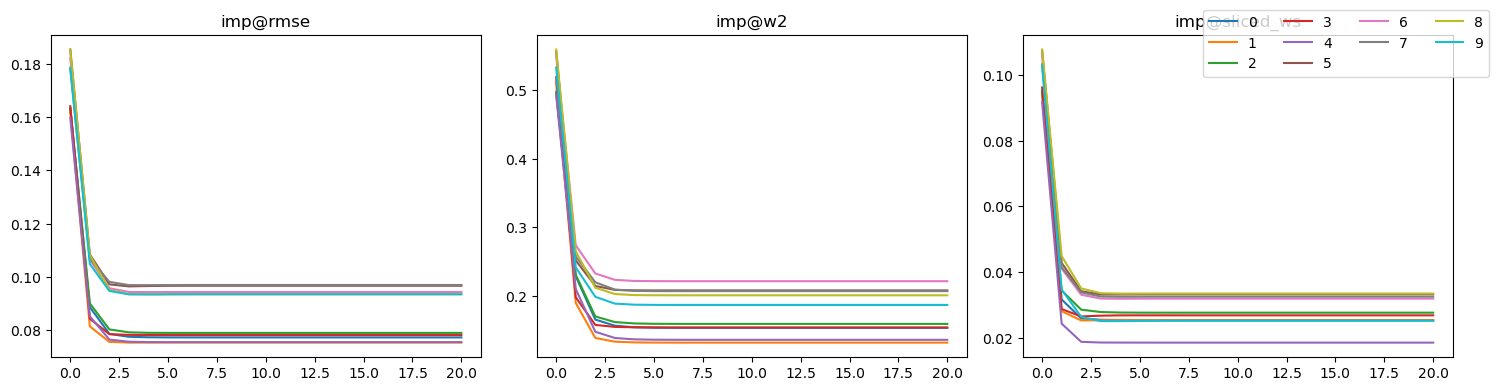

{'imp@rmse': 0.08606123600999244, 'imp@ws': 0.17642618971747198, 'imp@sliced_ws': 0.027949391144294306}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:28:19.036 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:28:19.038 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:28:57.722 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:28:57.723 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:29:40.504 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:29:40.505 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:29:44.828 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.30958409991581


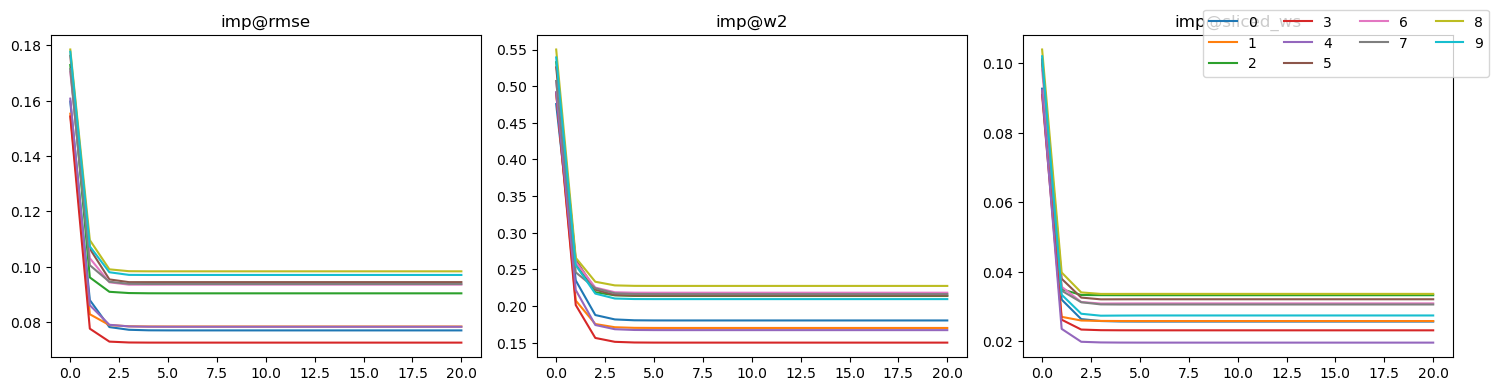

{'imp@rmse': 0.08739952956666748, 'imp@ws': 0.19665433672010801, 'imp@sliced_ws': 0.0282291310459635}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:29:58.903 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:29:58.904 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:30:37.548 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:30:37.549 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:31:20.542 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:31:20.543 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:31:24.919 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.54440310003702


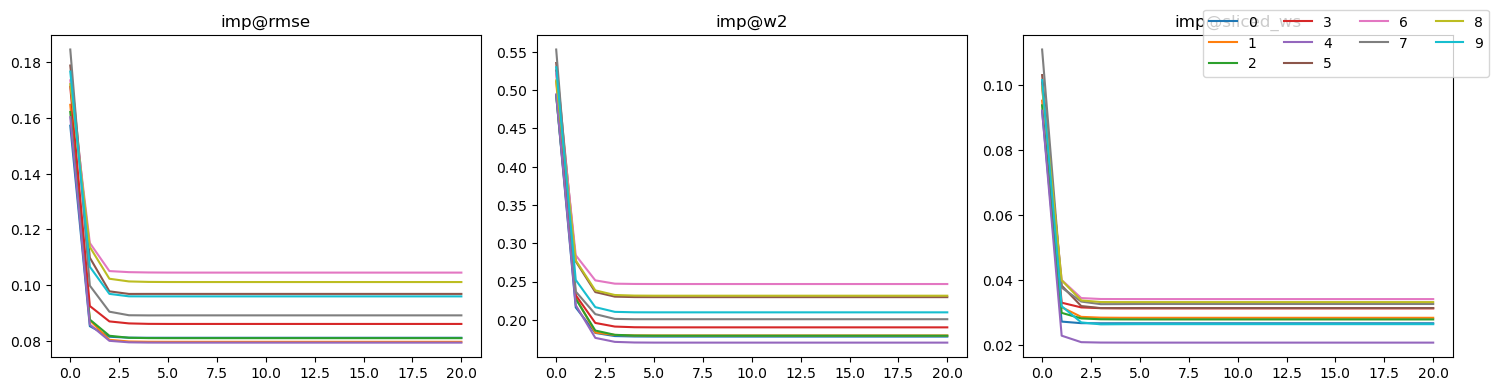

{'imp@rmse': 0.08952908356262611, 'imp@ws': 0.20160006361298105, 'imp@sliced_ws': 0.029205443333873732}


In [73]:
results_compl_alpha = []

for alpha in [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
    config2['data_partition']['strategy'] = 'uneven10'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.0,
            "client_thres": 1.0,
            "scale_factor": 2
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

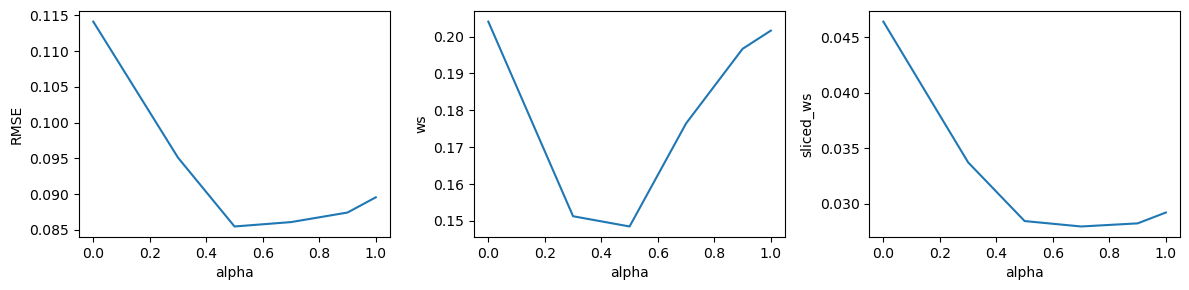

In [74]:
x = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.31724148632788224
# ws = 1.0327202461435718
# sliced_ws = 0.1650482253637849
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

##### Alpha T=4

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:34:33.601 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:34:33.601 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:35:13.012 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:35:13.013 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:35:55.921 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:35:55.922 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:36:00.213 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 90.12593029998243


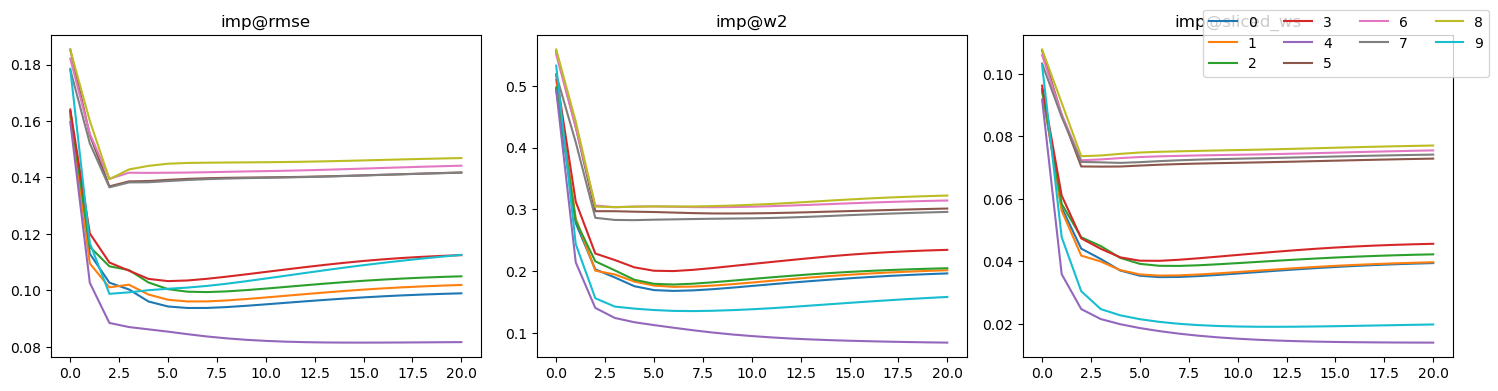

{'imp@rmse': 0.11816464125500005, 'imp@ws': 0.22922195722924993, 'imp@sliced_ws': 0.04974389973955228}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:36:14.275 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:36:14.277 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:36:53.009 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:36:53.010 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:37:35.984 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:37:35.985 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:37:40.311 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.54489309992641


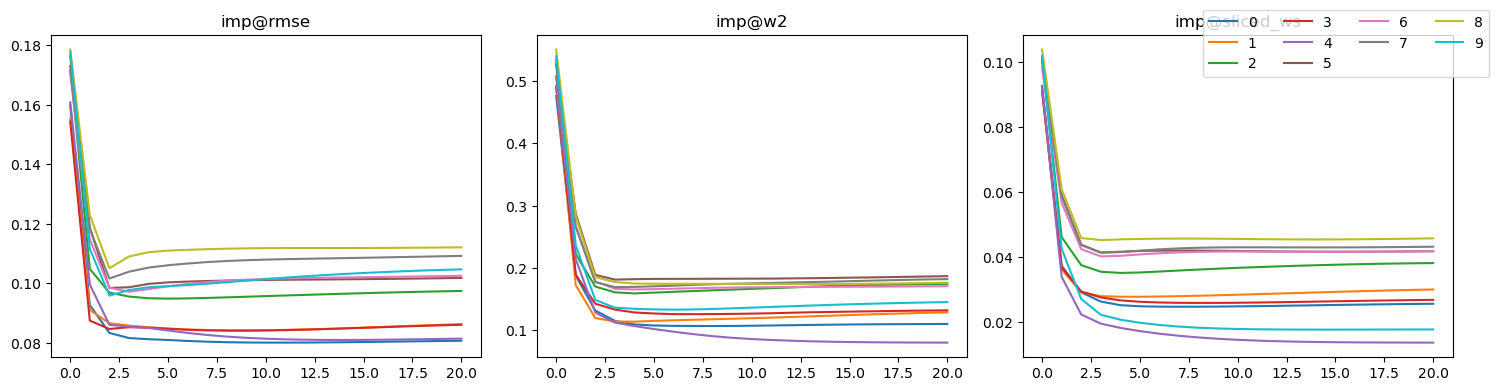

{'imp@rmse': 0.09600378526754488, 'imp@ws': 0.1480643483722684, 'imp@sliced_ws': 0.03238016712898346}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:37:54.284 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:37:54.285 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:38:33.040 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:38:33.041 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:39:16.216 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:39:16.217 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:39:20.574 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.78608849993907


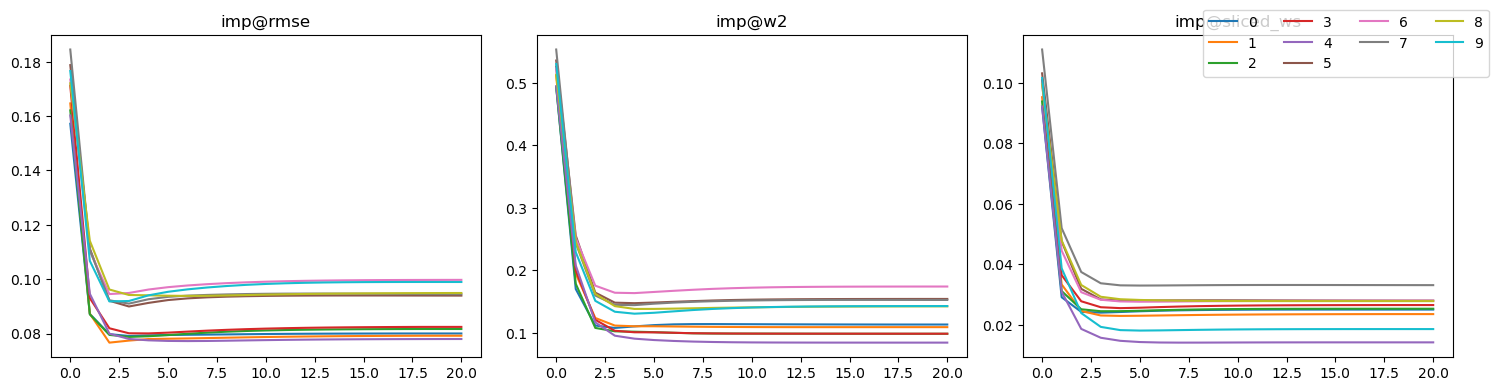

{'imp@rmse': 0.08833341100859808, 'imp@ws': 0.12729374173435215, 'imp@sliced_ws': 0.024990666666995752}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:39:34.635 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:39:34.636 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:40:13.352 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:40:13.353 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:40:56.459 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:40:56.459 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:41:00.784 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.65013620001264


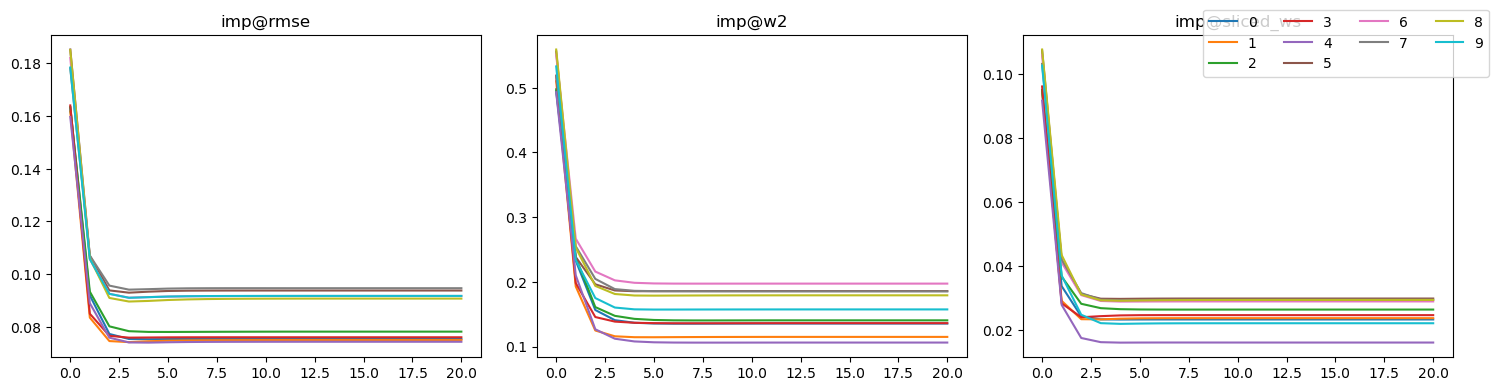

{'imp@rmse': 0.08406670354370709, 'imp@ws': 0.15377256996342434, 'imp@sliced_ws': 0.025291610471953635}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:41:15.351 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:41:15.351 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:41:54.676 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:41:54.677 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:42:37.613 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:42:37.615 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:42:41.906 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 90.0801528999582


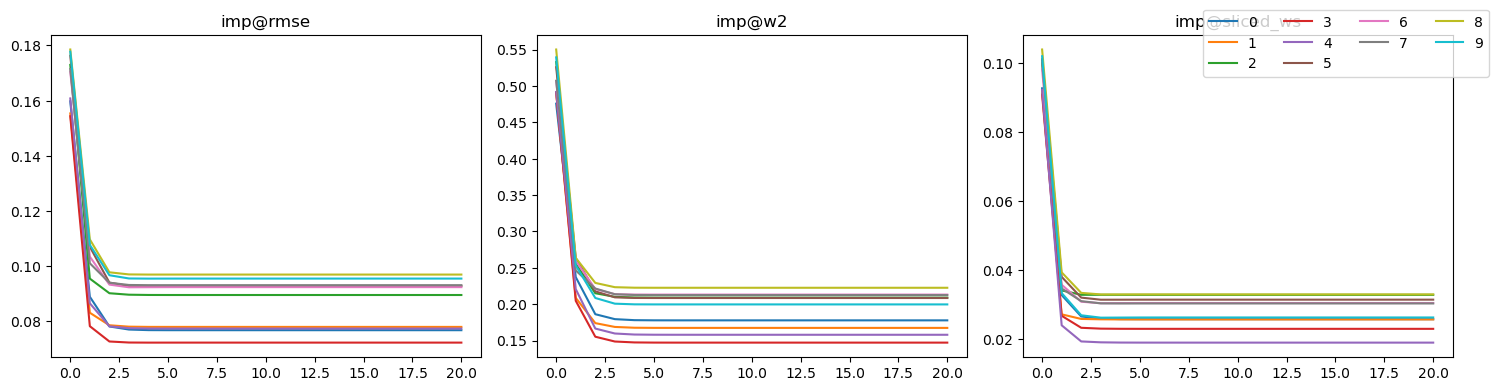

{'imp@rmse': 0.08636879517404361, 'imp@ws': 0.19153926217328354, 'imp@sliced_ws': 0.02764863717744589}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:42:56.092 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:42:56.093 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:43:35.083 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:43:35.084 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:44:17.388 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:44:17.390 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:44:21.826 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.30383170000277


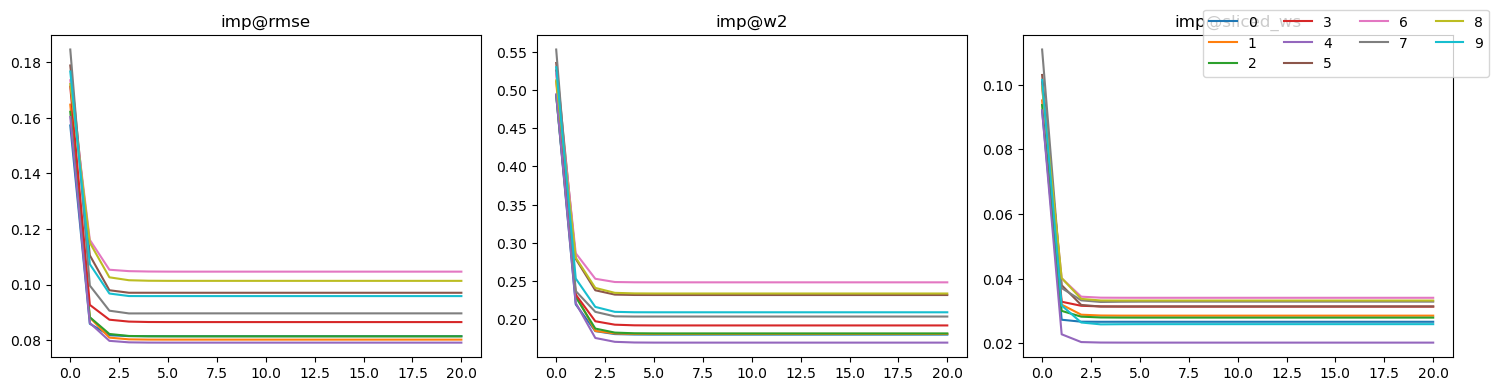

{'imp@rmse': 0.0897024842318382, 'imp@ws': 0.20328632877166633, 'imp@sliced_ws': 0.02922814709774232}


In [75]:
results_compl_alpha = []

for alpha in [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
    config2['data_partition']['strategy'] = 'uneven10'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.0,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

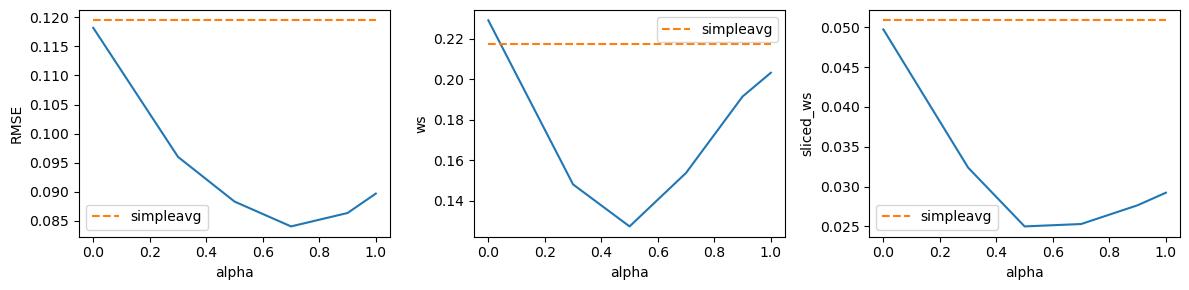

In [78]:
x = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

rmse = 0.11946250623887397
ws = 0.217692259541295
sliced_ws = 0.05089186952055539
ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

##### Gamma

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 09:58:17.051 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:58:17.052 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 09:58:59.727 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:58:59.728 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 09:59:42.888 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 09:59:42.889 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 09:59:47.238 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 93.69090599997435


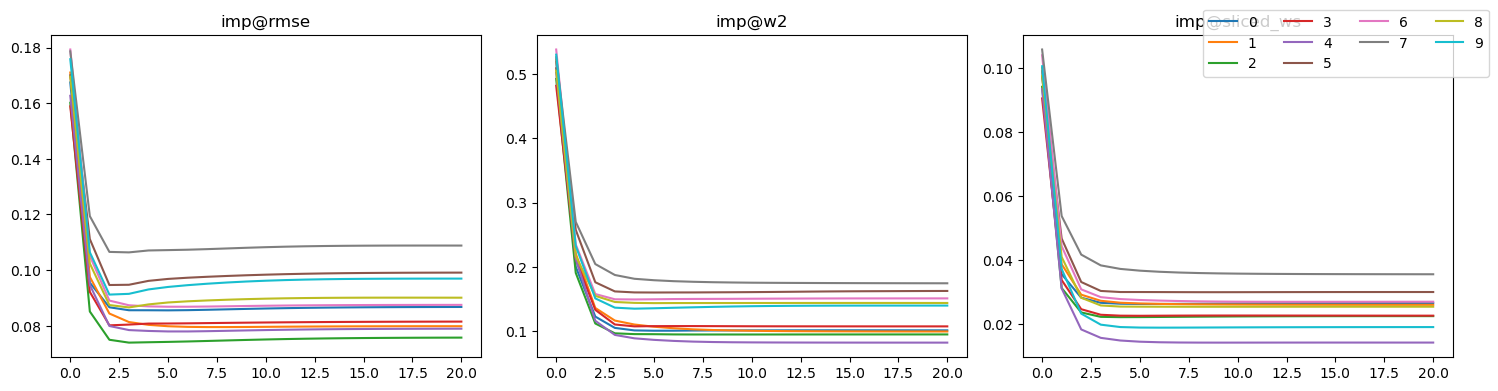

{'imp@rmse': 0.08845268951205895, 'imp@ws': 0.12574560065015195, 'imp@sliced_ws': 0.024887789450050372}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:00:01.216 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:00:01.217 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:00:39.862 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:00:39.862 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:01:22.767 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:01:22.768 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:01:27.090 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.38989519991446


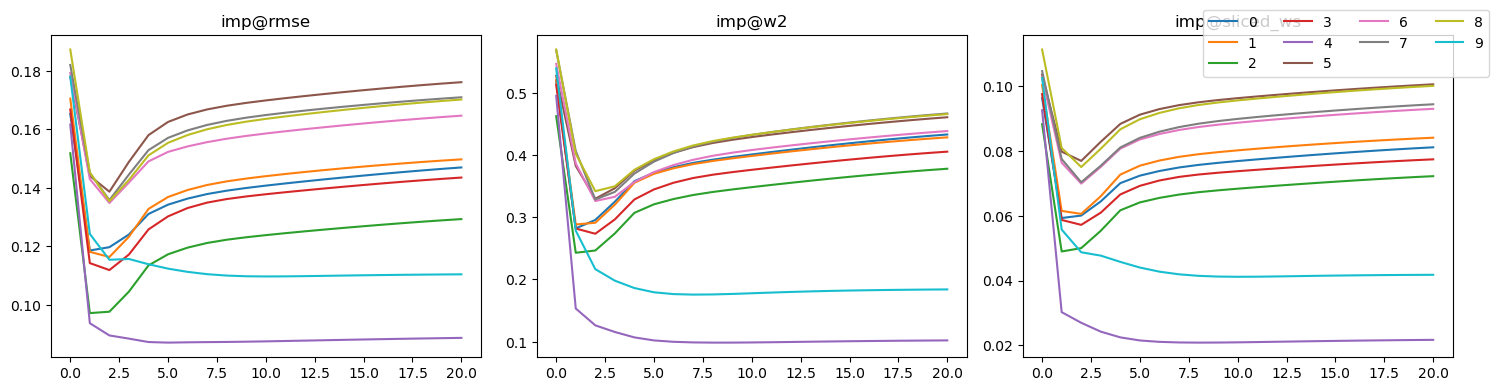

{'imp@rmse': 0.14423353515539136, 'imp@ws': 0.37210530372840667, 'imp@sliced_ws': 0.07609356968747061}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:01:41.131 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:01:41.131 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:02:19.789 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:02:19.789 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:03:02.609 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:03:02.610 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:03:06.956 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.32028879993595


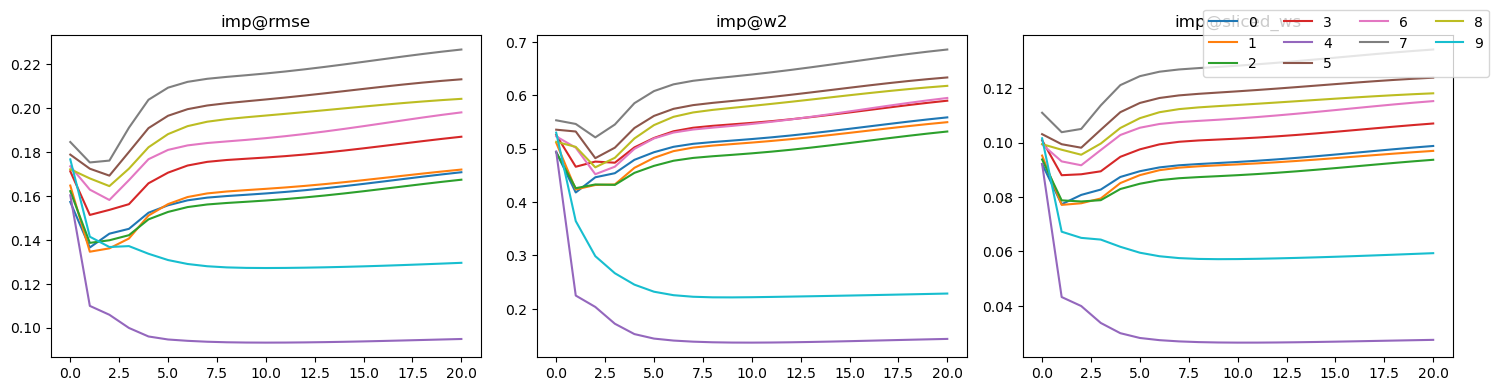

{'imp@rmse': 0.17460549546212242, 'imp@ws': 0.5063658782821595, 'imp@sliced_ws': 0.09649834389568791}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:03:21.061 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:03:21.062 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:03:59.585 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:03:59.586 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:04:42.563 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:04:42.565 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:04:46.910 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.37110129999928


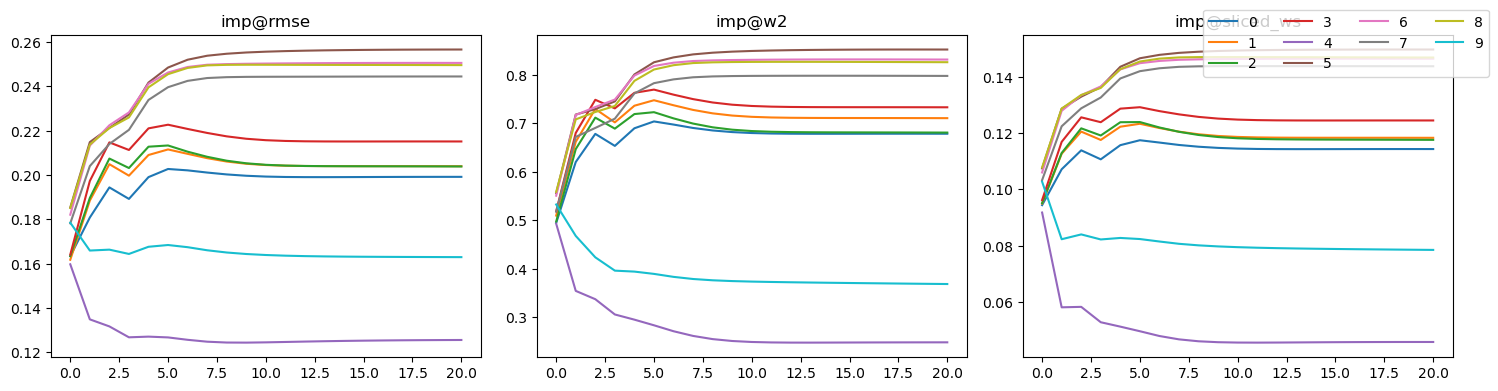

{'imp@rmse': 0.21121789450296774, 'imp@ws': 0.6732120612406903, 'imp@sliced_ws': 0.11857499135282289}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:05:00.931 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:05:00.932 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:05:39.382 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:05:39.382 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:06:22.961 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:06:22.962 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:06:27.290 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 89.87506639992353


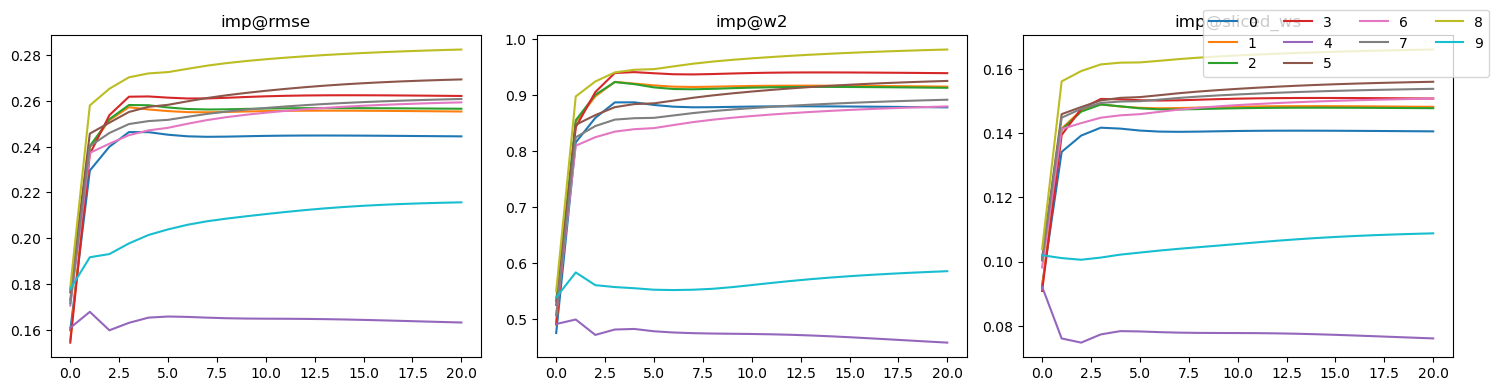

{'imp@rmse': 0.2467418430610748, 'imp@ws': 0.8363045112301606, 'imp@sliced_ws': 0.13984655344991728}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [100, 100, 100, 100, 9600, 100, 100, 100, 100, 9600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:06:41.372 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:06:41.374 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:07:19.889 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:07:19.890 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:08:03.629 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:08:03.630 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:08:08.298 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 90.44277339999098


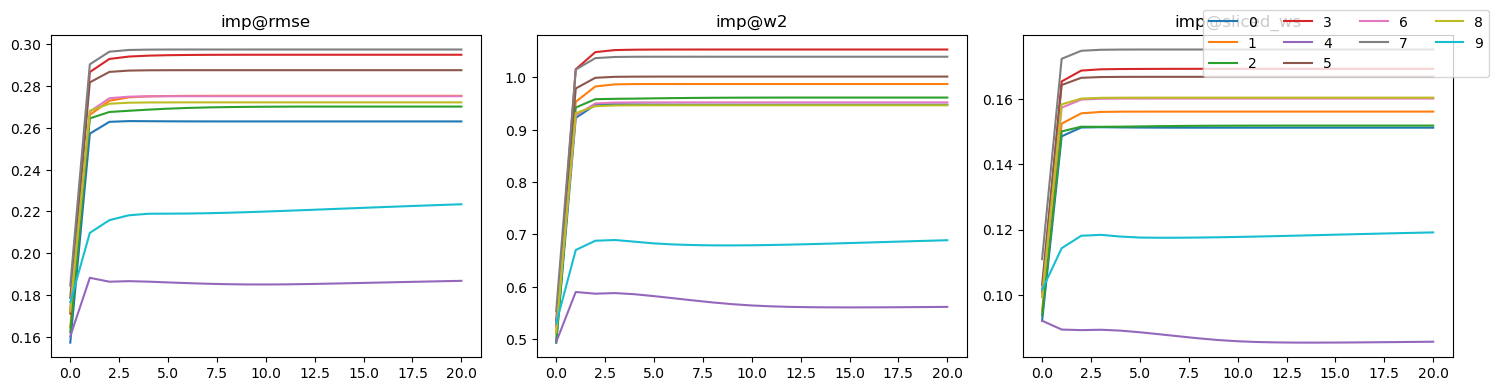

{'imp@rmse': 0.26458770197625503, 'imp@ws': 0.913600448668672, 'imp@sliced_ws': 0.1494799053031388}


In [79]:
results_compl_gamma = []

for alpha in [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
    config2['data_partition']['strategy'] = 'uneven10'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": 0.5,
            "gamma": alpha,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_gamma.append(ret.copy())

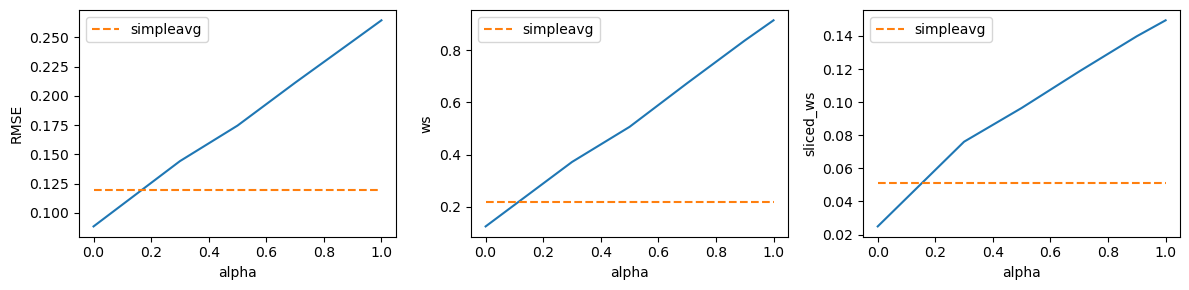

In [80]:
x = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_gamma]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_gamma]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_gamma]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

rmse = 0.11946250623887397
ws = 0.217692259541295
sliced_ws = 0.05089186952055539
ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

##### Alpha (case 2)

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [250, 250, 2000, 2000, 13500, 250, 250, 2000, 2000, 13500]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:11:22.951 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:11:22.952 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:12:31.241 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:12:31.242 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:13:46.506 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:13:46.507 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:13:54.081 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 157.6907944000559


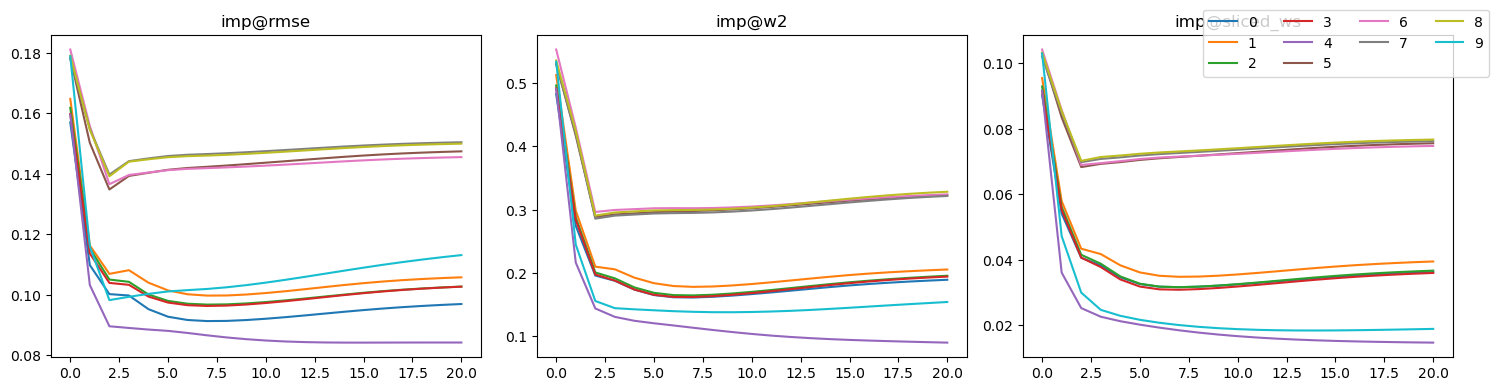

{'imp@rmse': 0.11925567869689761, 'imp@ws': 0.22969645948426273, 'imp@sliced_ws': 0.04819715916829097}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [250, 250, 2000, 2000, 13500, 250, 250, 2000, 2000, 13500]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:14:10.962 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:14:10.963 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:15:19.058 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:15:19.059 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:16:34.852 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:16:34.853 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:16:42.465 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 157.8688291000435


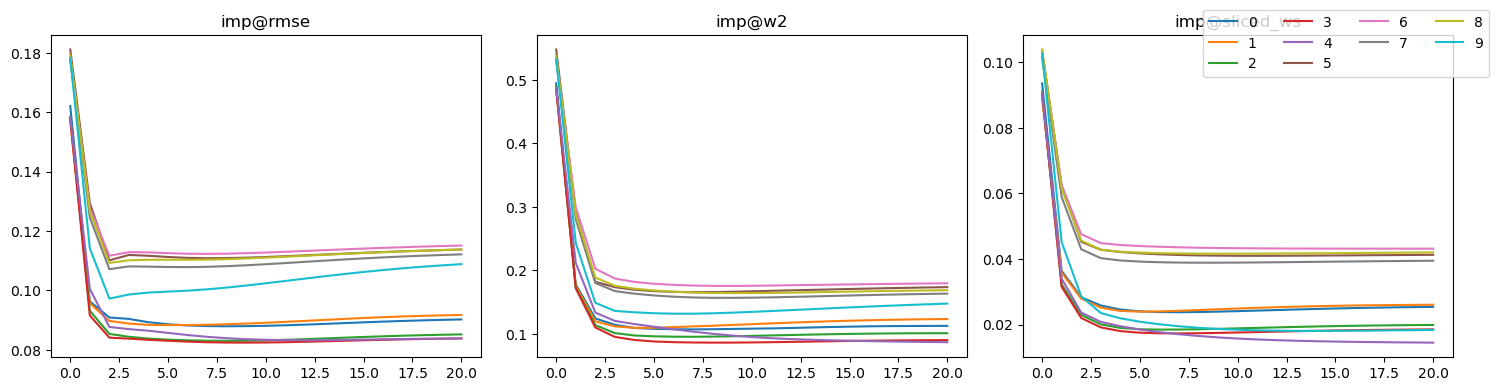

{'imp@rmse': 0.09939659950491729, 'imp@ws': 0.13431305834386809, 'imp@sliced_ws': 0.028765055764003723}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [250, 250, 2000, 2000, 13500, 250, 250, 2000, 2000, 13500]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:16:59.464 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:16:59.465 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:18:07.842 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:18:07.843 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:19:24.016 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:19:24.018 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:19:31.663 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 158.59169089992065


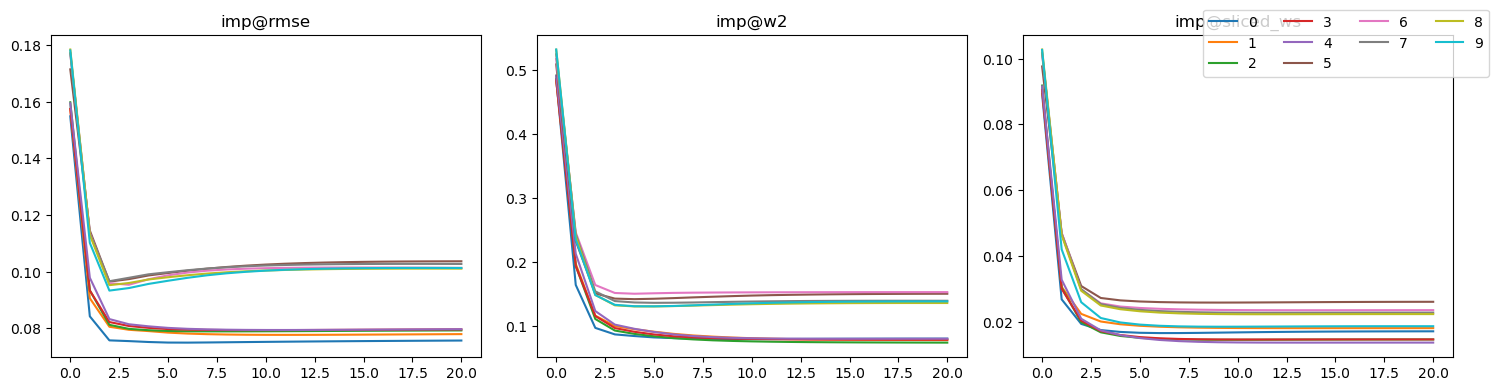

{'imp@rmse': 0.09017272826136011, 'imp@ws': 0.11125324959270183, 'imp@sliced_ws': 0.019130436471983075}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [250, 250, 2000, 2000, 13500, 250, 250, 2000, 2000, 13500]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:19:48.750 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:19:48.750 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:20:56.773 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:20:56.774 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:22:12.490 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:22:12.490 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:22:20.132 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 157.80606880004052


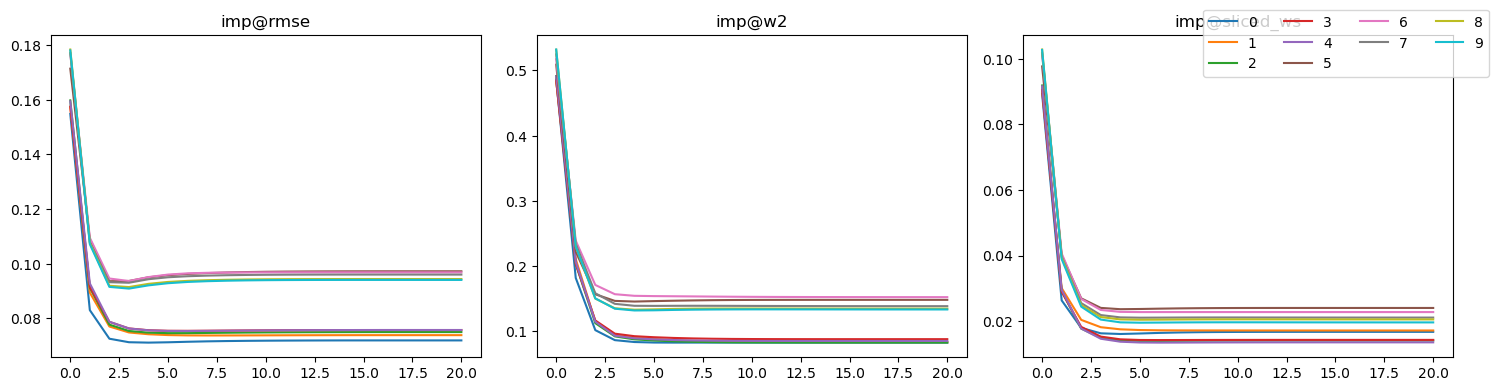

{'imp@rmse': 0.08500348689194835, 'imp@ws': 0.11298137306129762, 'imp@sliced_ws': 0.01838745783665672}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [250, 250, 2000, 2000, 13500, 250, 250, 2000, 2000, 13500]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:22:37.127 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:22:37.128 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:23:45.161 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:23:45.162 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:25:01.210 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:25:01.211 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:25:08.989 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 158.2707001999952


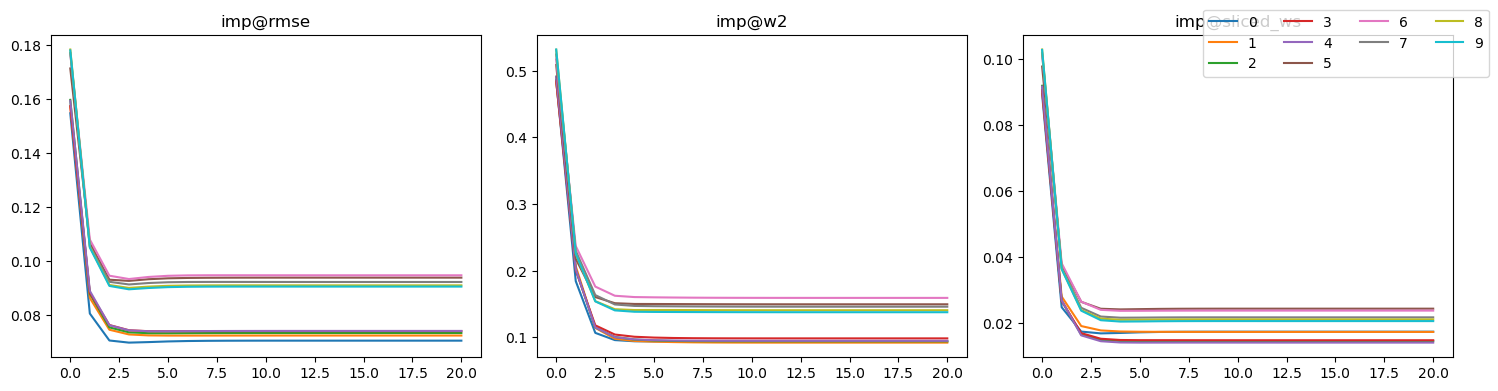

{'imp@rmse': 0.08281582623085862, 'imp@ws': 0.12034753384949777, 'imp@sliced_ws': 0.019002109085042934}


m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9) (2000, 9)
(18000, 9)
uneven10 {}
sample sizes:  [250, 250, 2000, 2000, 13500, 250, 250, 2000, 2000, 13500]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-10-26 10:25:26.289 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:25:26.290 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-10-26 10:26:34.895 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:26:34.896 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-10-26 10:27:50.264 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-10-26 10:27:50.265 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-10-26 10:27:57.816 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 157.97805269993842


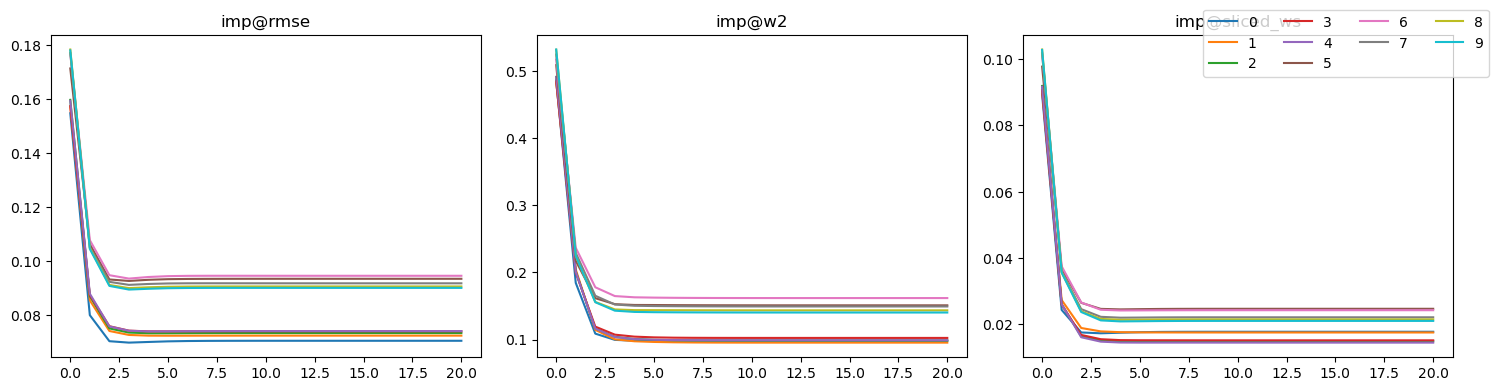

{'imp@rmse': 0.08258438178362189, 'imp@ws': 0.12386942457501302, 'imp@sliced_ws': 0.019360359980772283}


In [82]:
results_compl_alpha = []

for alpha in [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = 'codrna'
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
    config2['data_partition']['strategy'] = 'uneven10'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.0,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


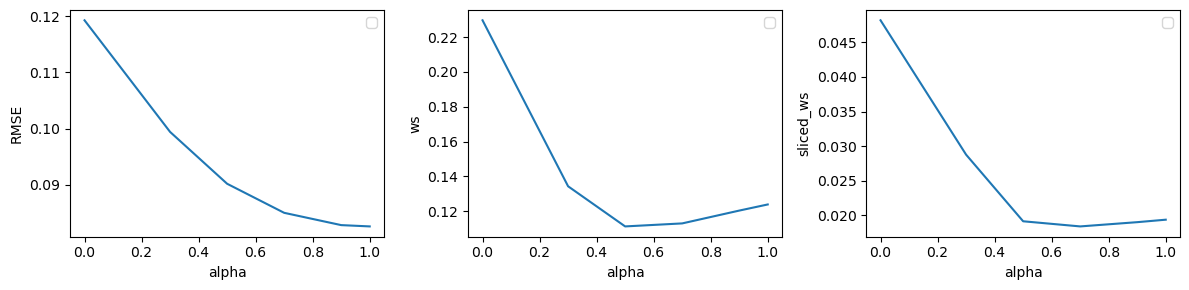

In [83]:
x = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.11946250623887397
# ws = 0.217692259541295
# sliced_ws = 0.05089186952055539
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()